# Machine Learning creditworthiness estimation

The aim of this project is to build a model that can estimate the creditworthiness of a bank’s customers, in order to help the credit card team understand whether or not to accept the request for the credit card. The model will be based on anonymised data of customers who have already obtained the credit card and pay regularly. The dataset contains the information of depositors who have requested the opening of a credit line. The model must predict the target variable that indicates if the customer has good credit standing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, precision_recall_curve, 
    roc_curve, average_precision_score
)

In [2]:
# Setting some parameters for matplotlib figures
plt.rcParams["figure.dpi"] = 240
sns.set_theme()

In [68]:
# Load the original dataset
url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv"
df = pd.read_csv(url)

## Exploratory analysis

### Dataset overview

In [69]:
# Dataset size and first 5 rows
print(f"Dataset size: {df.shape[0]} rows and {df.shape[1]} columns")
df.head()

Dataset size: 338427 rows and 19 columns


ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment    -11778.0        -4438.0   
1        Civil marriage   Rented apartment    -11777.0        -4459.0   
2               Married  House / apartment    -21471.0        -1144.0   
3  Single / not married  House / apartment    -18489.0        -3122.0   
4  Single / not married  House / apartment    -19093.0        -3070.0   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  \
0         1.0              1.0         0.0         0.0             NaN   
1         1.0              1.0         0.0         0.0             NaN   
2         1.0              0.0         0.0         0.0  Security staff   
3         1.0              0.0         1.0         1.0     Sales staff   
4         1.0              0.0         1.0         1.0     Sales staff   

   CNT_FAM_MEMBERS  TARGET  
0              2.0       0  
1              2.0       0  
2              2.0       0  
3              1.0       1  
4              1.0       1

In [70]:
# General information on the dataset
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338427 entries, 0 to 338426
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   338427 non-null  int64  
 1   CODE_GENDER          338427 non-null  object 
 2   FLAG_OWN_CAR         338427 non-null  object 
 3   FLAG_OWN_REALTY      338427 non-null  object 
 4   CNT_CHILDREN         338427 non-null  int64  
 5   AMT_INCOME_TOTAL     338427 non-null  float64
 6   NAME_INCOME_TYPE     338427 non-null  object 
 7   NAME_EDUCATION_TYPE  338427 non-null  object 
 8   NAME_FAMILY_STATUS   338426 non-null  object 
 9   NAME_HOUSING_TYPE    338426 non-null  object 
 10  DAYS_BIRTH           338426 non-null  float64
 11  DAYS_EMPLOYED        338426 non-null  float64
 12  FLAG_MOBIL           338426 non-null  float64
 13  FLAG_WORK_PHONE      338426 non-null  float64
 14  FLAG_PHONE           338426 non-null  float64
 15  FLA

In [71]:
# Count of null values per column
print("Null values:")
print(df.isnull().sum())

Null values:
ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          1
NAME_HOUSING_TYPE           1
DAYS_BIRTH                  1
DAYS_EMPLOYED               1
FLAG_MOBIL                  1
FLAG_WORK_PHONE             1
FLAG_PHONE                  1
FLAG_EMAIL                  1
OCCUPATION_TYPE        103342
CNT_FAM_MEMBERS             1
TARGET                      0
dtype: int64


In [72]:
# General descriptive statistics
df.describe()

ID   CNT_CHILDREN  AMT_INCOME_TOTAL     DAYS_BIRTH  \
count  3.384270e+05  338427.000000      3.384270e+05  338426.000000   
mean   5.821200e+06       0.428934      1.876685e+05  -15998.212897   
std    4.517704e+05       0.727990      1.107863e+05    4193.088539   
min    5.008804e+06       0.000000      2.554898e+04  -26636.000000   
25%    5.439602e+06       0.000000      1.212299e+05  -19467.000000   
50%    5.878907e+06       0.000000      1.628553e+05  -15623.000000   
75%    6.140206e+06       1.000000      2.252082e+05  -12516.250000   
max    6.841875e+06      19.000000      7.071016e+06   -7566.000000   

       DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE     FLAG_PHONE  \
count  338426.000000    338426.0    338426.000000  338426.000000   
mean    60234.533869         1.0         0.211379       0.293302   
std    138522.923248         0.0         0.408287       0.455276   
min    -17973.000000         1.0         0.000000       0.000000   
25%     -3116.000000         1.0         0.000000       0.000000   
50%     -1483.000000         1.0         0.000000       0.000000   
75%      -378.000000         1.0         0.000000       1.000000   
max    396498.000000         1.0         1.000000       1.000000   

          FLAG_EMAIL  CNT_FAM_MEMBERS         TARGET  
count  338426.000000    338426.000000  338427.000000  
mean        0.105181         2.197228       0.087824  
std         0.306787         0.899570       0.283039  
min         0.000000         1.000000       0.000000  
25%         0.000000         2.000000       0.000000  
50%         0.000000         2.000000       0.000000  
75%         0.000000         3.000000       0.000000  
max         1.000000        20.000000       1.000000

### Data preprocessing

First, the categorical variable OCCUPATION_TYPE, with about 100000 missing values, will be handled.

In [73]:
print(df["OCCUPATION_TYPE"].value_counts(dropna=False))

OCCUPATION_TYPE
NaN                      103342
Laborers                  60146
Core staff                33527
Sales staff               31652
Managers                  27384
Drivers                   20020
High skill tech staff     13399
Accountants               12281
Medicine staff            10438
Cooking staff              6248
Security staff             6218
Cleaning staff             4594
Private service staff      2787
Low-skill Laborers         1714
Secretaries                1577
Waiters/barmen staff       1245
Realty agents               852
HR staff                    567
IT staff                    436
Name: count, dtype: int64


As these missing values include all unemployed clients but also clients with unreported occupation type, by using the 'DAYS_EMPLOYED' feature, they will be replaced with the category "Unemployed" in the first case and with the category "Other" in the second case.

In [74]:
# Replace NaNs where clients are unemployed with the category "Unemployed"
df.loc[df['DAYS_EMPLOYED'] > 0, 'OCCUPATION_TYPE'] = df.loc[df['DAYS_EMPLOYED'] > 0, 'OCCUPATION_TYPE'].fillna('Unemployed')

# Replace the remaining NaNs with "Other"
df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Other")

print(df["OCCUPATION_TYPE"].value_counts(dropna=False))

OCCUPATION_TYPE
Laborers                 60146
Unemployed               57841
Other                    45501
Core staff               33527
Sales staff              31652
Managers                 27384
Drivers                  20020
High skill tech staff    13399
Accountants              12281
Medicine staff           10438
Cooking staff             6248
Security staff            6218
Cleaning staff            4594
Private service staff     2787
Low-skill Laborers        1714
Secretaries               1577
Waiters/barmen staff      1245
Realty agents              852
HR staff                   567
IT staff                   436
Name: count, dtype: int64


All the other samples with missing values in other columns are dropped.

In [75]:
# Drop all samples with NaNs in other columns
df = df.dropna()

# Count of null values per column after drop
print("Null values (after drop NaNs):")
print(df.isnull().sum())

# Remaining samples after drop
print(f"Number of samples (after drop NaNs): {df.shape[0]}")

Null values (after drop NaNs):
ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
TARGET                 0
dtype: int64
Number of samples (after drop NaNs): 338426


The DAYS_EMPLOYED feature indicates the number of days since the date of recruitment (if positive, indicates the number of days since the client was unemployed)

In [76]:
employed = df[df["DAYS_EMPLOYED"]<0]
unemployed = df[df["DAYS_EMPLOYED"]>0]
print(f"Employed: {len(employed)} clients")
print(f"Unemployed: {len(unemployed)} clients")

Employed: 280585 clients
Unemployed: 57841 clients


By plottig the distribution of the DAYS_EMPLOYED feature, it results that unemployed clients (with positive values) are assigned to an arbitrary placeholder value of around 365000.

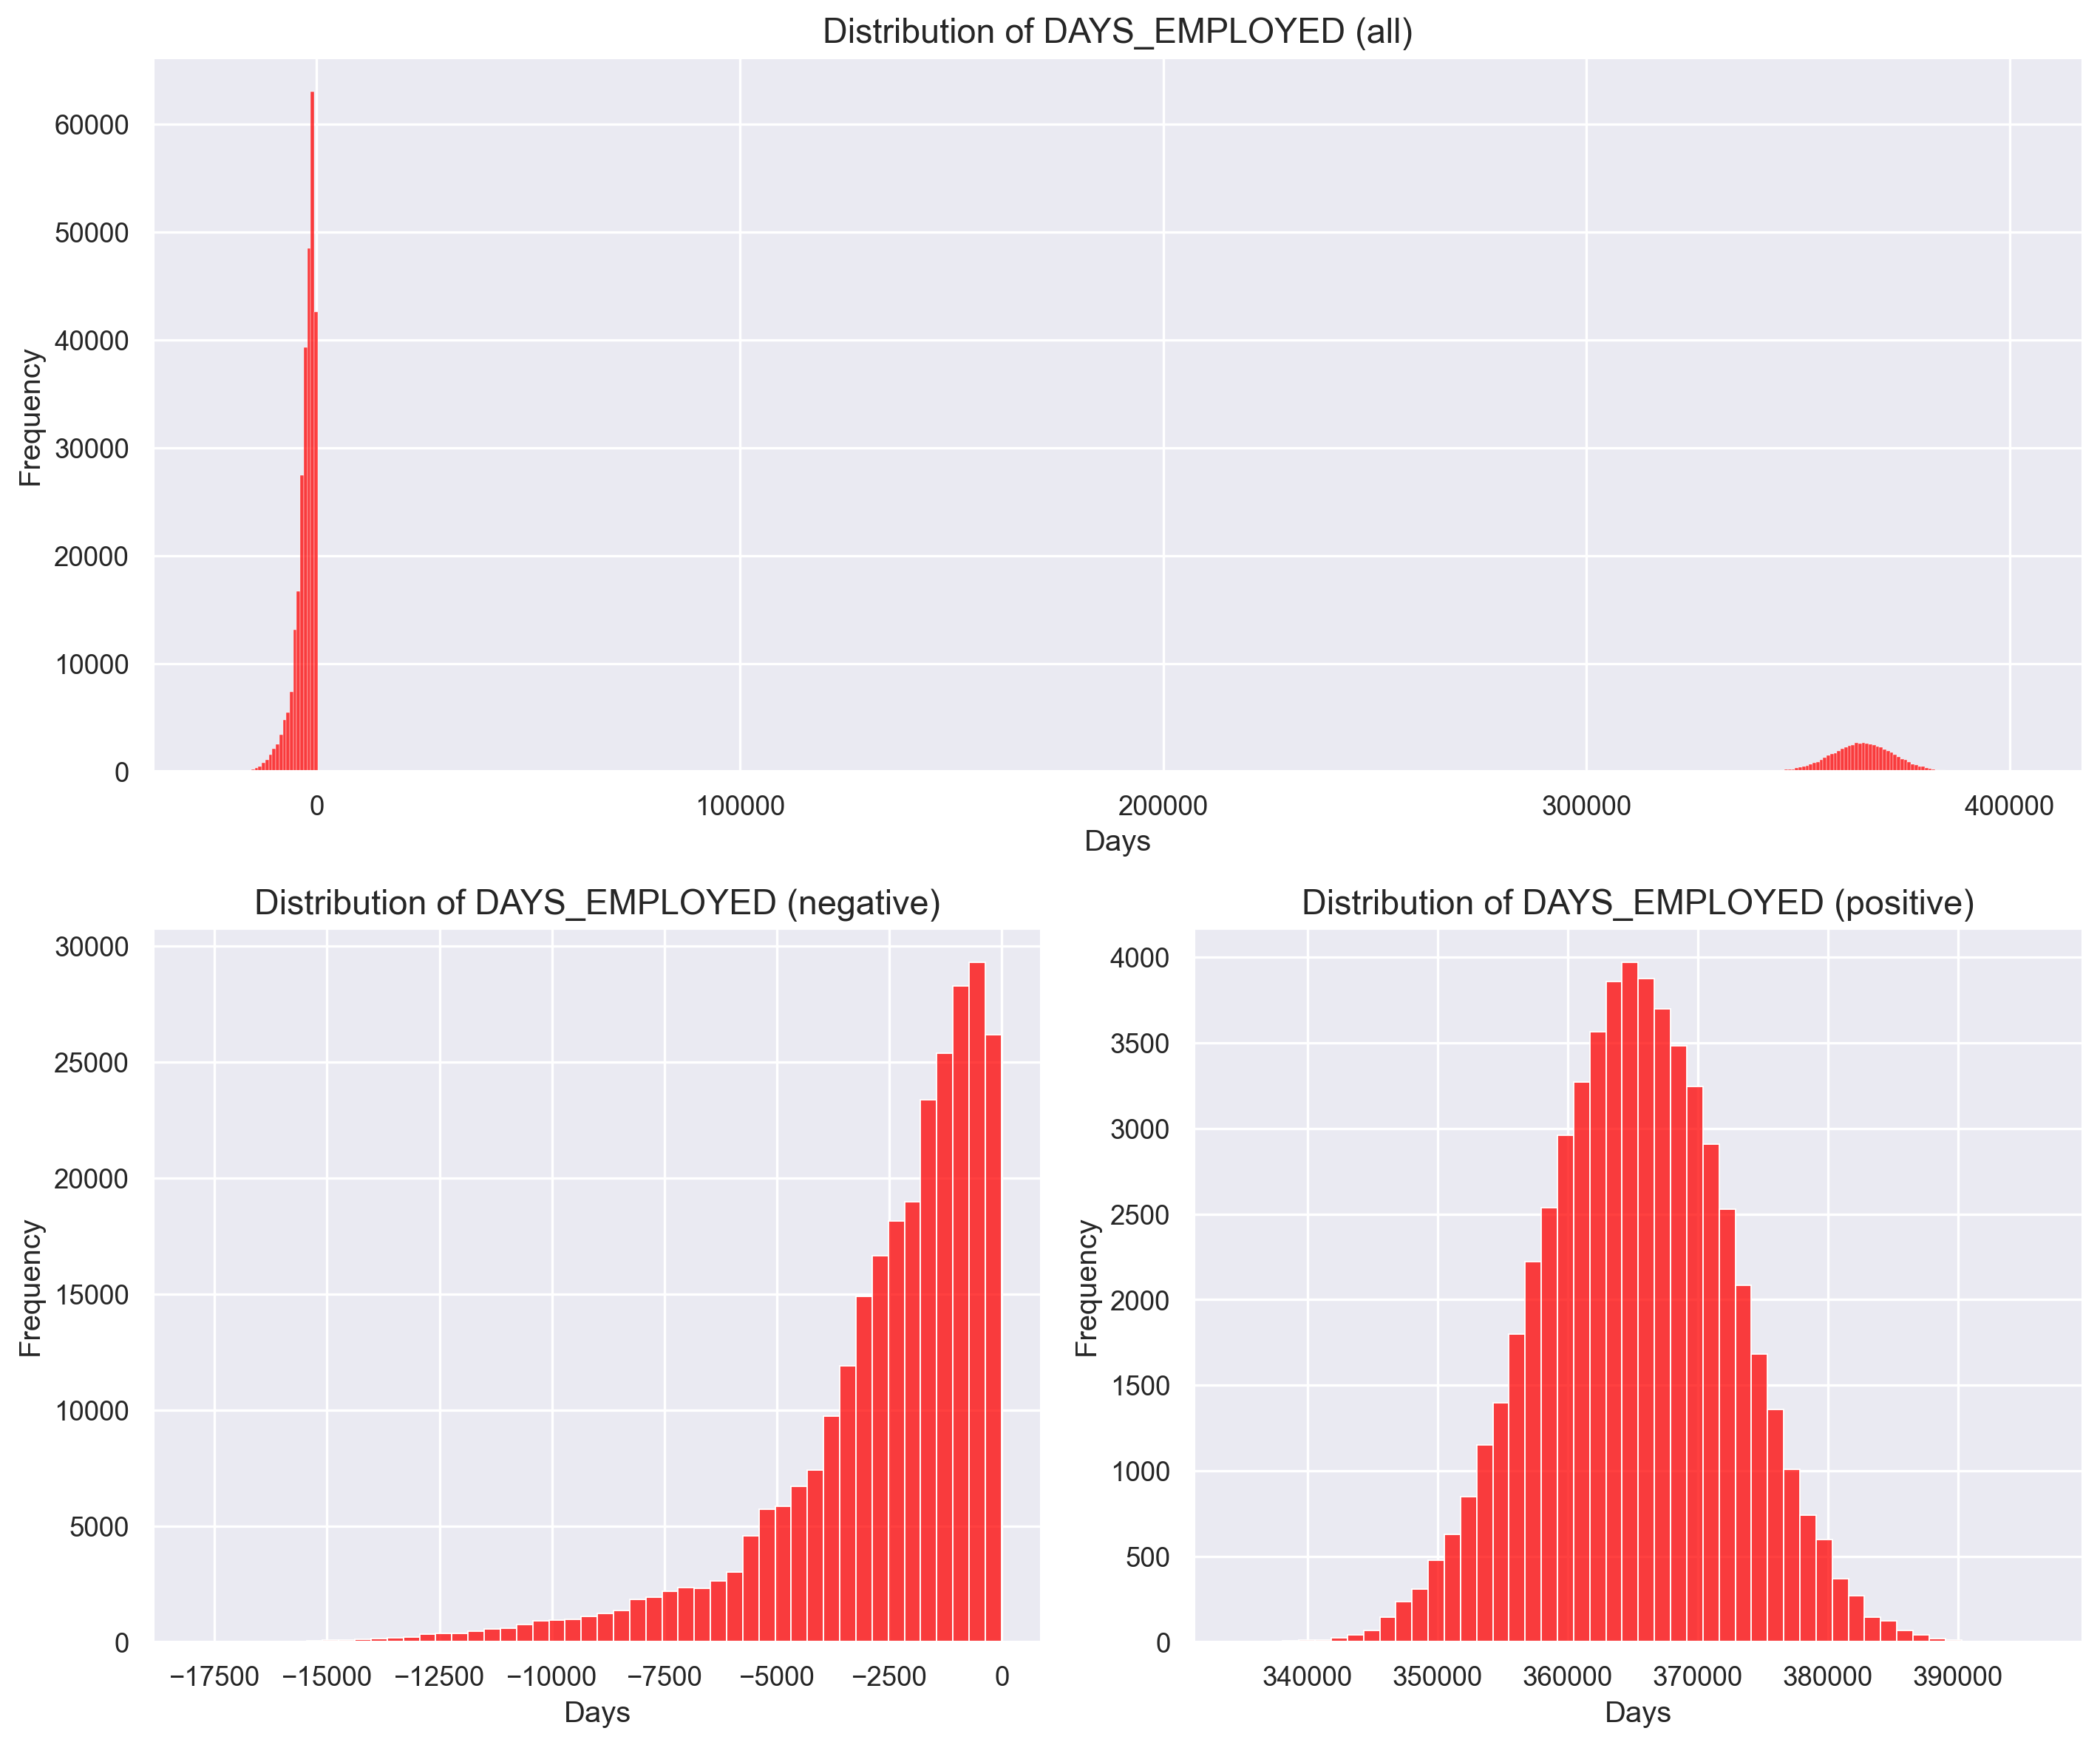

In [77]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.histplot(df["DAYS_EMPLOYED"], bins=500, kde=False, color="red")
plt.title(f'Distribution of DAYS_EMPLOYED (all)', fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 2, 3)
sns.histplot(employed["DAYS_EMPLOYED"], bins=50, kde=False, color="red")
plt.title(f'Distribution of DAYS_EMPLOYED (negative)', fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 2, 4)
sns.histplot(unemployed["DAYS_EMPLOYED"], bins=50, kde=False, color="red")
plt.title(f'Distribution of DAYS_EMPLOYED (positive)', fontsize=14)
plt.xlabel("Days", fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

By checking the NAME_INCOME_TYPE feature, it results that all "unemployed" clients are associated with the "Pensioner" category.

In [78]:
type_count = df[df["DAYS_EMPLOYED"]>0]["NAME_INCOME_TYPE"].value_counts()
print(type_count)

NAME_INCOME_TYPE
Pensioner    57841
Name: count, dtype: int64


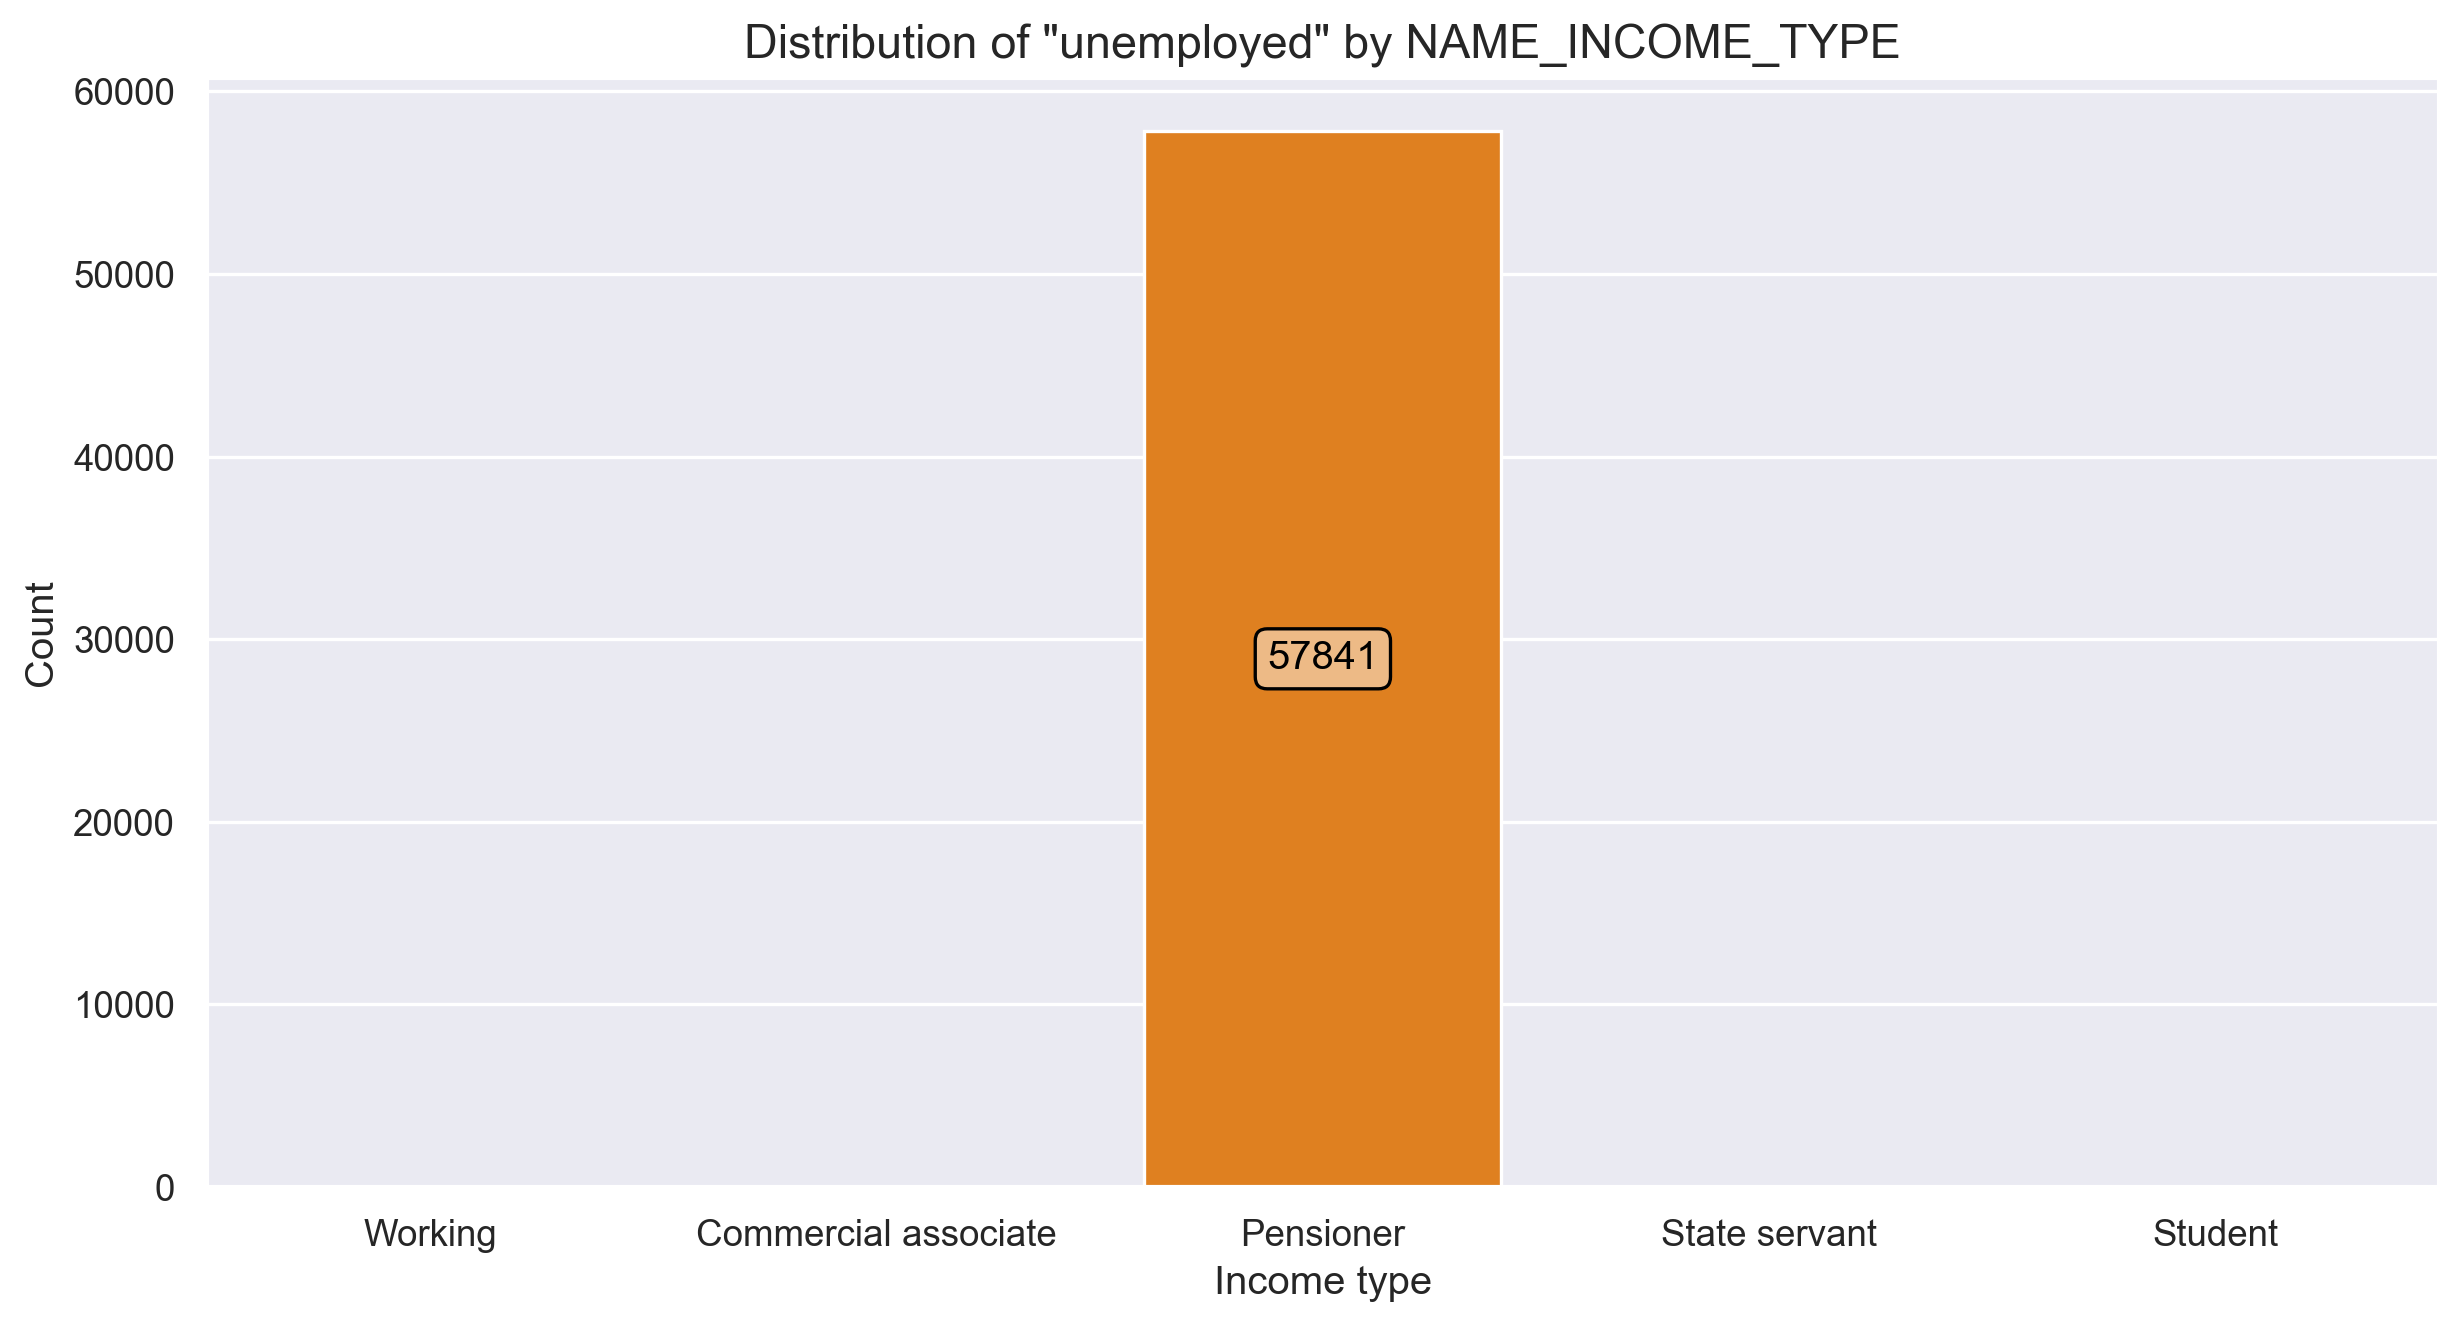

In [79]:
plt.figure(figsize=(12, 6))

# Distribution of Income type for "unemployed" clients
sns.countplot(x="NAME_INCOME_TYPE", hue="NAME_INCOME_TYPE", data=df[df["DAYS_EMPLOYED"]>0], order=df["NAME_INCOME_TYPE"].value_counts().index, palette='autumn', legend=False)
plt.title(f'Distribution of "unemployed" by NAME_INCOME_TYPE', fontsize=14)
plt.xlabel("Income type", fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.annotate(f"{type_count.iloc[0]}", 
                 xy=(2, type_count.iloc[0]/2), ha='center', va='center', fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.show()

Considering that all "Pensioner" samples have the "TARGET" value as 0 (low credit standing), it can be assumed that the extremely high values of the DAYS_EMPLOYED features will have a negative impact on the predictive model. Conversely, more negative values (indicating a stable employment) will have a positive impact on the model.

In [80]:
target_count = df[df["DAYS_EMPLOYED"]>0]["TARGET"].value_counts()
print(target_count)

TARGET
0    57841
Name: count, dtype: int64


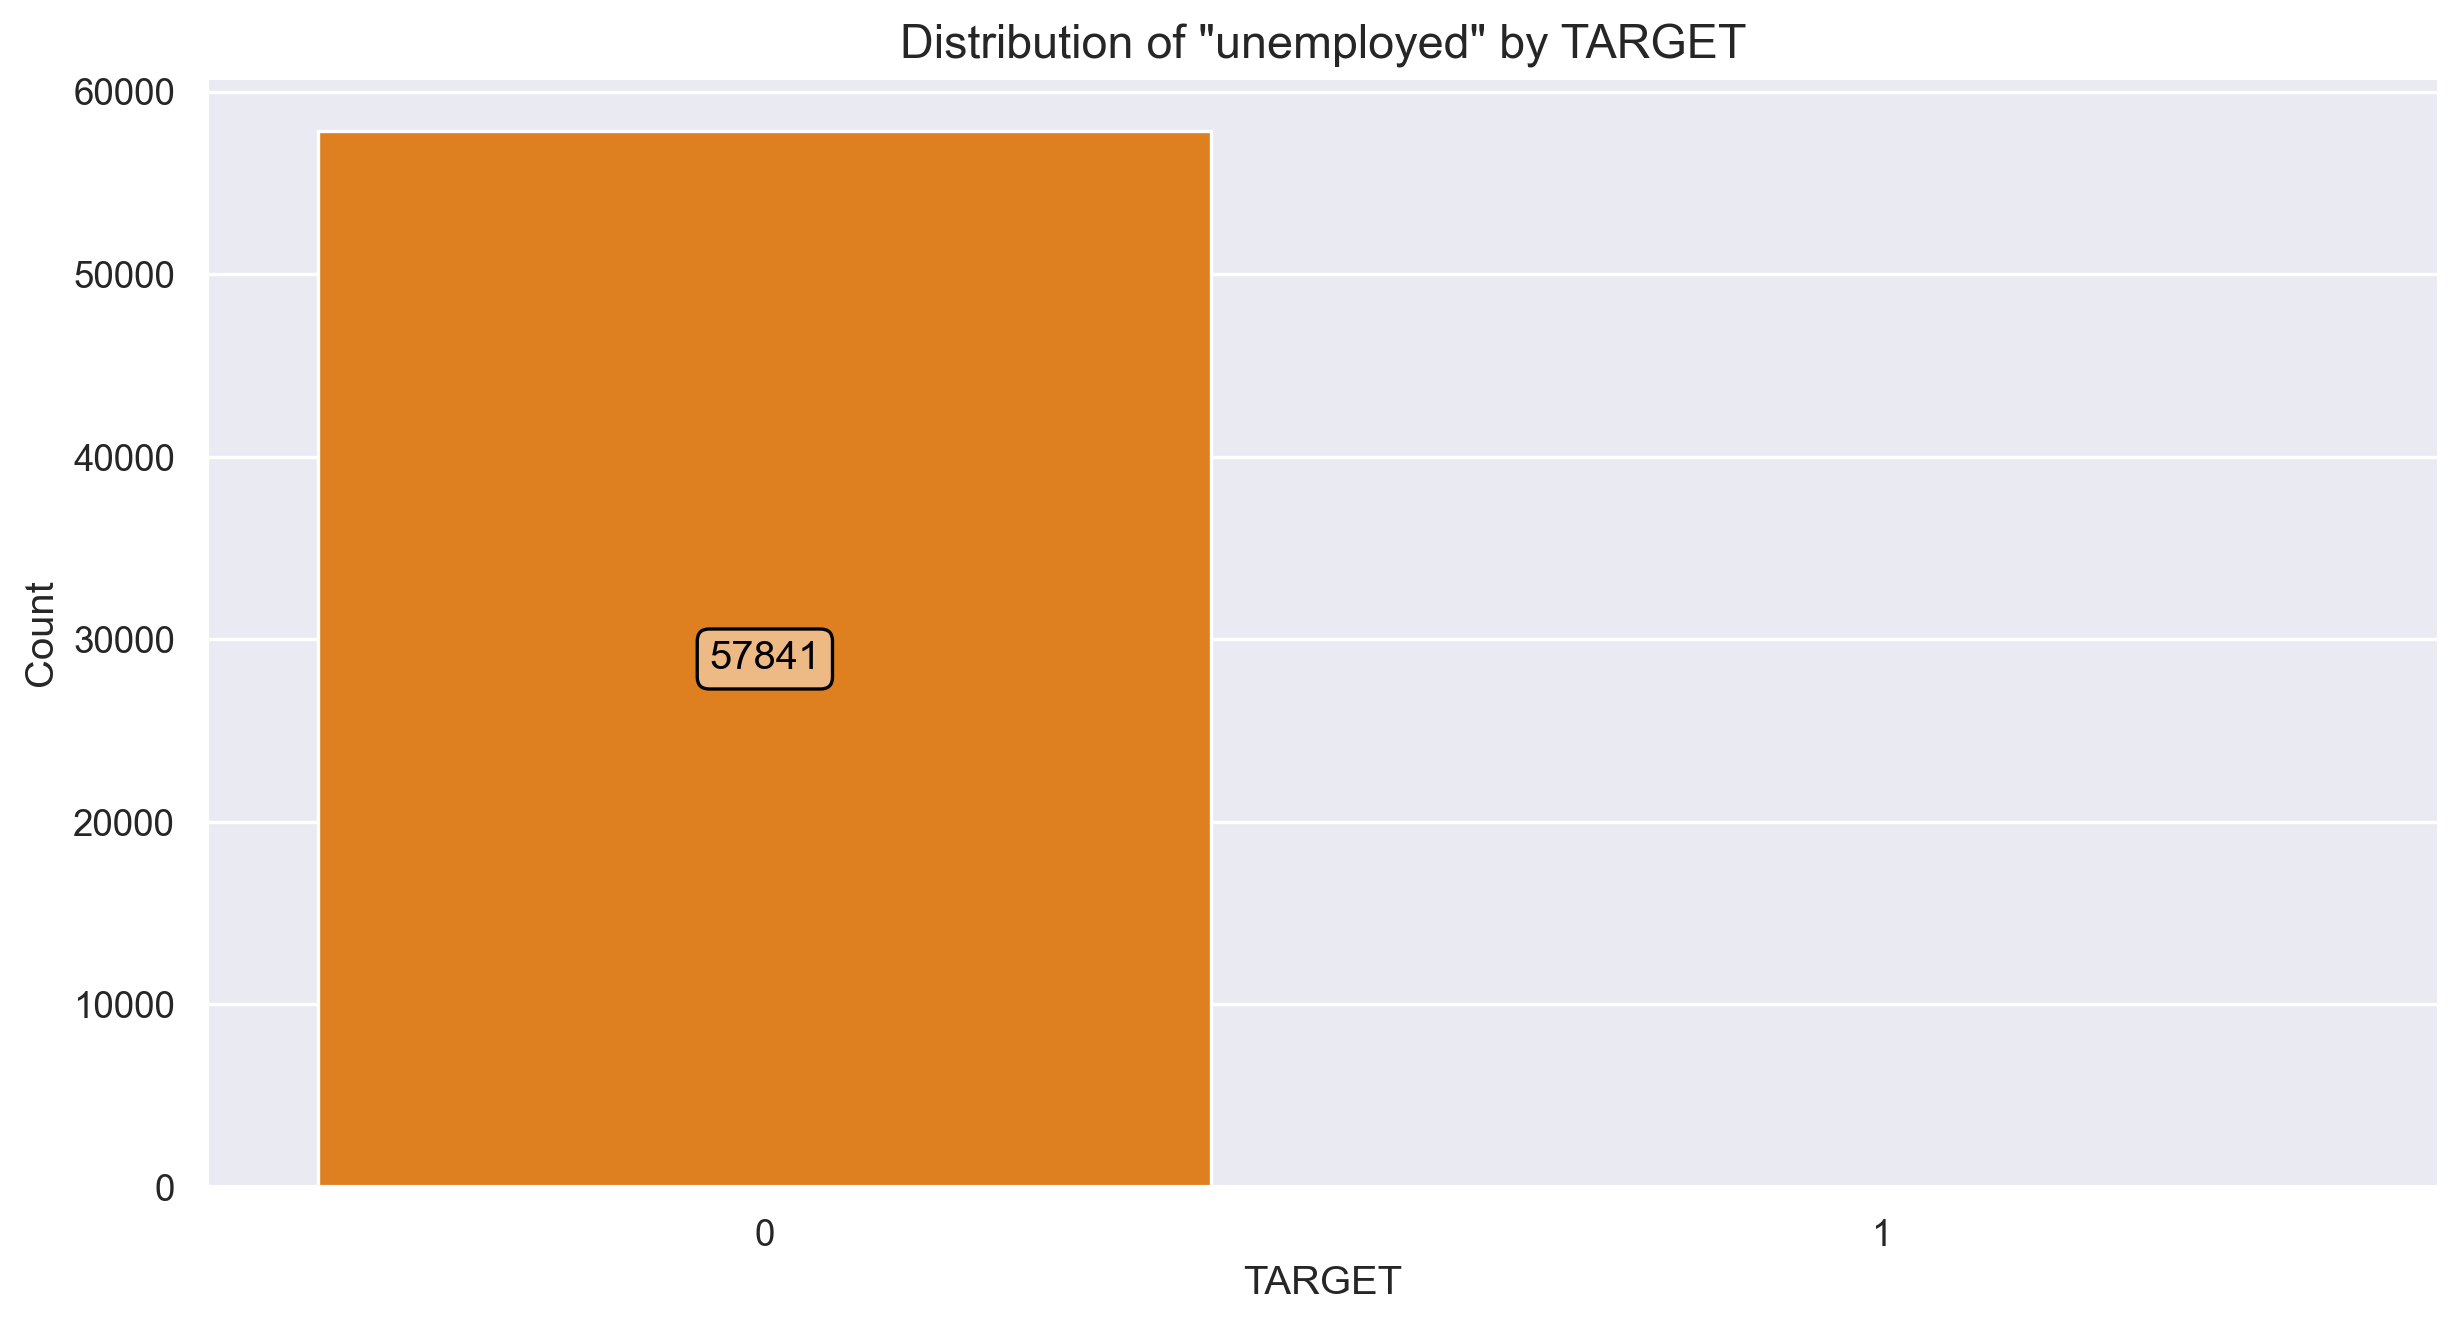

In [81]:
plt.figure(figsize=(12, 6))

# Distribution of Target for "unemployed" clients
sns.countplot(x="TARGET", hue="TARGET", data=df[df["DAYS_EMPLOYED"]>0], order=df["TARGET"].value_counts().index, palette='autumn', legend=False)
plt.title(f'Distribution of "unemployed" by TARGET', fontsize=14)
plt.xlabel("TARGET", fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.annotate(f"{target_count.iloc[0]}", 
                 xy=(0, target_count.iloc[0]/2), ha='center', va='center', fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.show()

By checking the NAME_INCOME_TYPE for clients with OCCUPATION_TYPE set to "Other", it results that clients with "other occupation" have an income related to the categories "Working", "Commercial associate", "State servant" or "Student".

In [82]:
type_count = df[df["OCCUPATION_TYPE"]=="Other"]["NAME_INCOME_TYPE"].value_counts().reindex(df["NAME_INCOME_TYPE"].unique(), fill_value=0)
print(type_count)

NAME_INCOME_TYPE
Working                 27783
Commercial associate    12927
Pensioner                   0
State servant            4785
Student                     5
Name: count, dtype: int64


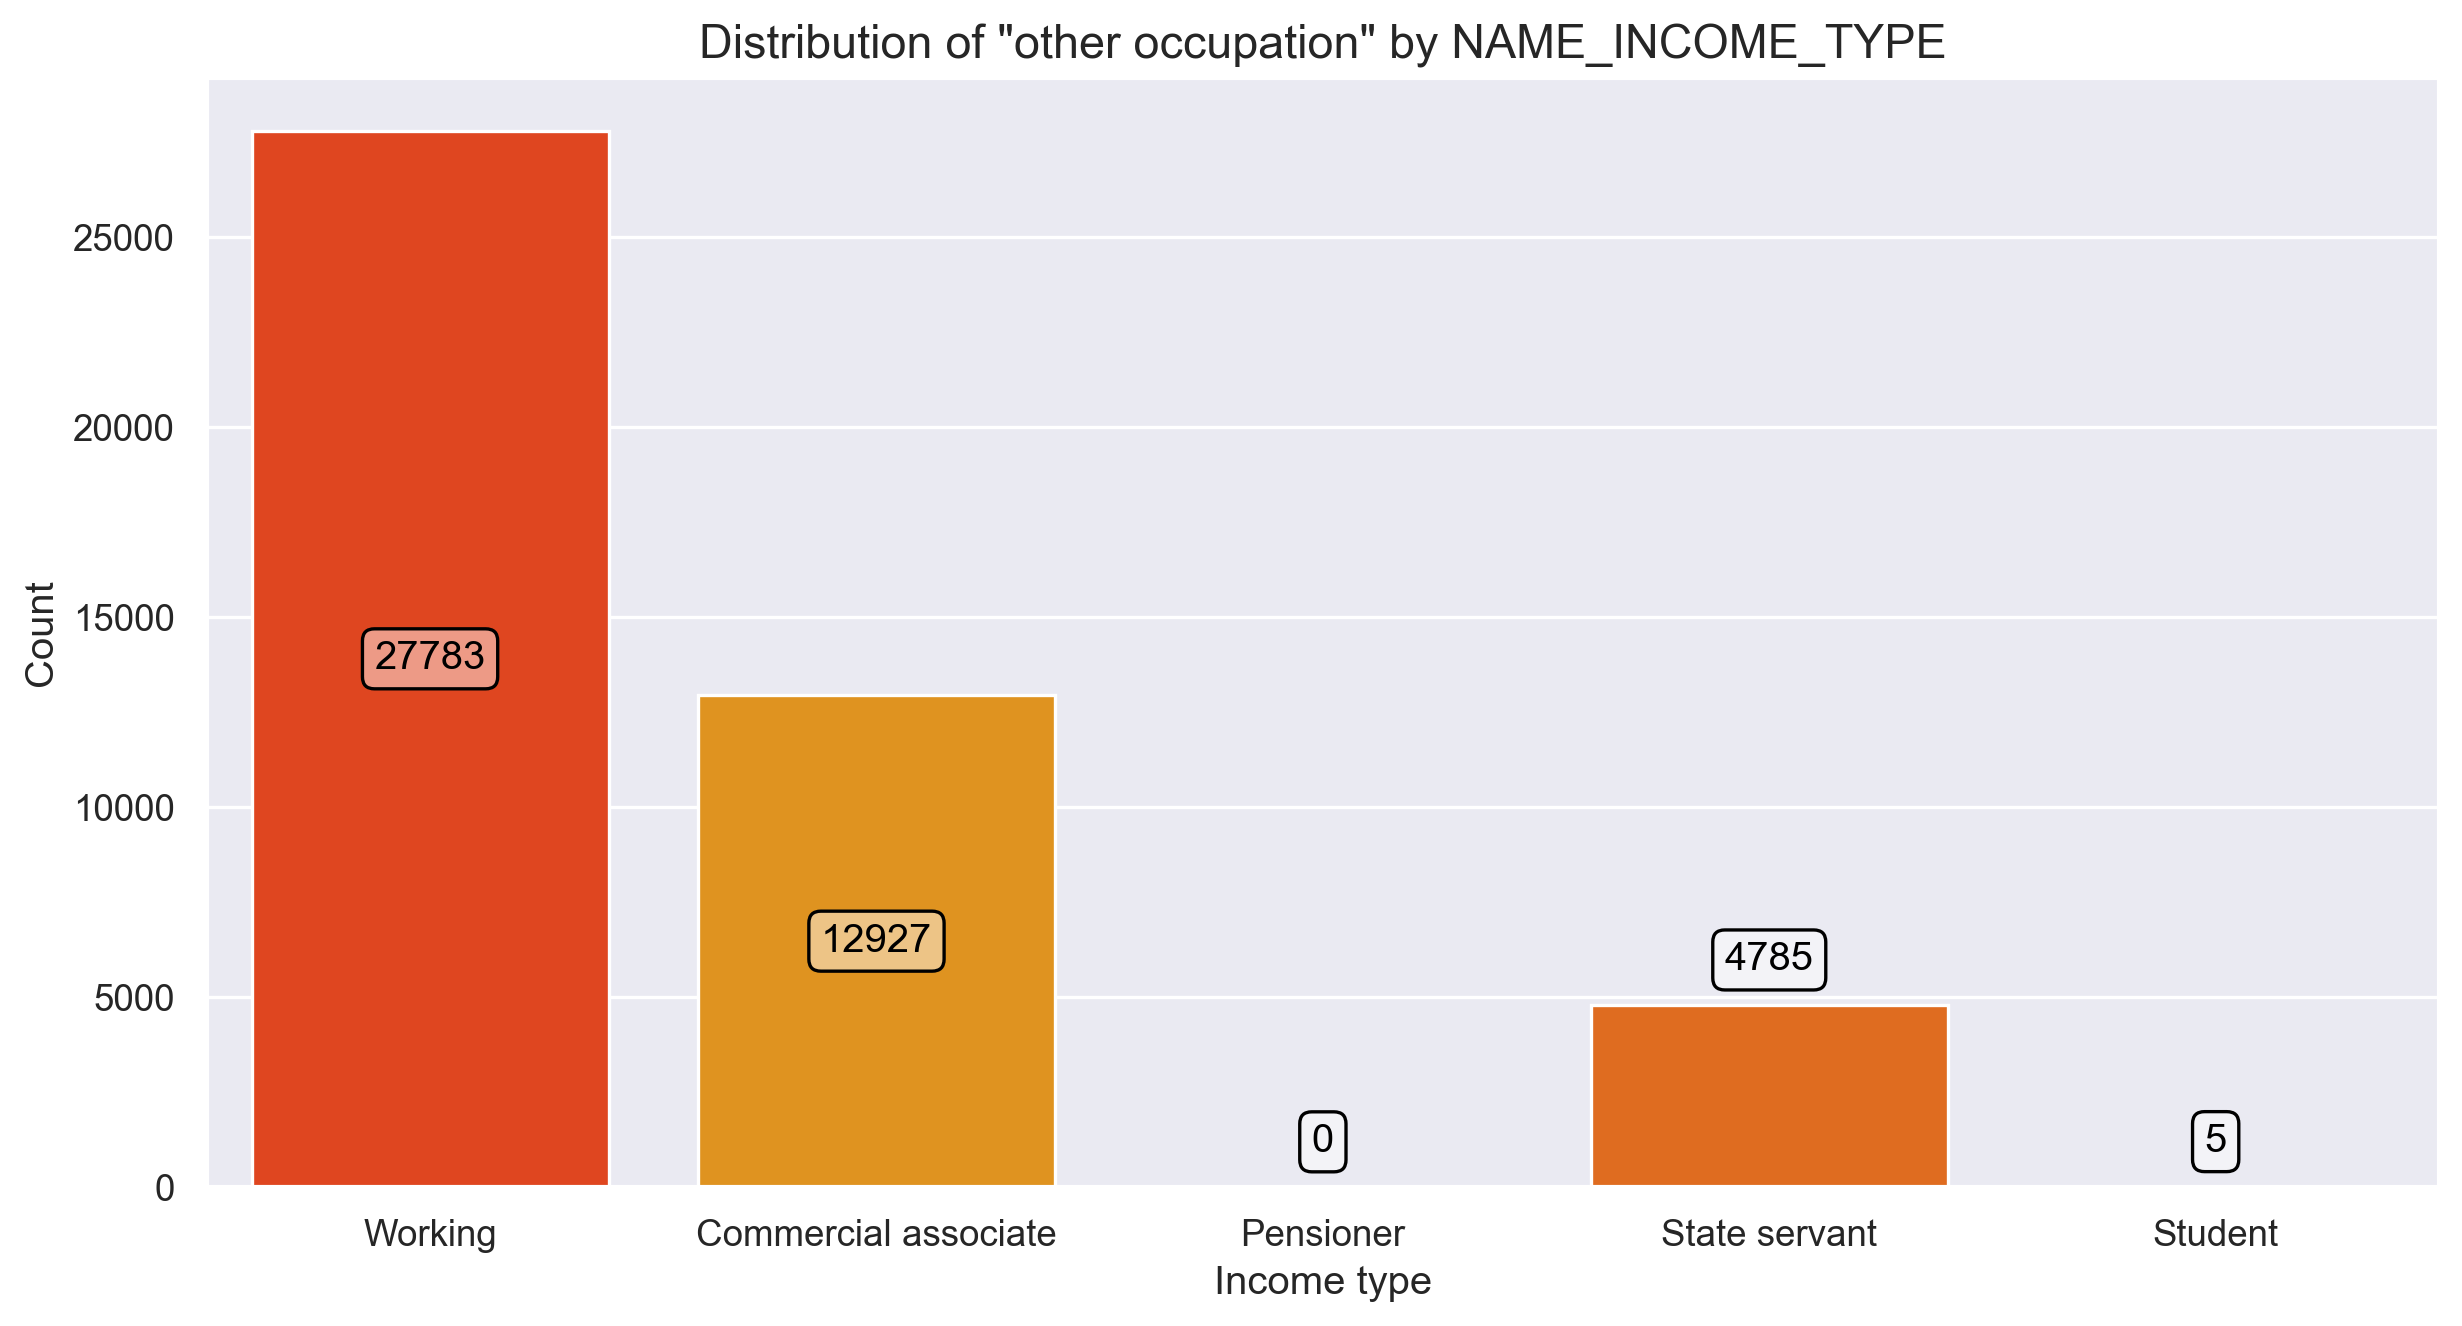

In [83]:
plt.figure(figsize=(12, 6))

# Distribution of Income type for clients with "other occupation"
sns.countplot(x="NAME_INCOME_TYPE", hue="NAME_INCOME_TYPE", data=df[df["OCCUPATION_TYPE"]=="Other"], order=df["NAME_INCOME_TYPE"].value_counts().index, palette='autumn', legend=False)
plt.title(f'Distribution of "other occupation" by NAME_INCOME_TYPE', fontsize=14)
plt.xlabel("Income type", fontsize=12)
plt.ylabel('Count', fontsize=12)

for i, count in enumerate(type_count):
    y_pos = type_count.iloc[i]/2 if type_count.iloc[i]/2 > np.amax(type_count)*.1 else type_count.iloc[i]
    y_offset = 0 if type_count.iloc[i]/2 > np.amax(type_count)*.1 else 45
    plt.annotate(f"{type_count.iloc[i]}", 
                 xy=(i, y_pos), xytext=(0, y_offset), textcoords="offset pixels",
                 ha='center', va='center', 
                 fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.show()

By using the 'NAME_INCOME_TYPE' feature, the "Other" occupation category will be replaced with the corresponding specific category.

In [84]:
# Replace clients with "other occupation" with specific categories
df.loc[(df['OCCUPATION_TYPE']=="Other") & (df['NAME_INCOME_TYPE'] == 'Working'), "OCCUPATION_TYPE"] = "Other working"
df.loc[(df['OCCUPATION_TYPE']=="Other") & (df['NAME_INCOME_TYPE'] == 'Commercial associate'), "OCCUPATION_TYPE"] = "Other commercial associate"
df.loc[(df['OCCUPATION_TYPE']=="Other") & (df['NAME_INCOME_TYPE'] == 'State servant'), "OCCUPATION_TYPE"] = "Other state servant"
df.loc[(df['OCCUPATION_TYPE']=="Other") & (df['NAME_INCOME_TYPE'] == 'Student'), "OCCUPATION_TYPE"] = "Other student"

The CNT_CHILDREN feature indicates the number of clients' children. Since it includes 12 distinct values, some of which with a relatively low number of samples, it is more appropriate to consider it as a multi-class categorical feature and group the rarest classes into a single class.

In [85]:
print(df["CNT_CHILDREN"].value_counts().sort_index())

CNT_CHILDREN
0     234630
1      67922
2      31117
3       4252
4        367
5        120
6          4
7          2
9          4
12         4
14         3
19         1
Name: count, dtype: int64


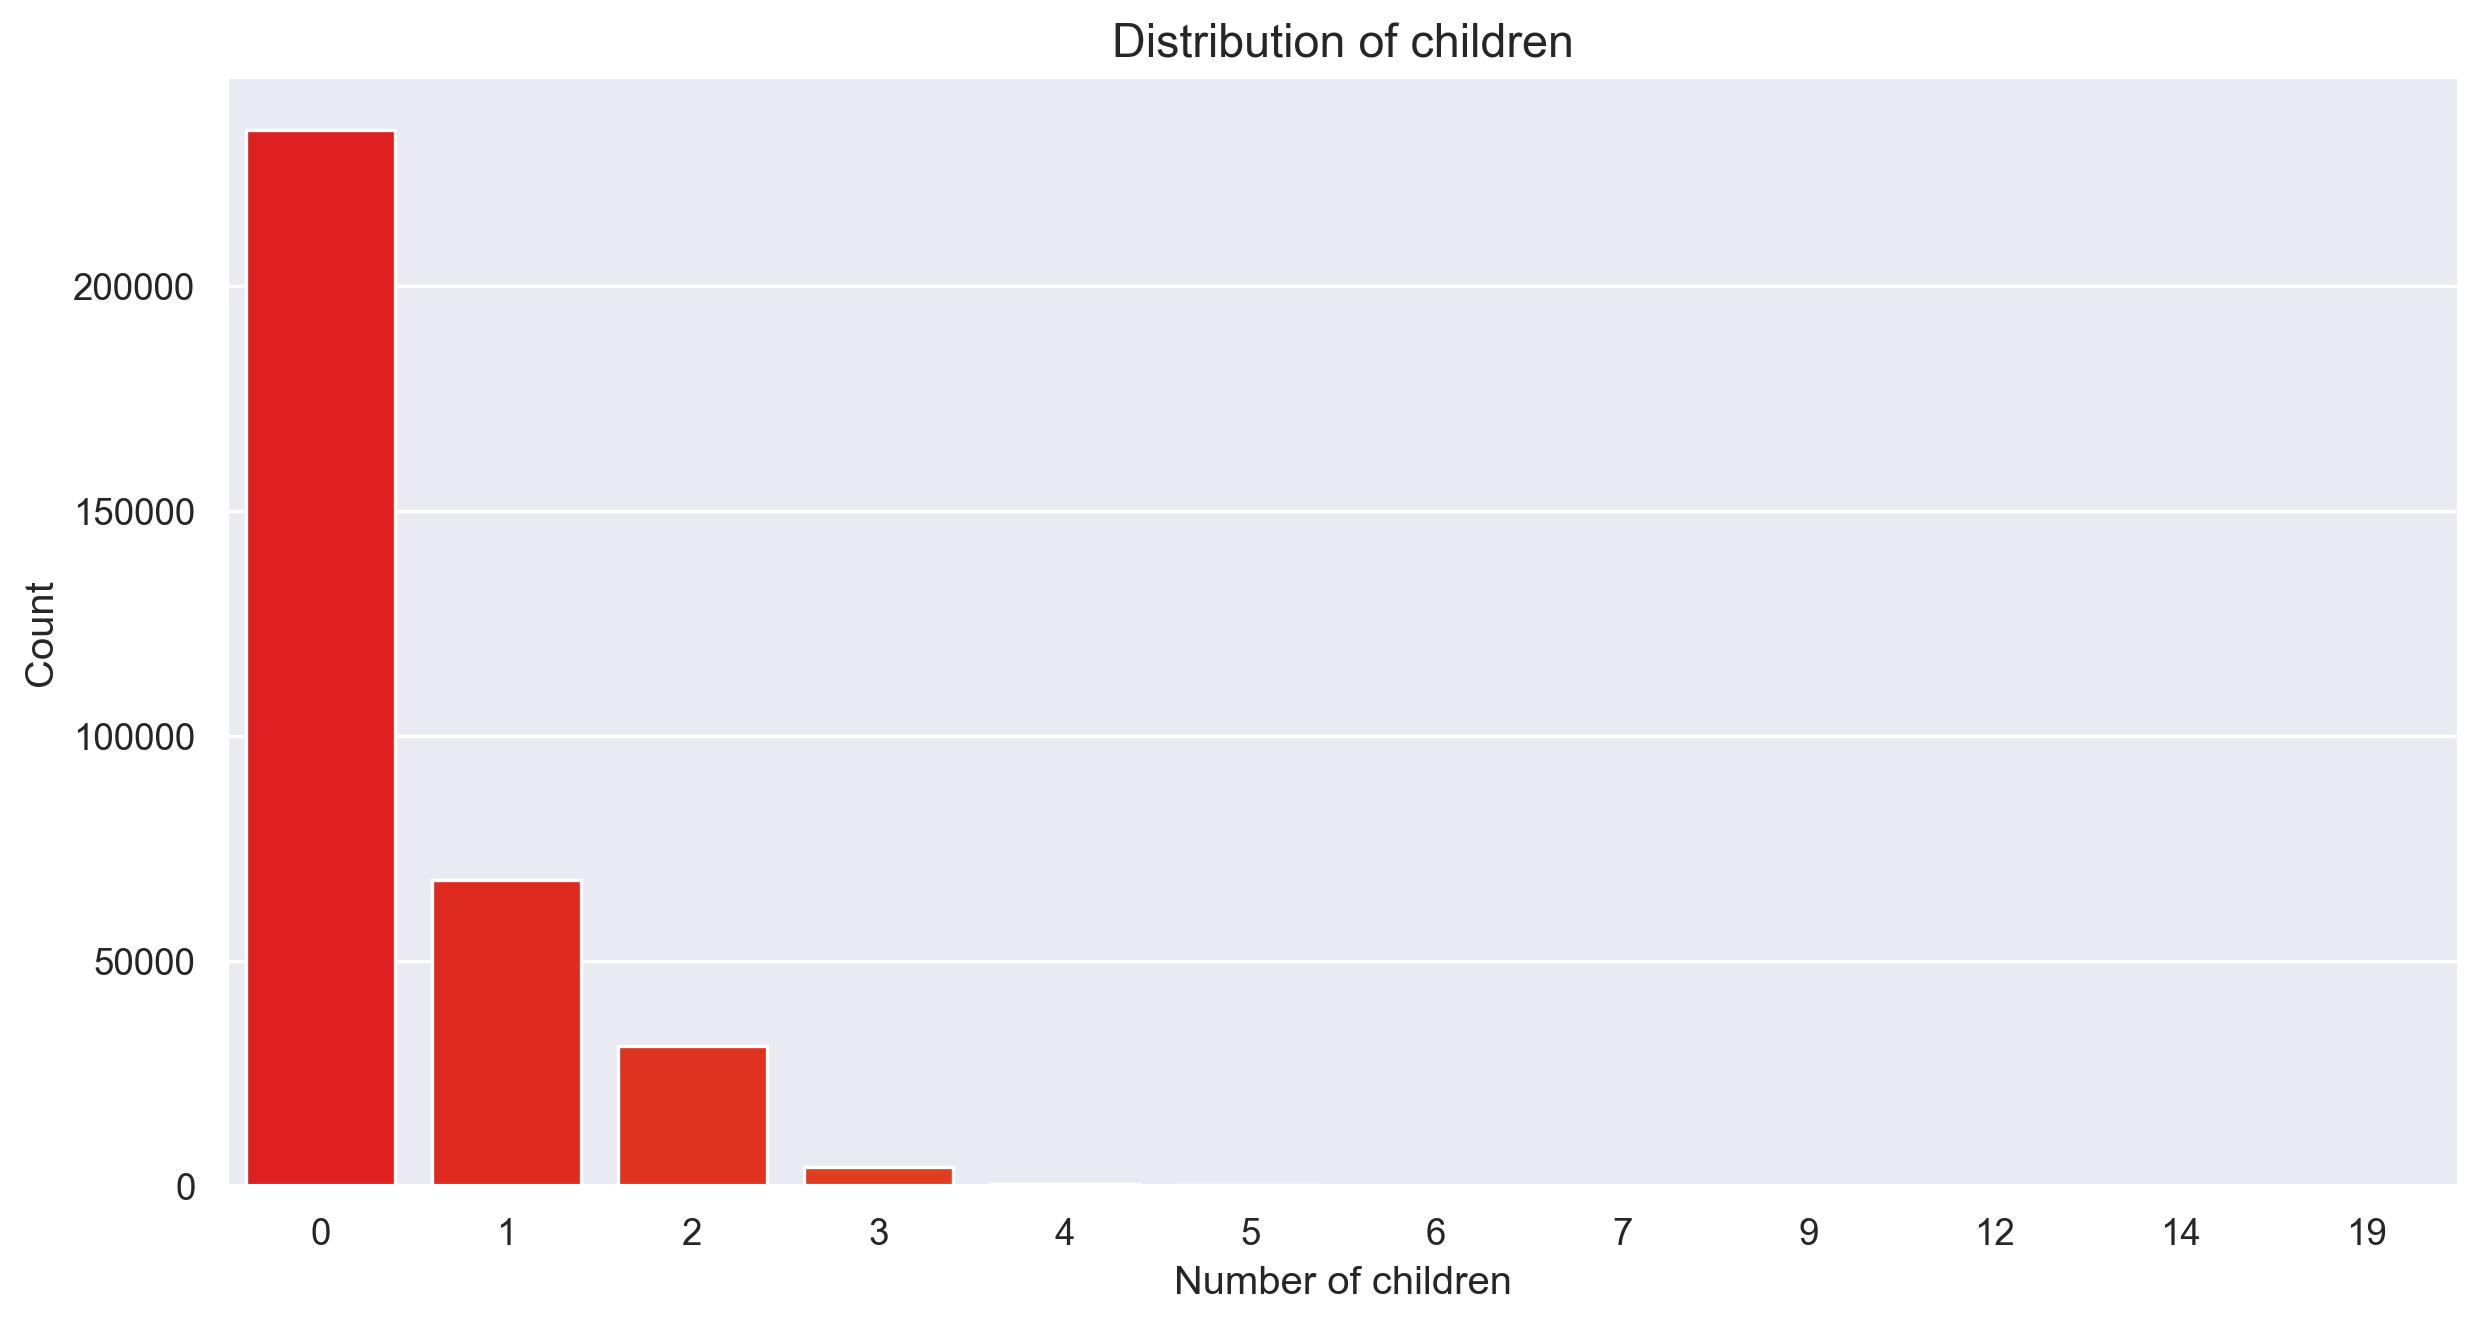

In [86]:
plt.figure(figsize=(12, 6))

# Distribution of children for all clients
sns.countplot(x="CNT_CHILDREN", hue="CNT_CHILDREN", data=df, palette='autumn', legend=False)
plt.title(f'Distribution of children', fontsize=14)
plt.xlabel("Number of children", fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [87]:
# Convert CNT_CHILDREN to string type
df = df.astype({'CNT_CHILDREN':str})

# Group children counts: 0, 1, 2, 3+
df.loc[df["CNT_CHILDREN"].isin([str(x) for x in range(3,20)]), "CNT_CHILDREN"] = "3+"

# New value counts for CNT_CHILDREN
print(df["CNT_CHILDREN"].value_counts().sort_index())

CNT_CHILDREN
0     234630
1      67922
2      31117
3+      4757
Name: count, dtype: int64


The CNT_FAM_MEMBERS feature indicates the number of clients' family members and can be considered similar to the CNT_CHILDREN feature.

In [88]:
# Convert CNT_FAM_MEMBERS to integers
df = df.astype({'CNT_FAM_MEMBERS': int})

print(df["CNT_FAM_MEMBERS"].value_counts().sort_index())

CNT_FAM_MEMBERS
1      64896
2     180706
3      59148
4      29236
5       3955
6        356
7        111
8          4
9          2
11         4
14         4
15         3
20         1
Name: count, dtype: int64


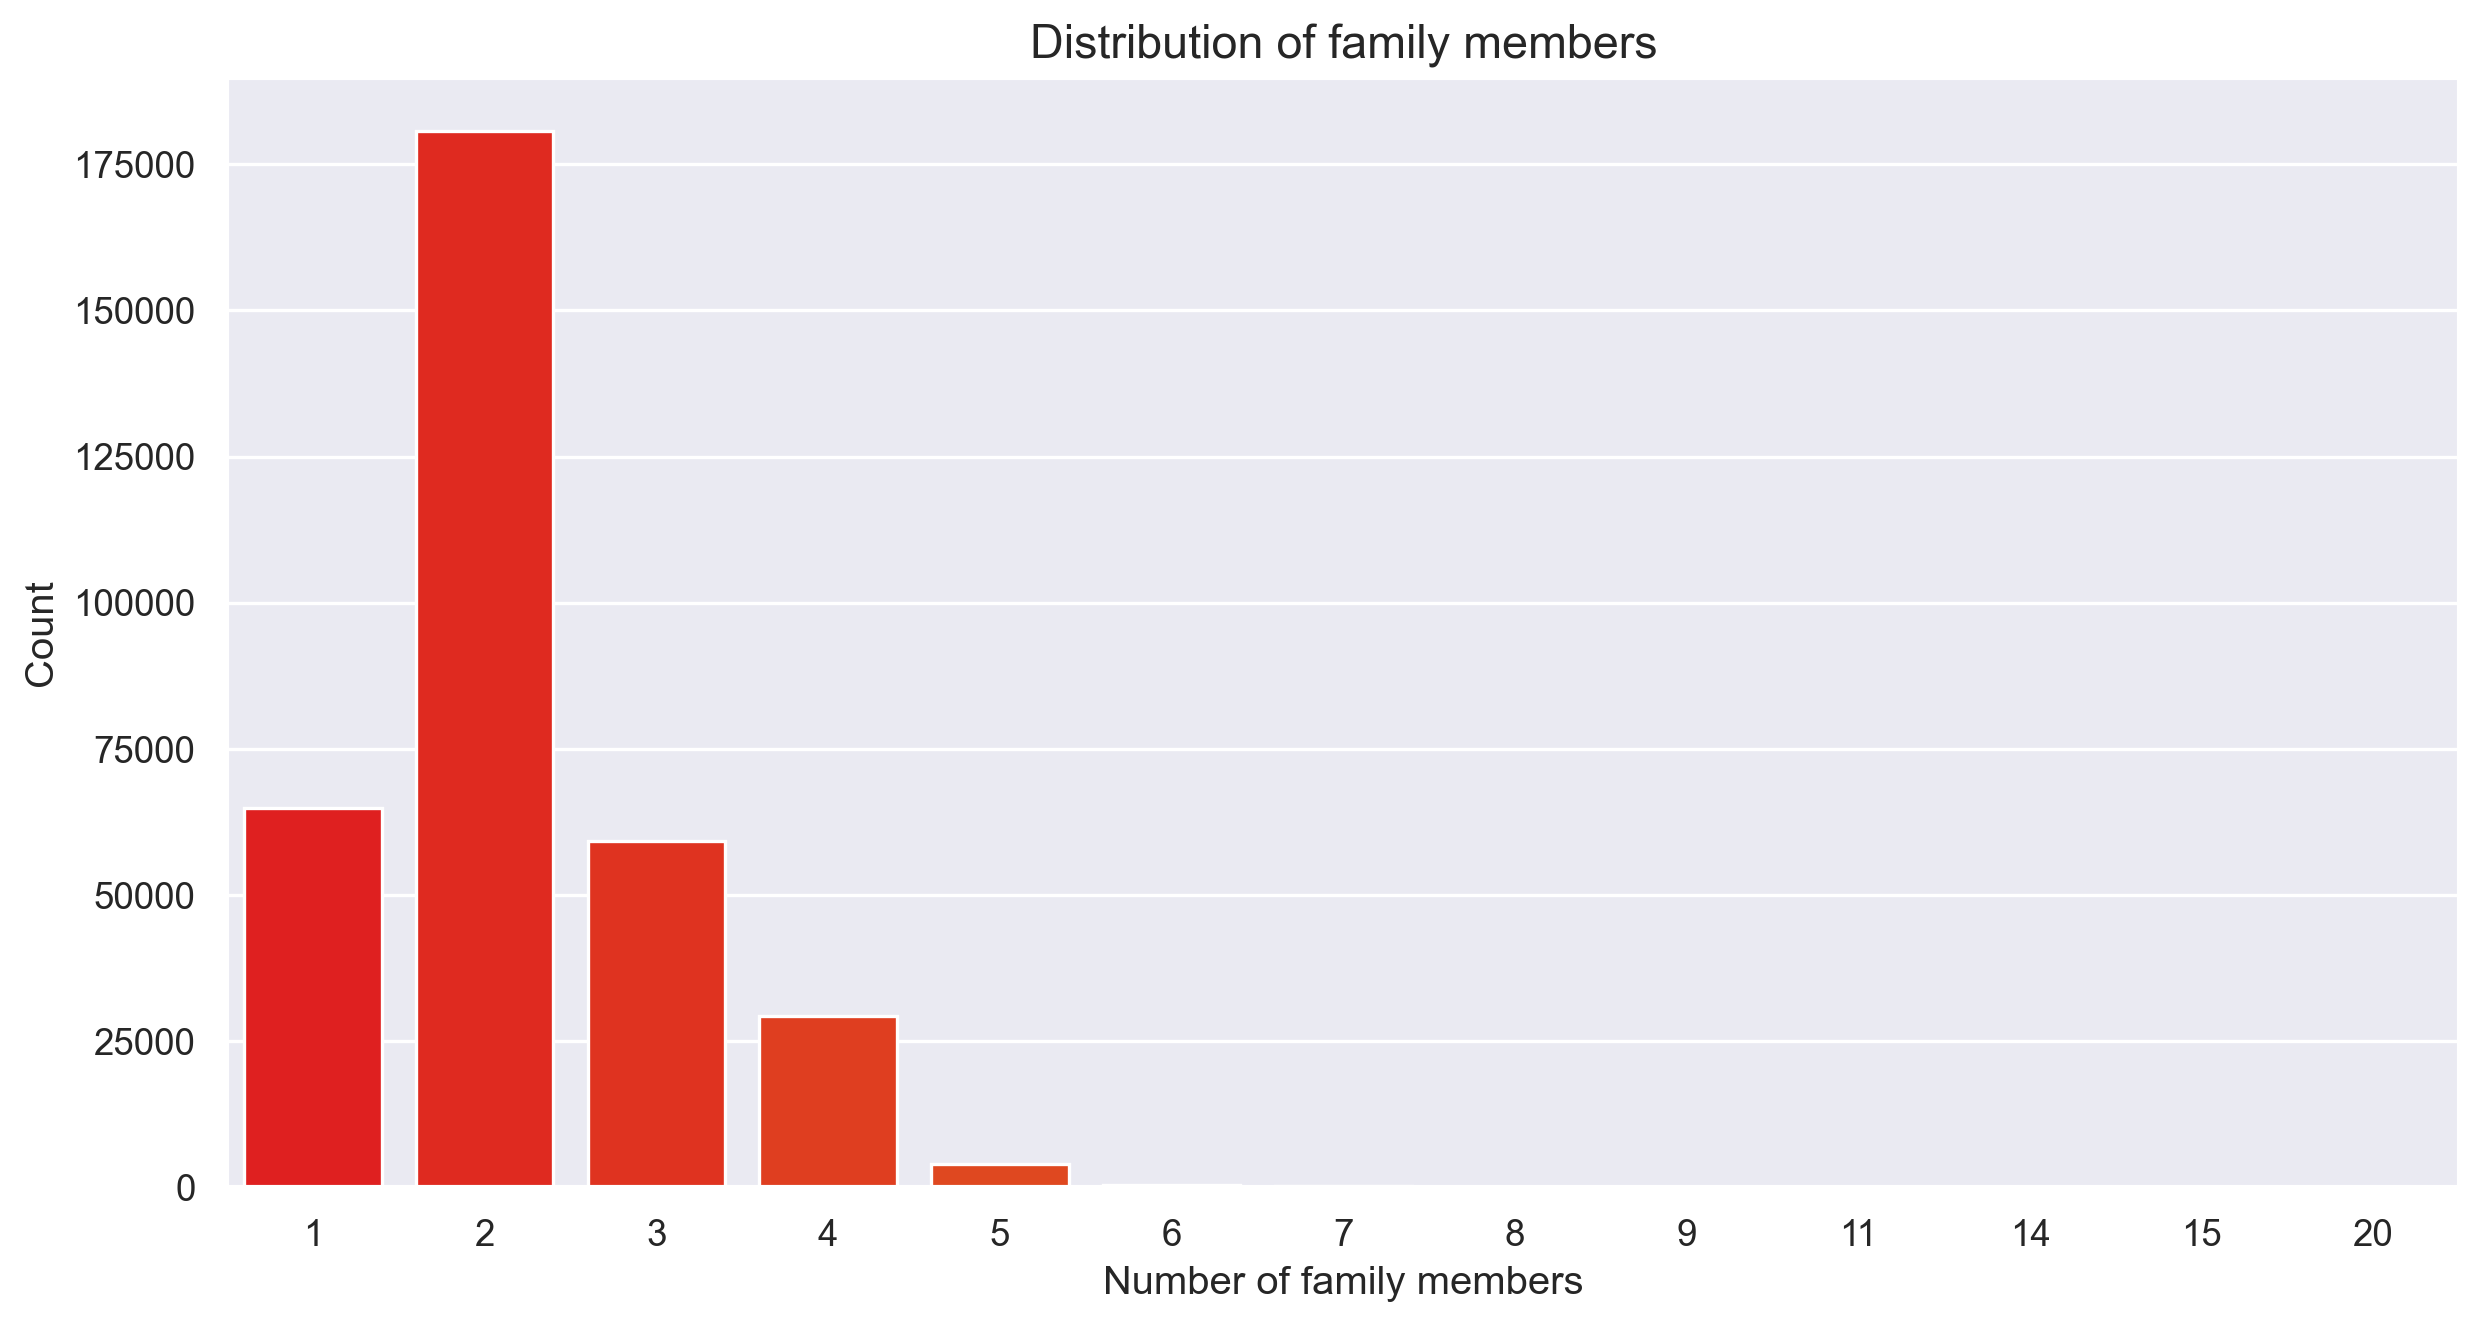

In [89]:
plt.figure(figsize=(12, 6))

# Distribution of family members for all clients
sns.countplot(x="CNT_FAM_MEMBERS", hue="CNT_FAM_MEMBERS", data=df, palette='autumn', legend=False)
plt.title(f'Distribution of family members', fontsize=14)
plt.xlabel("Number of family members", fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

In [90]:
# Convert CNT_FAM_MEMBERS to string type
df = df.astype({'CNT_FAM_MEMBERS': str})

# Group family members counts: 1, 2, 3, 4, 5+
df.loc[df["CNT_FAM_MEMBERS"].isin([str(x) for x in range(5,21)]), "CNT_FAM_MEMBERS"] = "5+"

# New value counts for CNT_FAM_MEMBERS
print(df["CNT_FAM_MEMBERS"].value_counts().sort_index())

CNT_FAM_MEMBERS
1      64896
2     180706
3      59148
4      29236
5+      4440
Name: count, dtype: int64


Lastly, it is checked if the dataset contains some duplicated samples.

In [91]:
# Check if duplicated rows are present in the dataframe
duplicates = df[df.duplicated()]
print(f"{len(duplicates)} duplicated rows found")

0 duplicated rows found


### Analysis of the target variable

Here, after the preprocessing phase, the distribution of the TARGET variable is analysed, to identify possible imbalances in samples (clients' credit standing).

In [92]:
target_count = df['TARGET'].value_counts()
target_percentage = df['TARGET'].value_counts(normalize=True) * 100

print("Distribution of the target variable (credit standing):")
print(f"  0 (Low): {target_count[0]} clients ({target_percentage[0]:.2f}%)")
print(f"  1 (High): {target_count[1]} clients ({target_percentage[1]:.2f}%)")

Distribution of the target variable (credit standing):
  0 (Low): 308704 clients (91.22%)
  1 (High): 29722 clients (8.78%)


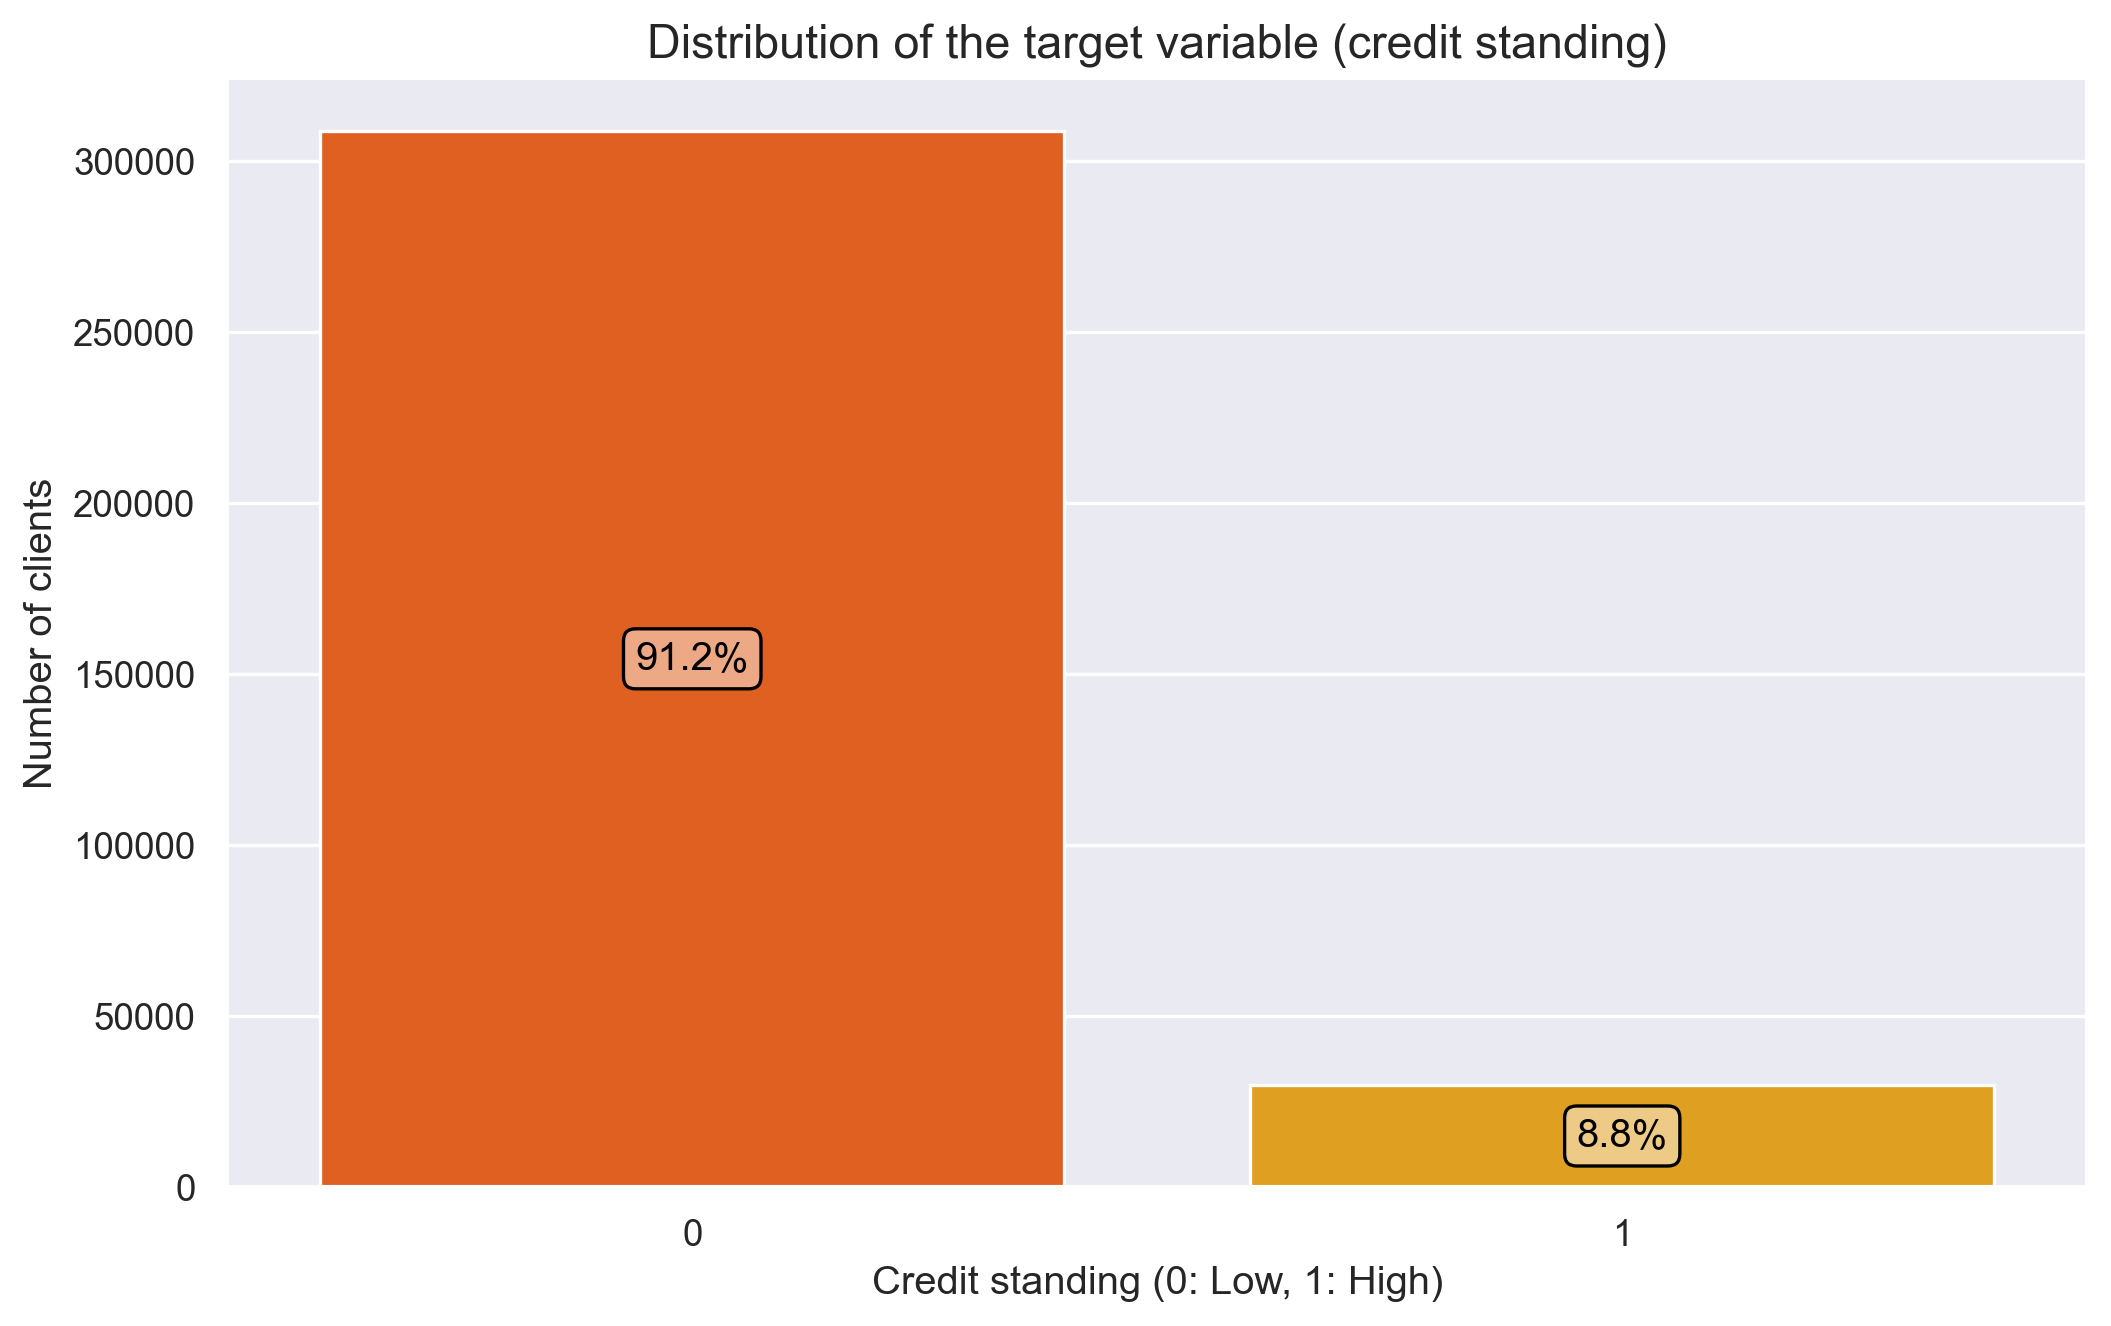

In [93]:
# Count plot of the target variable
plt.figure(figsize=(10, 6))
sns.countplot(x='TARGET', data=df, hue="TARGET", palette='autumn', legend=False)
plt.title('Distribution of the target variable (credit standing)', fontsize=14)
plt.xlabel('Credit standing (0: Low, 1: High)', fontsize=12)
plt.ylabel('Number of clients', fontsize=12)

for i, count in enumerate(target_count):
    plt.annotate(f"{target_percentage[i]:.1f}%", 
                 xy=(i, target_count[i]/2), 
                 ha='center', va='center', 
                 fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.show()

The distribution of the TARGET variable resulted strongly inbalanced, with 91.2% of clients having a low credit standing.

### Exploration of categorical variables

Here, the categorical variable are analysed, to have an overview of the distribution of samples among the different classes.

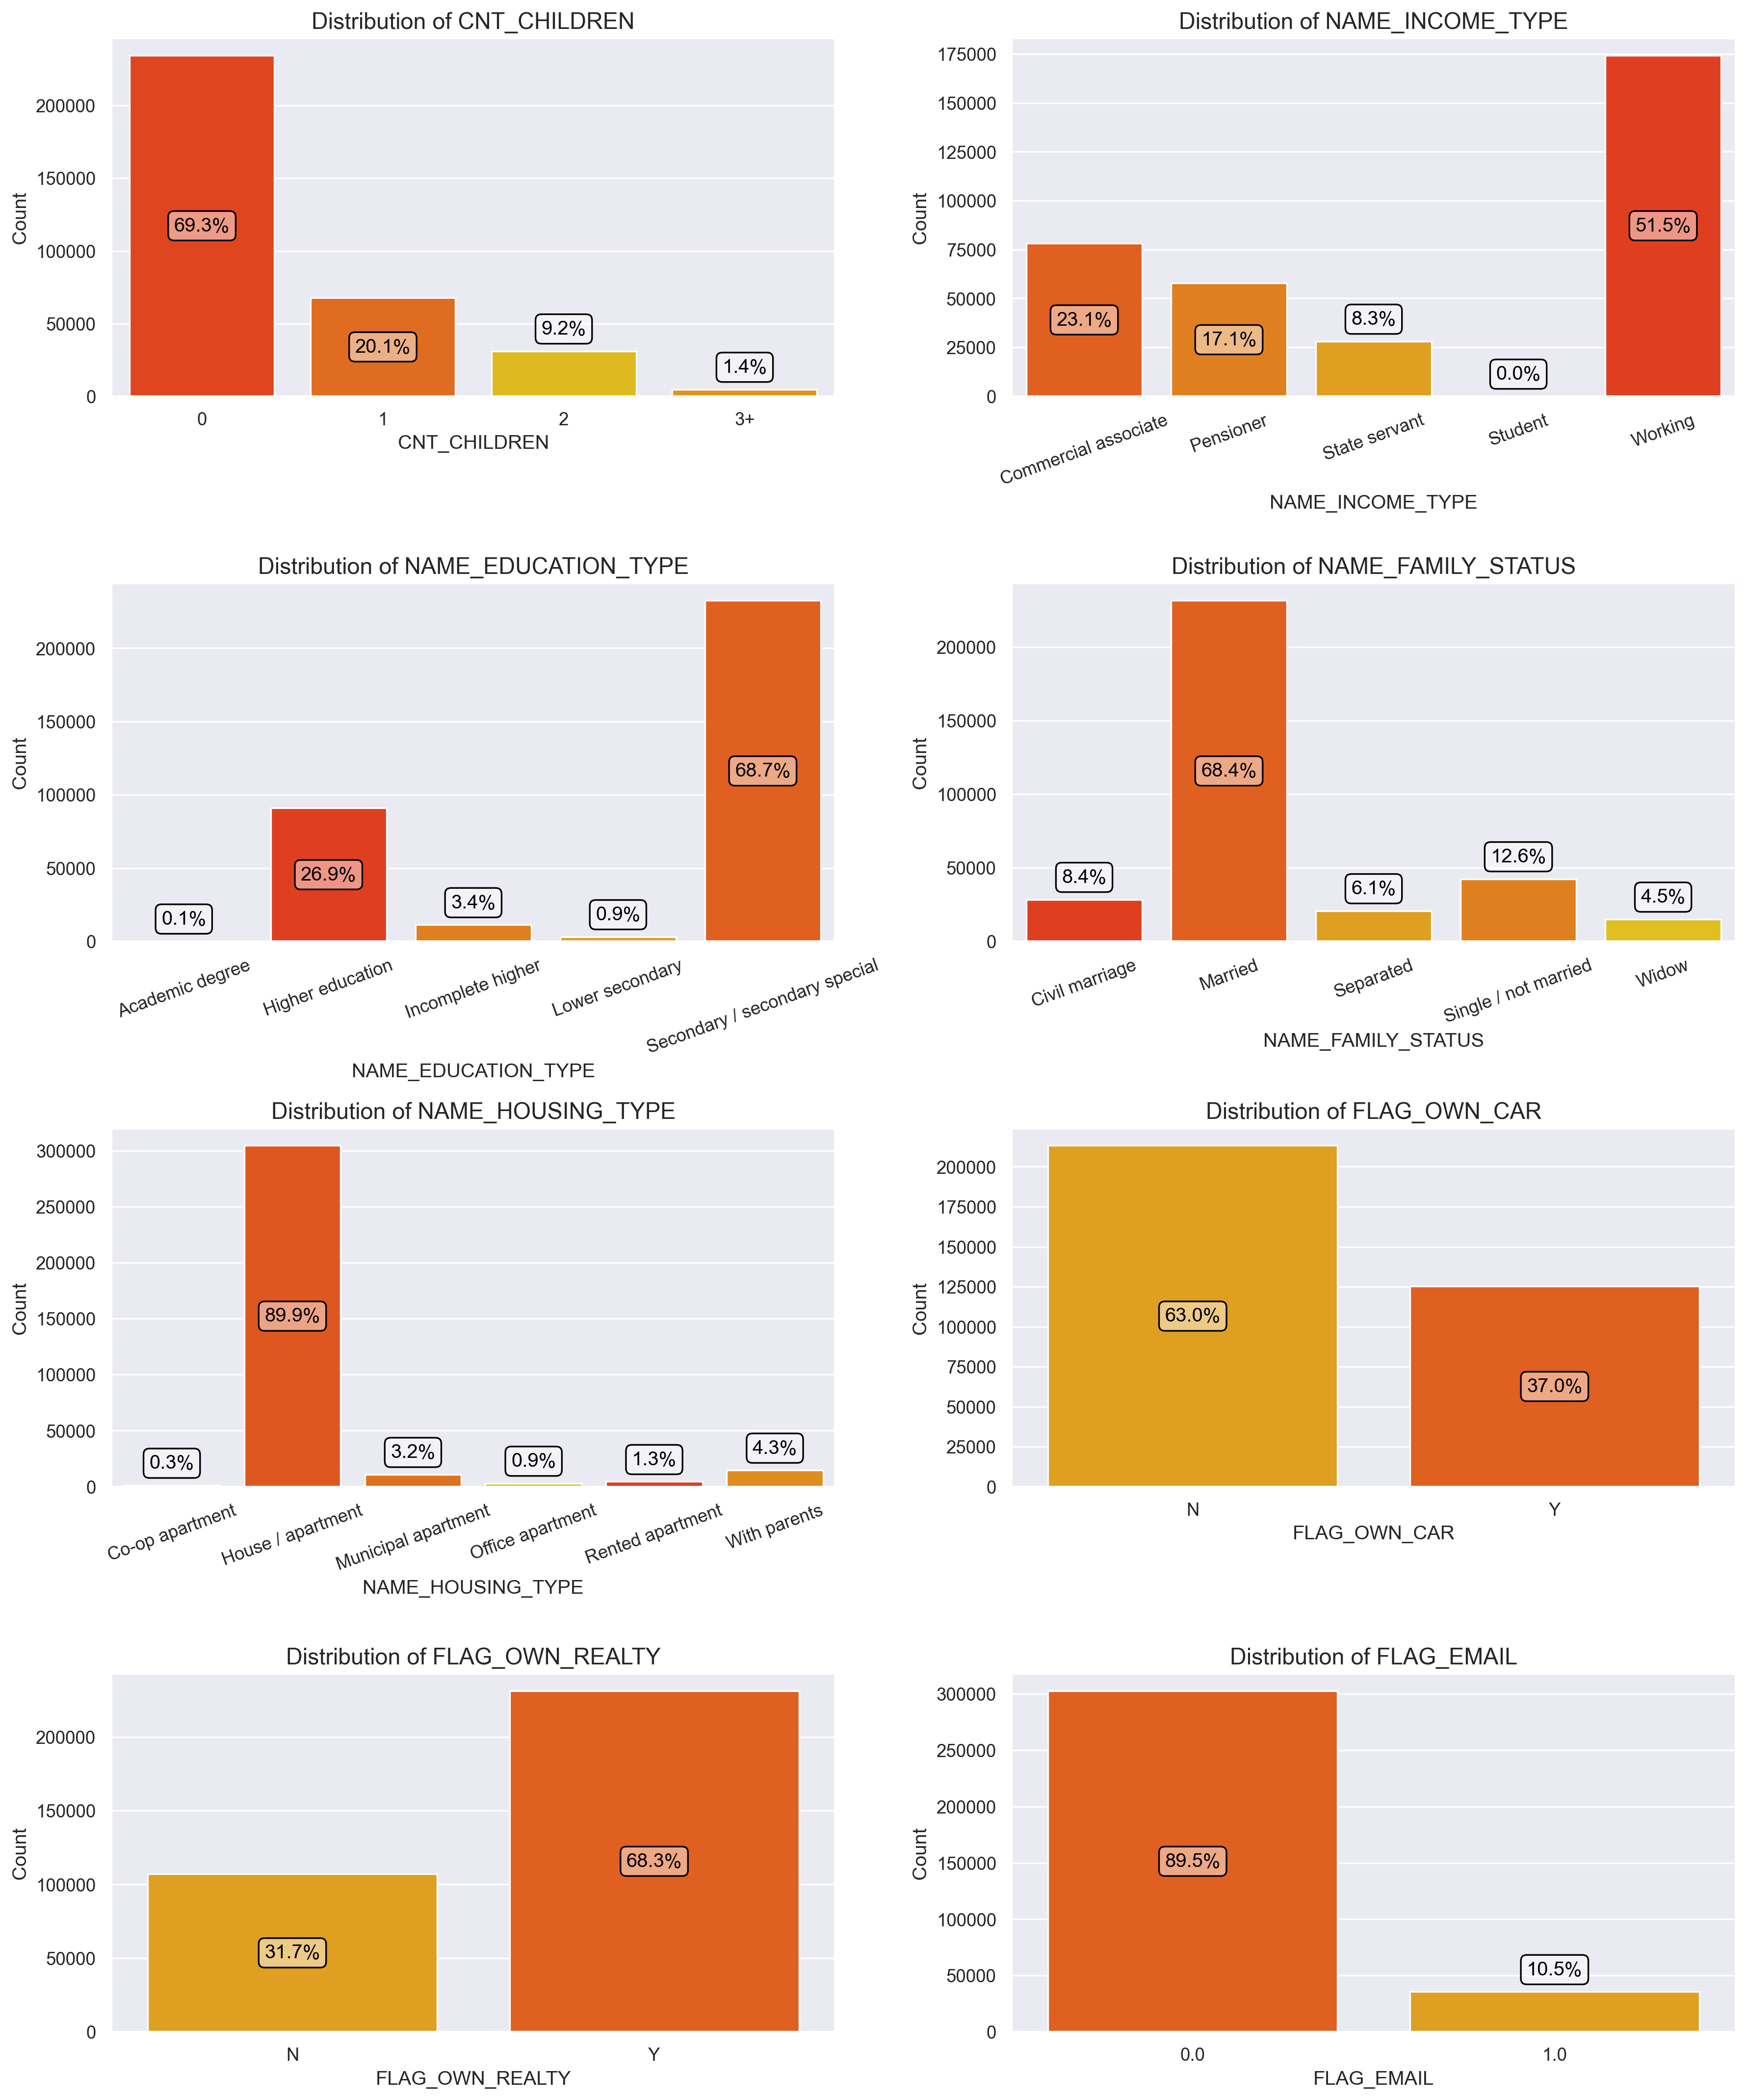

In [94]:
cat_columns = ['CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_EMAIL']

# Count plots of the categorial variables

plt.figure(figsize=(15, 18))

for i, column in enumerate(cat_columns):
       
    # Counts and percentages for each category
    counts = df[column].value_counts().sort_index()
    percentages = df[column].value_counts(normalize=True).sort_index() * 100
    
    # Plots of general distribution
    plt.subplot(4, 2, i+1)
    ax = sns.countplot(x=column, hue=column, data=df, order=df[column].value_counts().sort_index().index, palette='autumn', legend=False)
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    if len(counts)>4:
        plt.xticks(rotation=20)

    for j, (value, count) in enumerate(counts.items()):

        y_pos = counts.iloc[j]/2 if counts.iloc[j]/2 > np.amax(counts)*.1 else counts.iloc[j]
        y_offset = 0 if counts.iloc[j]/2 > np.amax(counts)*.1 else 45
        ax.annotate(f"{percentages.iloc[j]:.1f}%", 
                 xy=(j, y_pos), xytext=(0, y_offset), textcoords="offset pixels",
                 ha='center', va='center', 
                 fontsize=12, color='black',
                 bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))
    
plt.tight_layout()
plt.show()

### Exploration of numerical variables

Here, the numerical variables are analysed (excluding the DAYS_EMPLOYED feature, previously addressed) to have an overview of the income and age distribution.

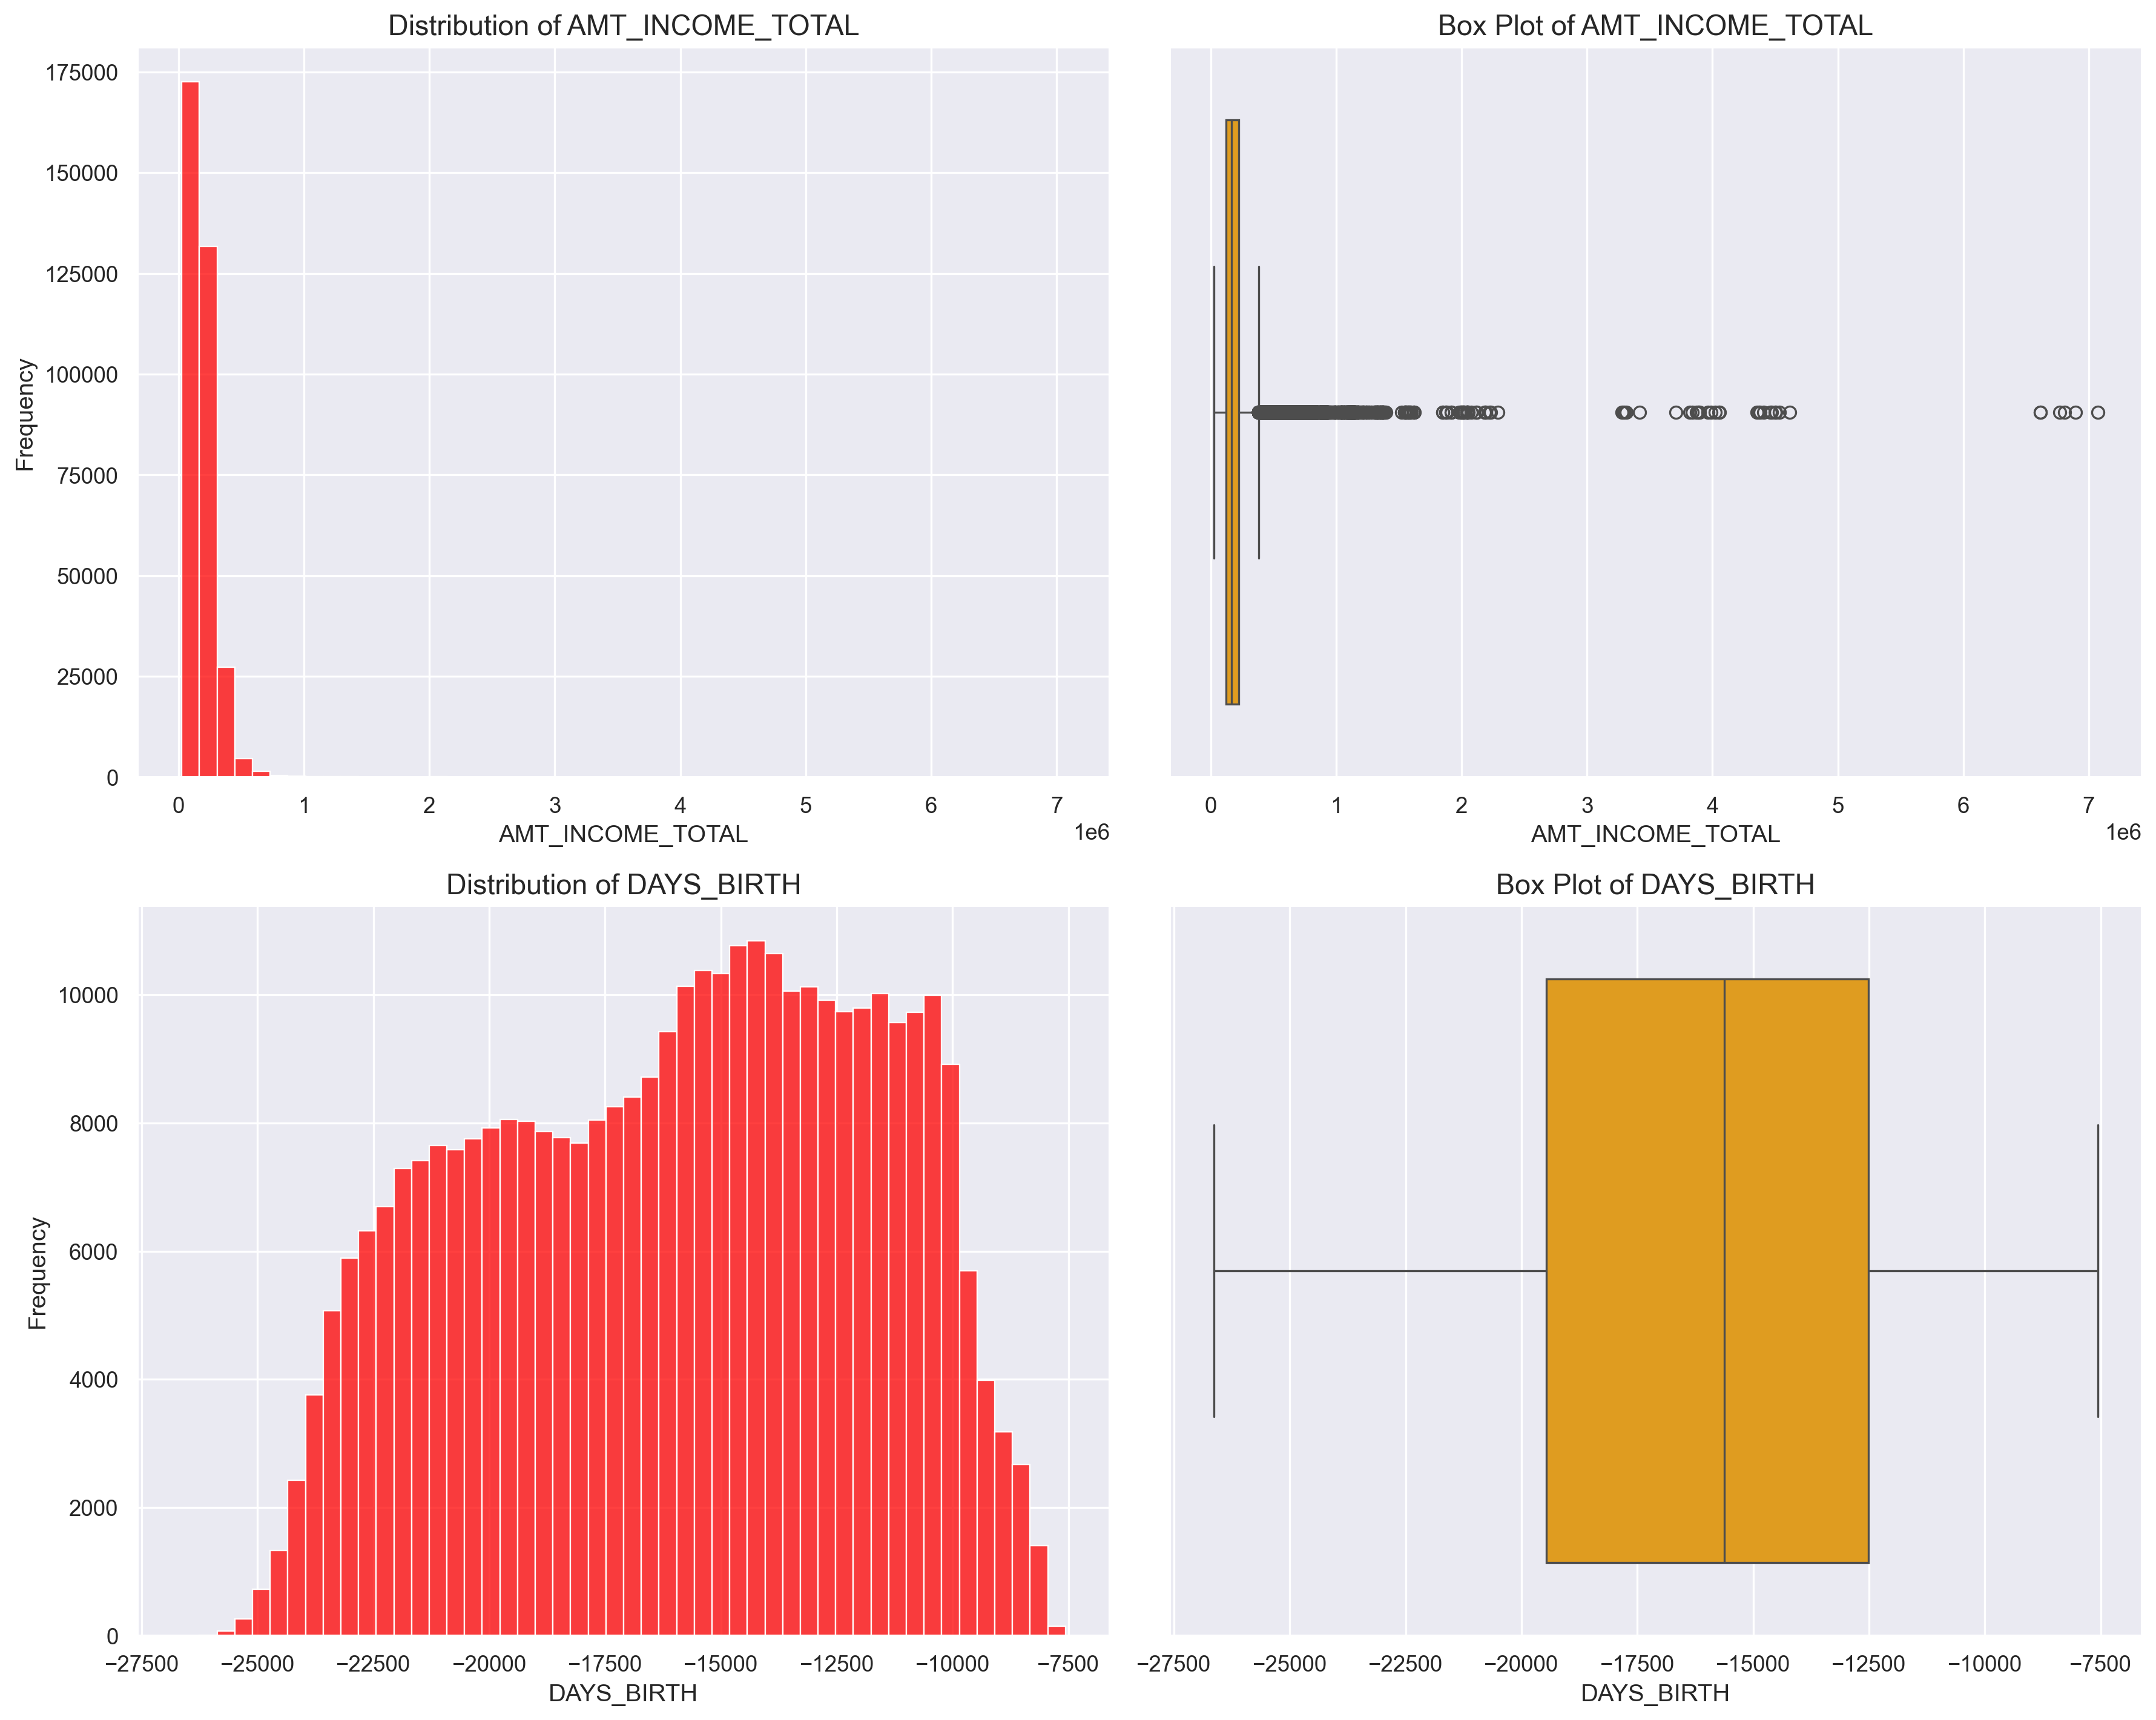

In [95]:
num_columns = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH']

# Plots of the numerical variables

plt.figure(figsize=(15, 12))

for i, column in enumerate(num_columns):
    
    # Distributions
    plt.subplot(2, 2, (2*i)+1)
    sns.histplot(df[column], bins=50, kde=False, color='red')
    plt.title(f'Distribution of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    # Box plots
    plt.subplot(2, 2, (2*i)+2)
    sns.boxplot(x=df[column], color='orange')
    plt.title(f'Box Plot of {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    
plt.tight_layout()
plt.show()

### Focus on key variables

Here, the relation between some key variables (NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, FLAG_OWN_REALTY, AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED) and the TARGET variable is analysed.

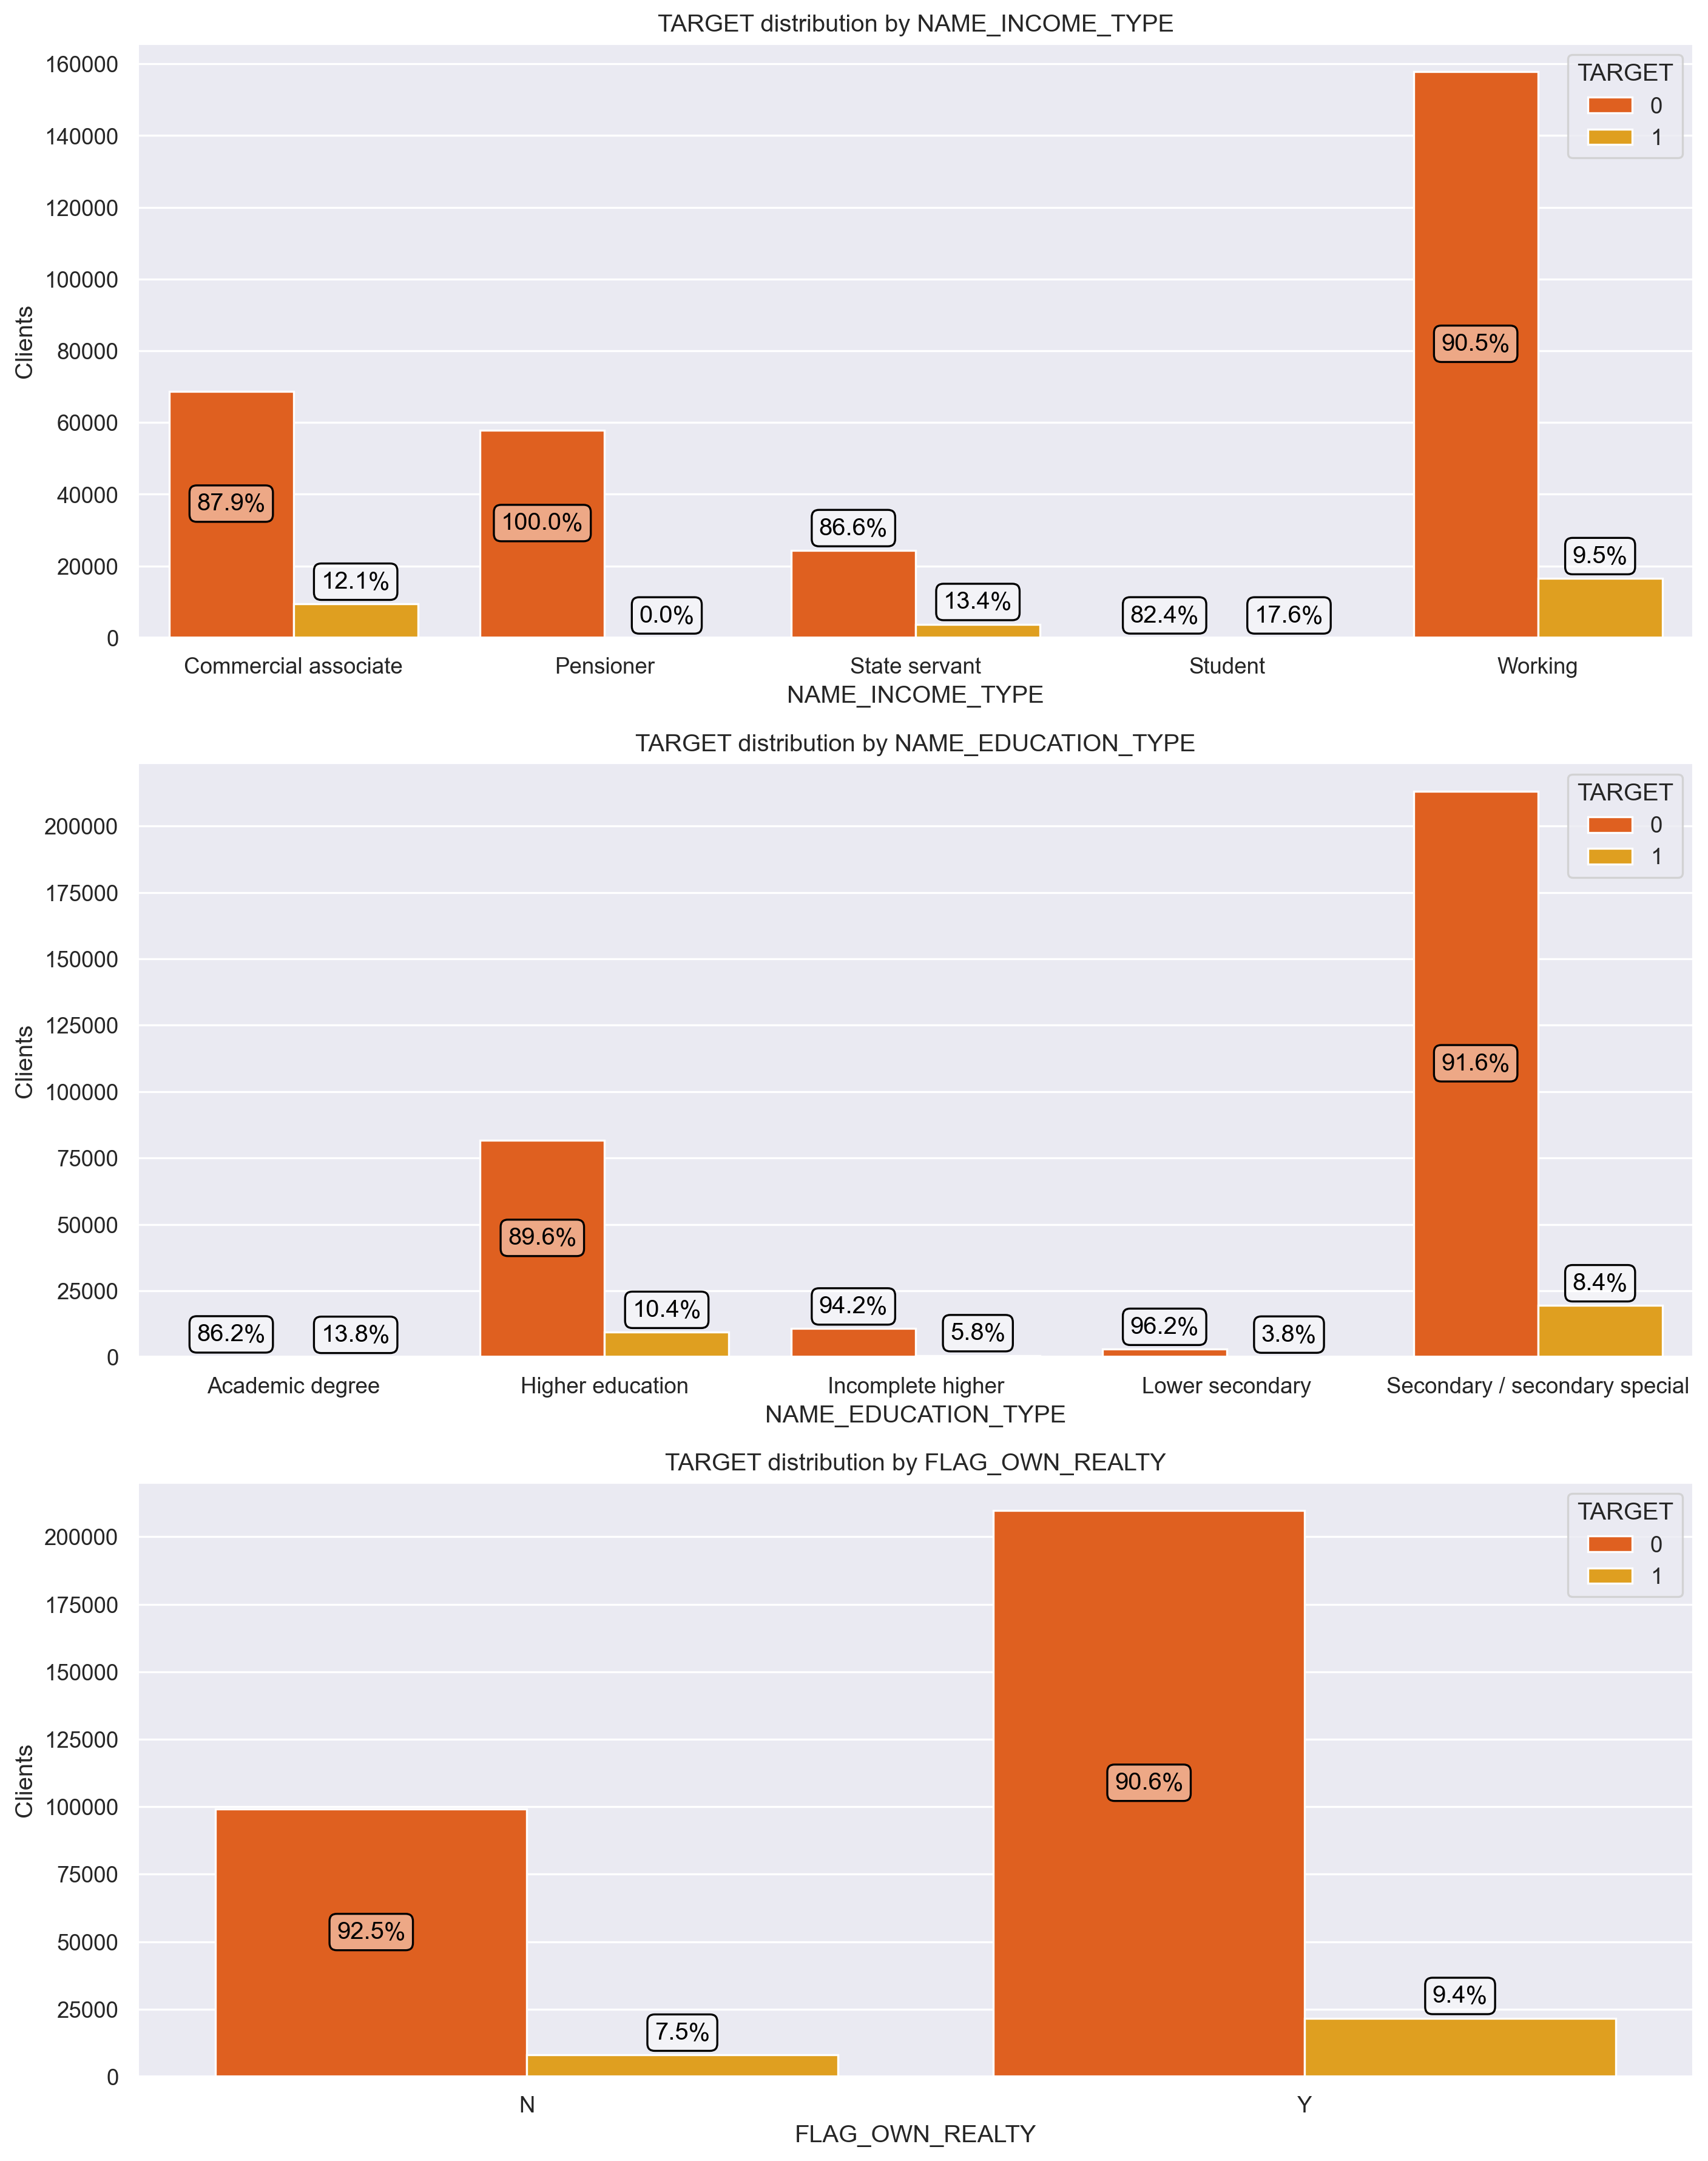

In [96]:
# Bar plots of NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, FLAG_OWN_REALTY by TARGET

features = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_REALTY']

plt.figure(figsize=(12, 15))

for n, feature in enumerate(features):

    feature_target_freq = pd.crosstab(df[feature], df['TARGET'])
    feature_target_perc = pd.crosstab(df[feature], df['TARGET'], normalize='index') * 100

    feature_target_freq_long = pd.melt(feature_target_freq.reset_index(), id_vars=feature, value_vars=feature_target_freq.columns)
    
    plt.subplot(len(features), 1, n+1)
    ax = sns.barplot(feature_target_freq_long, x=feature, y="value", hue="TARGET", palette="autumn")

    bar_max = feature_target_freq.values.max()

    for i, target in enumerate(feature_target_freq.columns):
        for j, feature_class in enumerate(feature_target_freq.index):

            bar = ax.patches[(feature_target_freq.shape[0]*i)+j]
            pct = feature_target_perc.iloc[j, i]

            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height()/2 if bar.get_height()/2 > bar_max*.1 else bar.get_height() + 0.02 * bar_max,
                f"{pct:.1f}%",
                ha="center", va="bottom",
                fontsize=12, color="black",
                bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

    ax.set_xlabel(feature)
    ax.set_ylabel("Clients")
    ax.set_title(f"TARGET distribution by {feature}")
    ax.legend(title="TARGET")
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

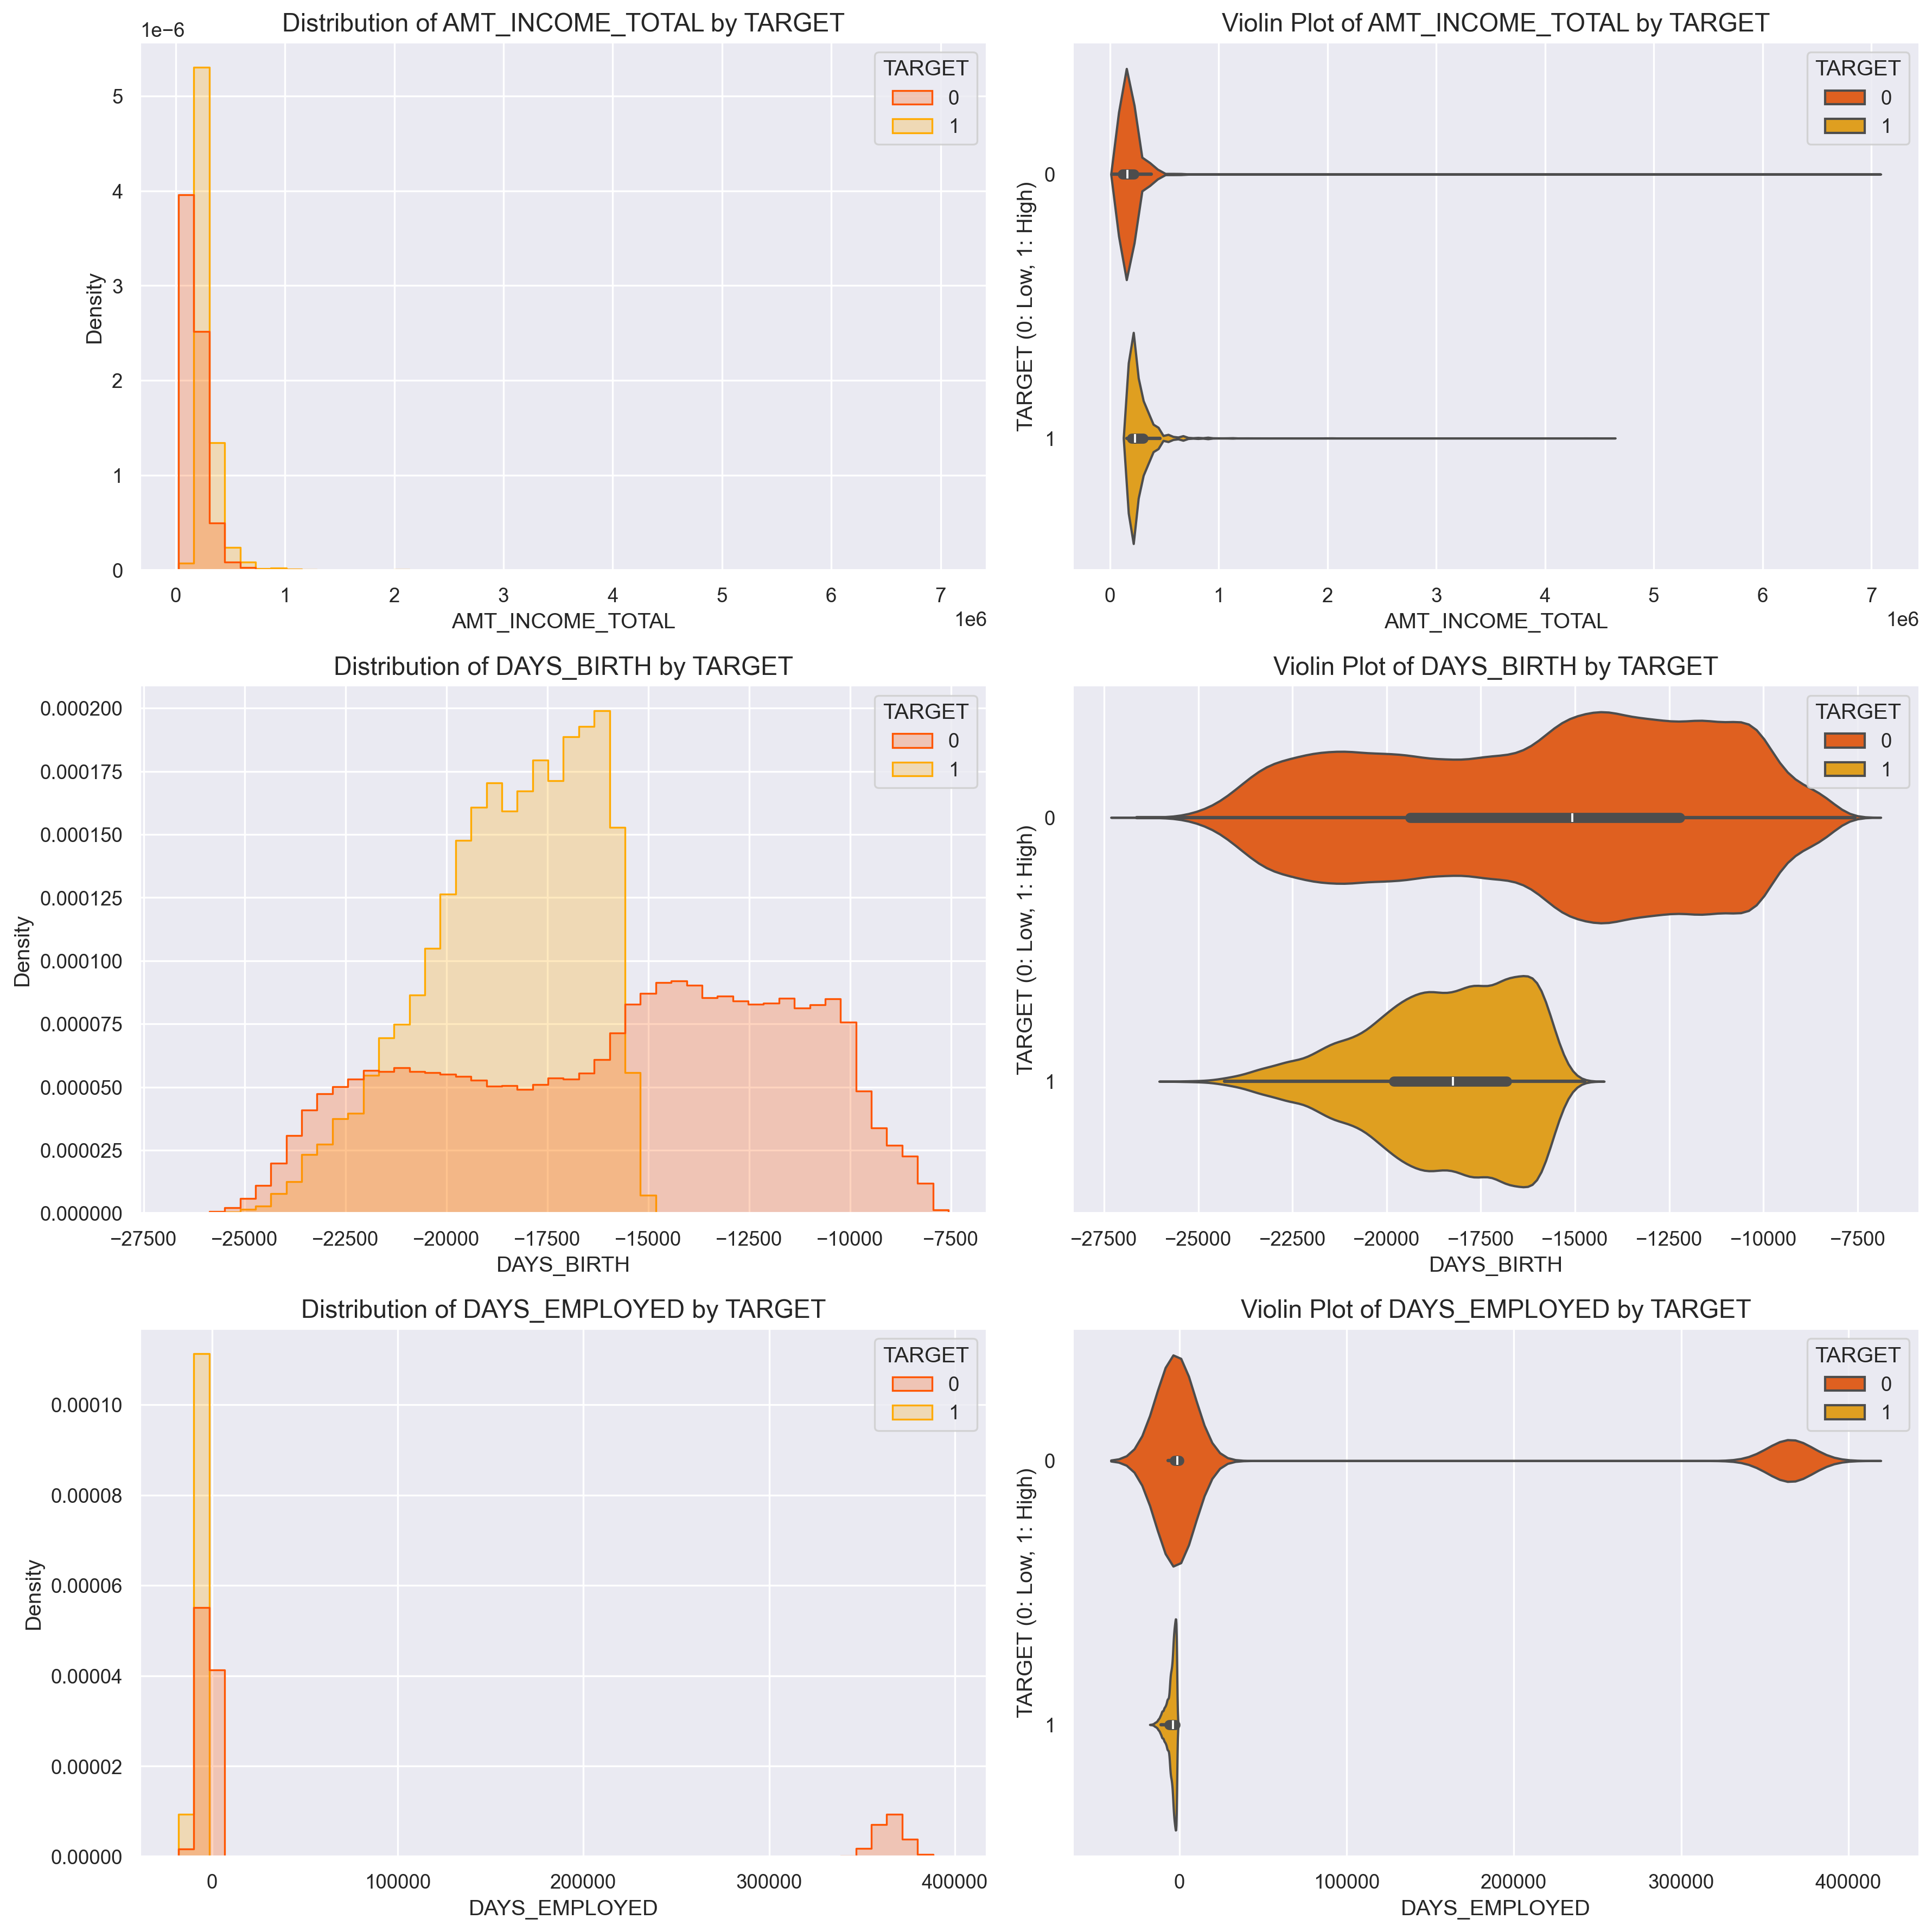

In [97]:
# Histplots e violin plots of AMT_INCOME_TOTAL, DAYS_BIRTH, DAYS_EMPLOYED by TARGET

features = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

plt.figure(figsize=(15, 15))

for n, feature in enumerate(features):

    # Density of Age by Response
    plt.subplot(3, 2, (2*n)+1)
    sns.histplot(data=df, x=feature, hue='TARGET', element='step', 
                 stat='density', common_norm=False, bins=50, palette='autumn')
    plt.title(f'Distribution of {feature} by TARGET', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Violin plot of Age by Response
    plt.subplot(3, 2, (2*n)+2)
    sns.violinplot(data=df, x=feature, y='TARGET', orient="y", 
                   hue="TARGET", palette='autumn')
    plt.title(f'Violin Plot of {feature} by TARGET', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('TARGET (0: Low, 1: High)', fontsize=12)

plt.tight_layout()
plt.show()

From this exploratory analysis, the following observations can be made:

- The frequency of high credit standing is slightly lower in clients classified as "working" respect to clients classified as "commercial associate" and "state servant"
- The frequency of high credit standing is slightly higher in clients with higher education and academic degree respect to clients with secondary and lower secondary education
- The frequency of high credit standing is slightly higher in clients owning a house
- The frequency of high credit standing is higher in clients with higher annual income
- The frequency of high credit standing is higher in clients with age between 40 and 65

### Correlation matrix

Here, a pairwise correlation of variables in the dataset is calculated and visualized. Only numerical, binary categorical and ordinal multi-categorical variables will be considered. The Spearman correlation will be used, as it makes no assumptions about data distribution and it is more suited to handle ordinal data.

In [98]:
# Print all categorical variables and categories

obj_columns = df.select_dtypes(include=[object]).columns

for column in obj_columns:
    print(column)
    print(f"Categories: {df[column].unique()}\n")

CODE_GENDER
Categories: ['M' 'F']

FLAG_OWN_CAR
Categories: ['Y' 'N']

FLAG_OWN_REALTY
Categories: ['Y' 'N']

CNT_CHILDREN
Categories: ['0' '1' '3+' '2']

NAME_INCOME_TYPE
Categories: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

NAME_EDUCATION_TYPE
Categories: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

NAME_FAMILY_STATUS
Categories: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

NAME_HOUSING_TYPE
Categories: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']

OCCUPATION_TYPE
Categories: ['Other working' 'Security staff' 'Sales staff' 'Unemployed' 'Accountants'
 'Laborers' 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Other state servant' 'Private service staff'
 'Other commercial associate' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/bar

In [99]:
# Encoding of binary and ordinal multi-categorical variable

df_corr = df.iloc[:,1:].copy()

df_corr["CODE_GENDER"] = df_corr["CODE_GENDER"].map({"M":0, "F":1})
df_corr["FLAG_OWN_CAR"] = df_corr["FLAG_OWN_CAR"].map({"N":0, "Y":1})
df_corr["FLAG_OWN_REALTY"] = df_corr["FLAG_OWN_REALTY"].map({"N":0, "Y":1})
df_corr["CNT_CHILDREN"] = df_corr["CNT_CHILDREN"].map({"0":0, "1":1, "2":2, "3+":3})
df_corr["NAME_EDUCATION_TYPE"] = df_corr["NAME_EDUCATION_TYPE"].map({"Lower secondary":0, "Secondary / secondary special":1, "Incomplete higher":2, "Higher education":3, "Academic degree":4})
df_corr["CNT_FAM_MEMBERS"] = df_corr["CNT_FAM_MEMBERS"].map({"1":0, "2":1, "3":2, "4":3, "5+":4})

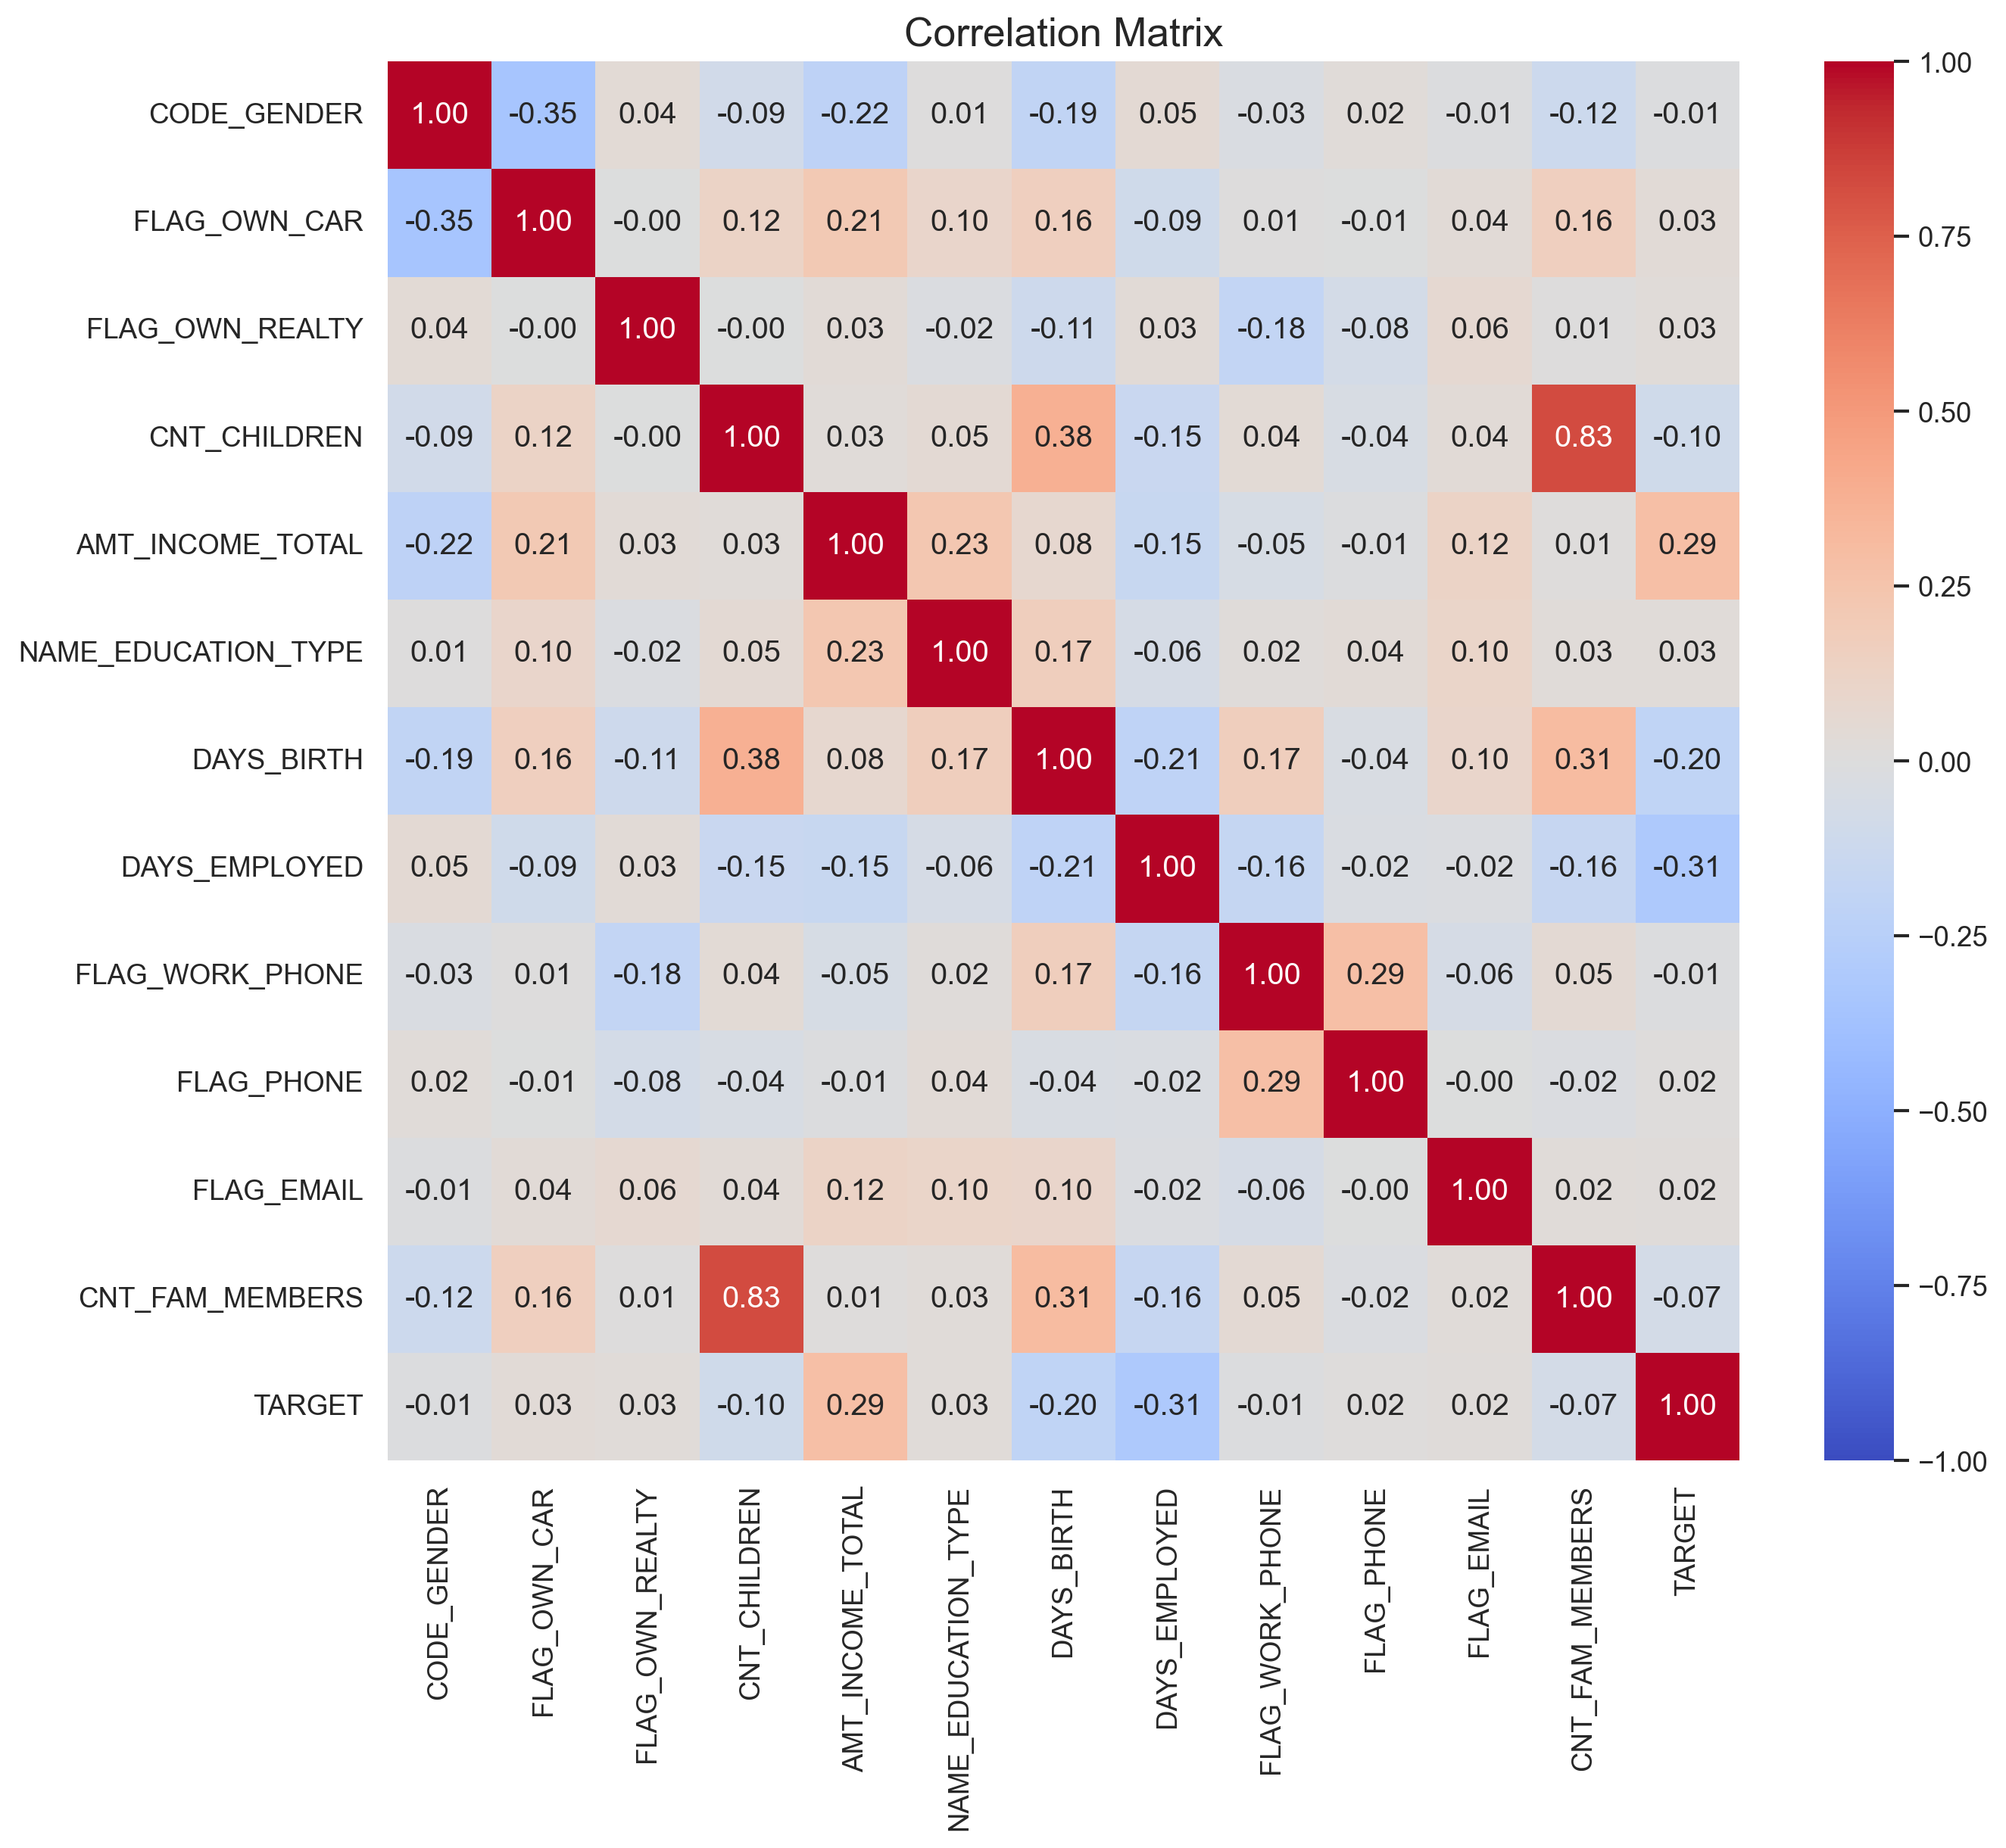

In [100]:
# Remove other non-ordinal categorical columns (and the FLAG_MOBIL variable as all samples have a cellphone number)

df_corr = df_corr.drop(columns=['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'FLAG_MOBIL'])


# Correlation matrix

corr_matrix = df_corr.corr(method='spearman')

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [101]:
print("Correlations with TARGET:")
print(corr_matrix['TARGET'].sort_values(ascending=False))

Correlations with TARGET:
TARGET                 1.000000
AMT_INCOME_TOTAL       0.286940
FLAG_OWN_CAR           0.034438
NAME_EDUCATION_TYPE    0.030440
FLAG_OWN_REALTY        0.030114
FLAG_EMAIL             0.021330
FLAG_PHONE             0.015558
FLAG_WORK_PHONE       -0.012826
CODE_GENDER           -0.014881
CNT_FAM_MEMBERS       -0.074911
CNT_CHILDREN          -0.095670
DAYS_BIRTH            -0.200676
DAYS_EMPLOYED         -0.312499
Name: TARGET, dtype: float64


### Other box plots by category

Based on correlation values obtained, here, some box plots are created, to visualize the relation between the two numerical variables AMT_INCOME_TOTAL (using a logarithmic scale for a better visualization) and DAYS_BIRTH, some informative categorical variables ('CODE_GENDER', 'NAME_EDUCATION_TYPE', 'CNT_CHILDREN') and the TARGET variable.

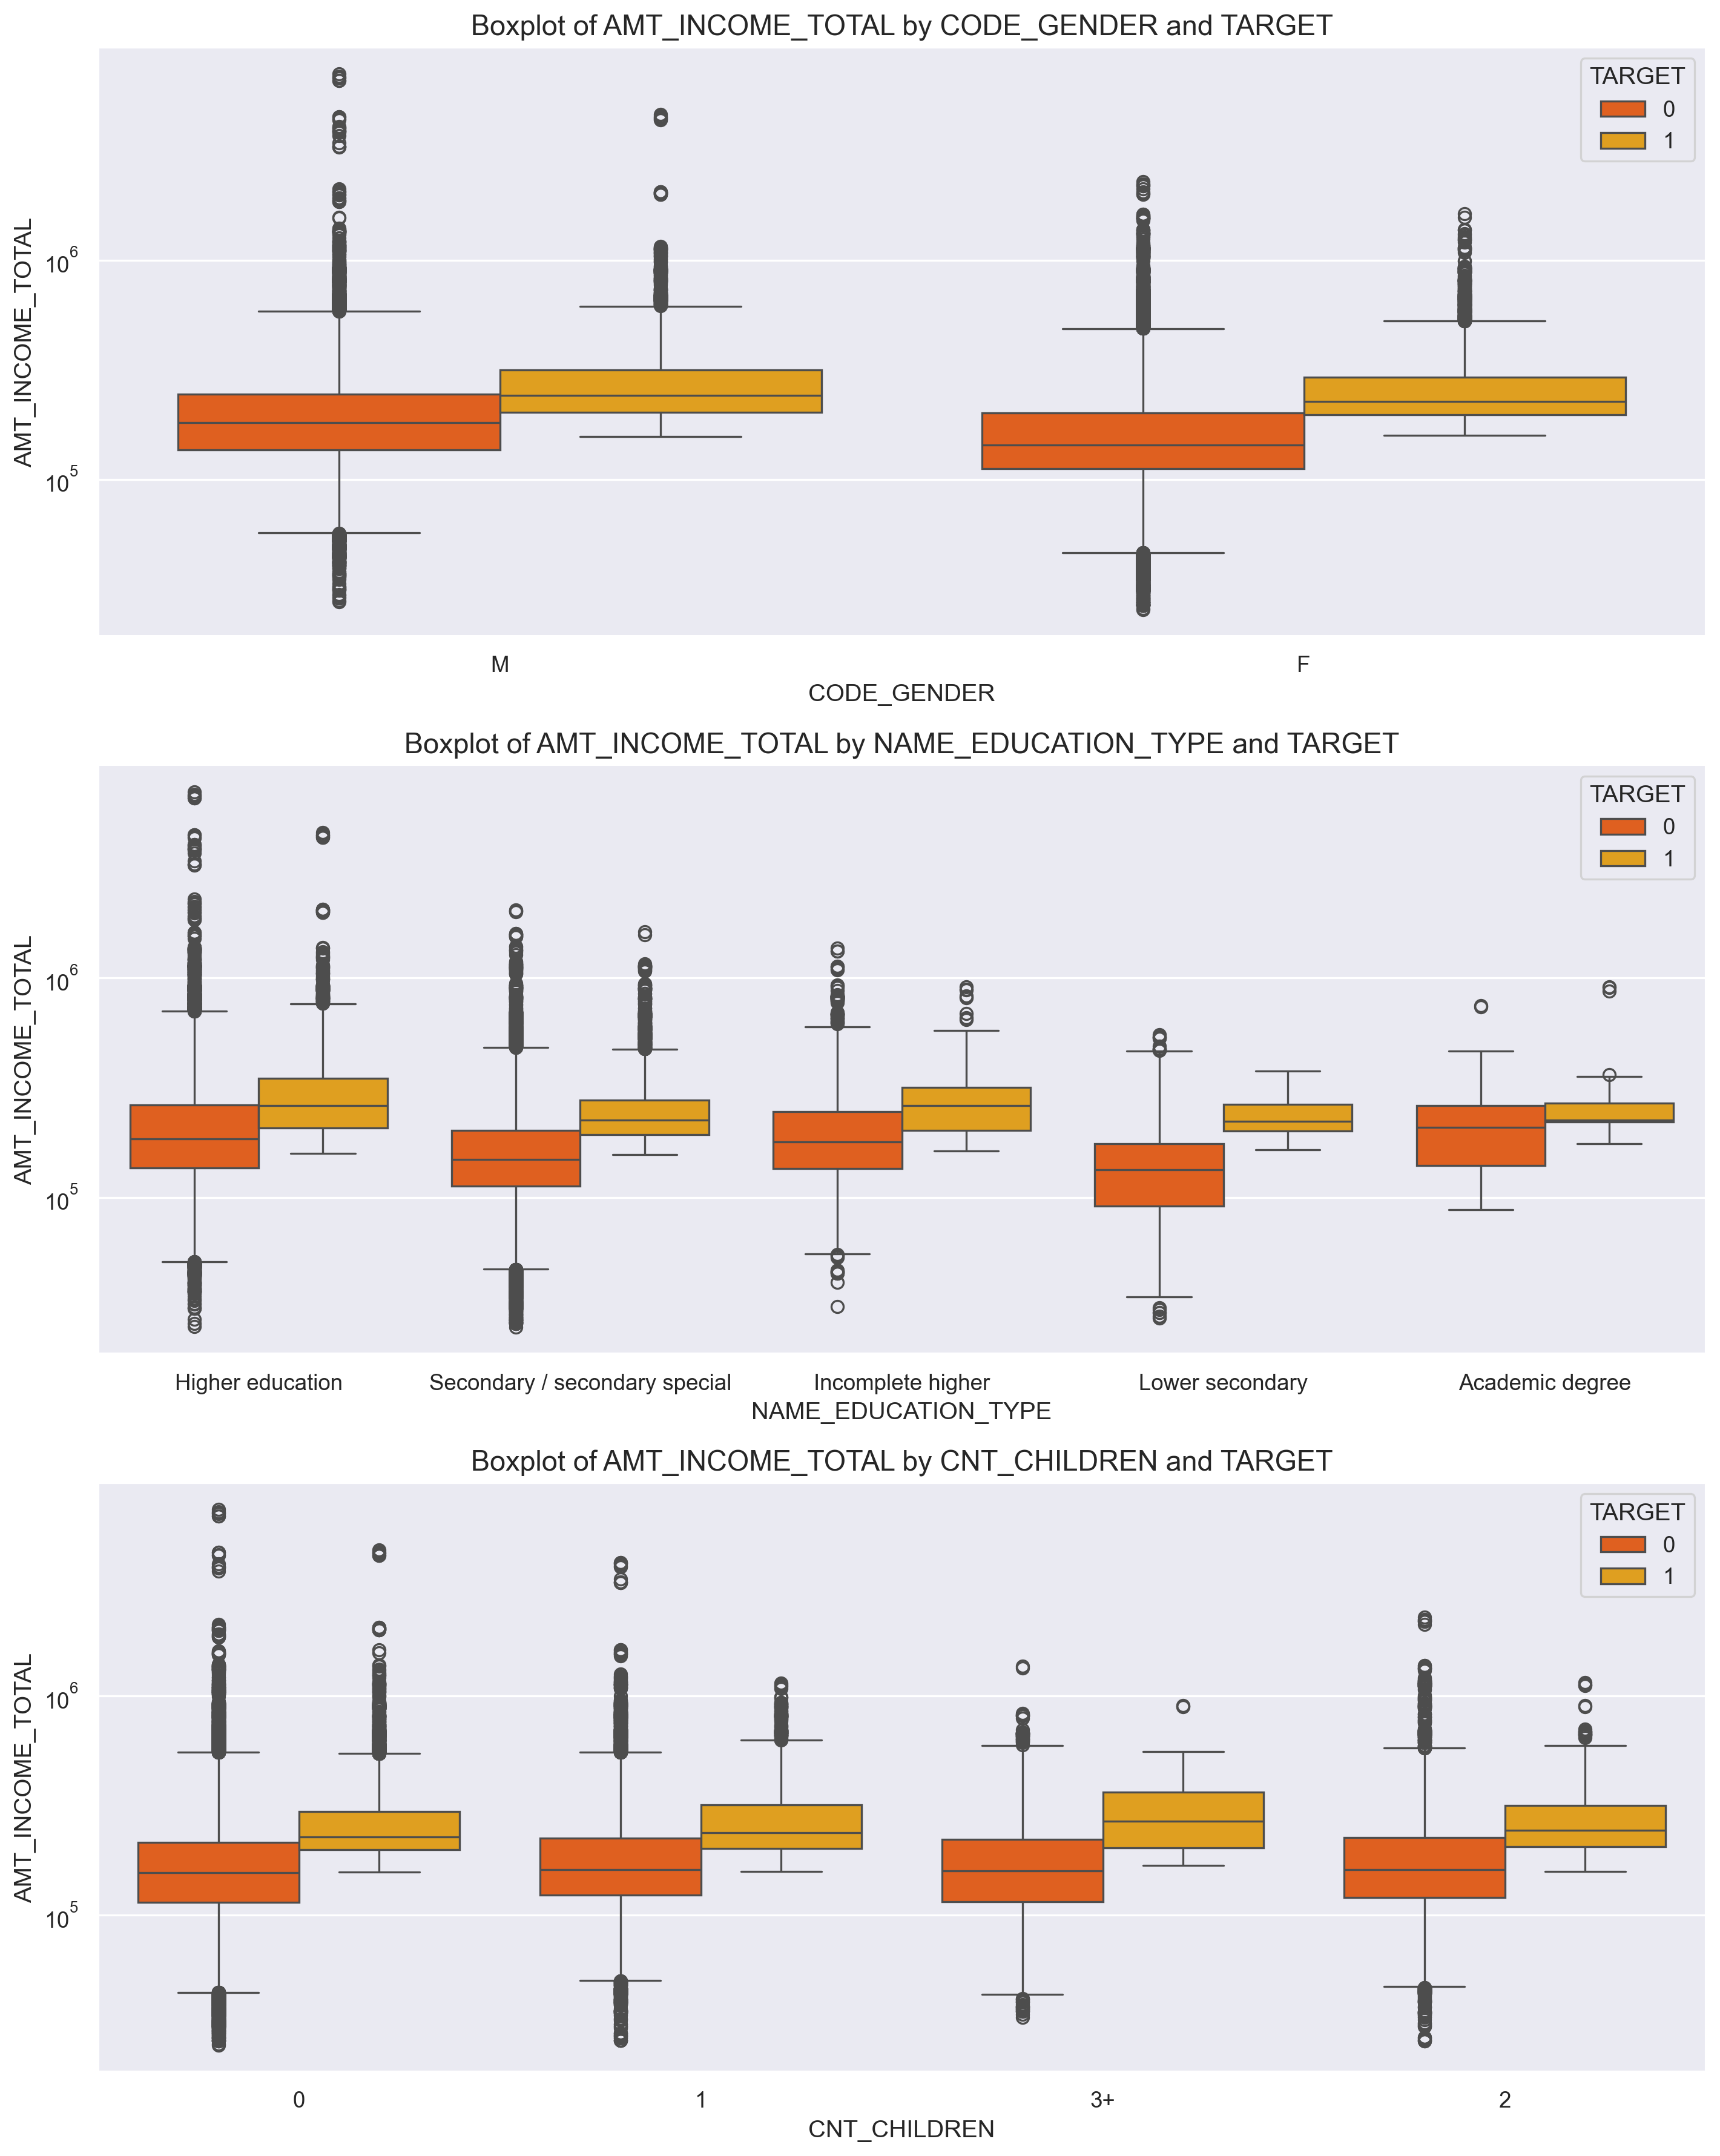

In [102]:
cat_columns = ["CODE_GENDER", "NAME_EDUCATION_TYPE", "CNT_CHILDREN"]

plt.figure(figsize=(12, 15))

for i, column in enumerate(cat_columns):

    plt.subplot(3, 1, i+1)
    sns.boxplot(data=df, x=column, y='AMT_INCOME_TOTAL', hue="TARGET", log_scale=True, palette='autumn')
    plt.title(f'Boxplot of AMT_INCOME_TOTAL by {column} and TARGET', fontsize=14)
    plt.legend(title='TARGET', loc='upper right')

    
plt.tight_layout()
plt.show()

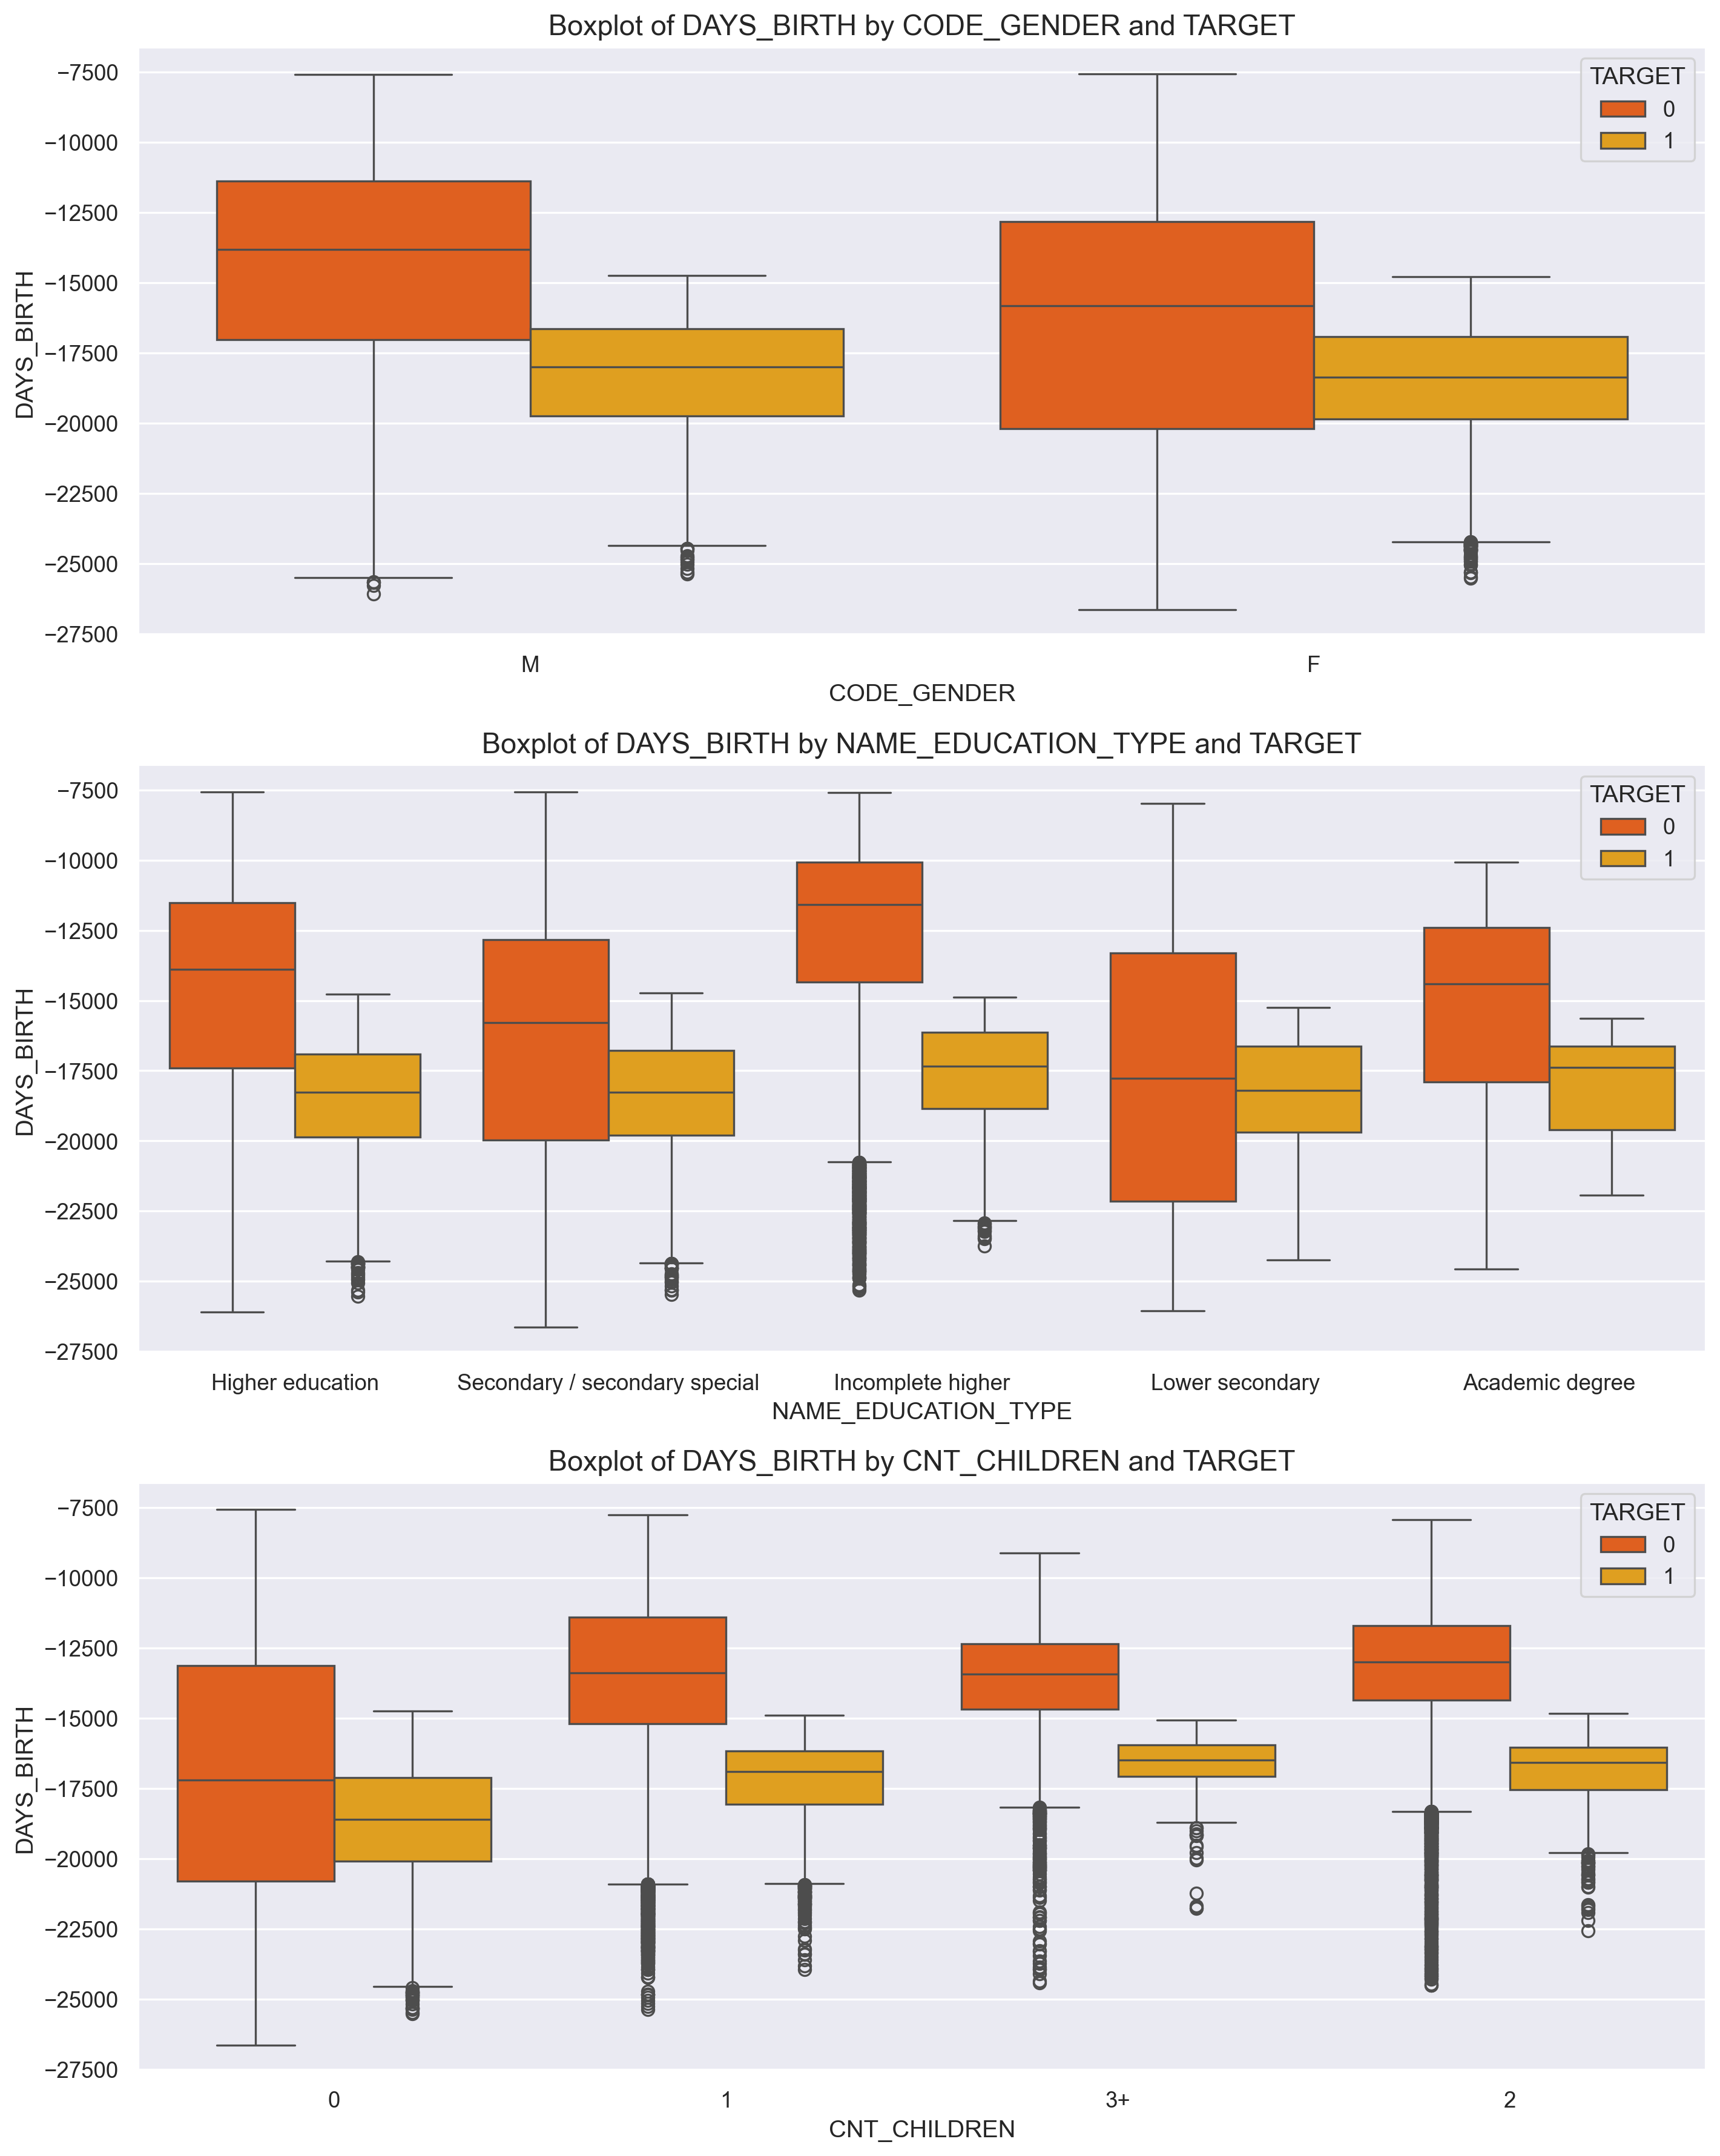

In [103]:
cat_columns = ["CODE_GENDER", "NAME_EDUCATION_TYPE", "CNT_CHILDREN"]

plt.figure(figsize=(12, 15))

for i, column in enumerate(cat_columns):

    plt.subplot(3, 1, i+1)
    sns.boxplot(data=df, x=column, y='DAYS_BIRTH', hue="TARGET", palette='autumn')
    plt.title(f'Boxplot of DAYS_BIRTH by {column} and TARGET', fontsize=14)
    plt.legend(title='TARGET', loc='upper right')

    
plt.tight_layout()
plt.show()

## Data preparation

In this phase, the dataset is further transformed and organized to be properly processed by machine learning algorithms.

First, the binary categorical features in string format are converted to numeric type.

In [104]:
df["CODE_GENDER"] = df["CODE_GENDER"].map({"M":0, "F":1})
df["FLAG_OWN_CAR"] = df["FLAG_OWN_CAR"].map({"N":0, "Y":1})
df["FLAG_OWN_REALTY"] = df["FLAG_OWN_REALTY"].map({"N":0, "Y":1})

Then, a one-hot encoding on multi-class categorial features is applied.

In [105]:
obj_columns = df.select_dtypes(include=[object]).columns

for column in obj_columns:
    print(column)
    print(f"Categories: {df[column].unique()}\n")

CNT_CHILDREN
Categories: ['0' '1' '3+' '2']

NAME_INCOME_TYPE
Categories: ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

NAME_EDUCATION_TYPE
Categories: ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

NAME_FAMILY_STATUS
Categories: ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

NAME_HOUSING_TYPE
Categories: ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']

OCCUPATION_TYPE
Categories: ['Other working' 'Security staff' 'Sales staff' 'Unemployed' 'Accountants'
 'Laborers' 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Other state servant' 'Private service staff'
 'Other commercial associate' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff' 'Other student']

CNT_FAM_MEMBERS
Categories: ['2' '1' '5+' 

In [106]:
# One-hot encoding on 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 
# 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS' features

df_enc = pd.get_dummies(df, columns=["CNT_CHILDREN", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
                                     "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "CNT_FAM_MEMBERS"], dtype=int)
df_enc

ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  AMT_INCOME_TOTAL  \
0       5008804            0             1                1         424380.57   
1       5008805            0             1                1         421593.52   
2       5008806            0             1                1         110958.51   
3       5008808            1             0                1         267497.96   
4       5008809            1             0                1         263419.09   
...         ...          ...           ...              ...               ...   
338421  6392174            1             0                1         158685.43   
338422  6392175            1             0                1         158517.14   
338423  6392177            1             0                1         156354.84   
338424  6392178            1             0                1         159019.43   
338425  6392179            1             0                1         162723.53   

        DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  \
0         -11778.0        -4438.0         1.0              1.0         0.0   
1         -11777.0        -4459.0         1.0              1.0         0.0   
2         -21471.0        -1144.0         1.0              0.0         0.0   
3         -18489.0        -3122.0         1.0              0.0         1.0   
4         -19093.0        -3070.0         1.0              0.0         1.0   
...            ...            ...         ...              ...         ...   
338421    -22970.0       374406.0         1.0              0.0         0.0   
338422    -24647.0       356447.0         1.0              0.0         0.0   
338423    -24080.0       355074.0         1.0              0.0         0.0   
338424    -24287.0       367012.0         1.0              0.0         0.0   
338425    -23790.0       350457.0         1.0              0.0         0.0   

        ...  OCCUPATION_TYPE_Sales staff  OCCUPATION_TYPE_Secretaries  \
0       ...                            0                            0   
1       ...                            0                            0   
2       ...                            0                            0   
3       ...                            1                            0   
4       ...                            1                            0   
...     ...                          ...                          ...   
338421  ...                            0                            0   
338422  ...                            0                            0   
338423  ...                            0                            0   
338424  ...                            0                            0   
338425  ...                            0                            0   

        OCCUPATION_TYPE_Security staff  OCCUPATION_TYPE_Unemployed  \
0                                    0                           0   
1                                    0                           0   
2                                    1                           0   
3                                    0                           0   
4                                    0                           0   
...                                ...                         ...   
338421                               0                           1   
338422                               0                           1   
338423                               0                           1   
338424                               0                           1   
338425                               0                           1   

        OCCUPATION_TYPE_Waiters/barmen staff  CNT_FAM_MEMBERS_1  \
0                                          0                  0   
1                                          0                  0   
2                                          0                  0   
3                                          0                  1   
4                                          0      

In [107]:
obj_columns_enc = df_enc.select_dtypes(include=[object]).columns
len(obj_columns_enc)

0

In [108]:
# Removing 'ID' column (not informative) and defining features and target varables

X = df_enc.drop(['TARGET', 'ID'], axis=1)
y = df_enc['TARGET']

In [109]:
print("Initial class distribution:")

class_count = Counter(y)
print(f"  0 (Low): {class_count[0]} samples")
print(f"  1 (High): {class_count[1]} samples")

imbalance_ratio = class_count[0] / class_count[1]
print(f"\nImbalance ratio (minority:majority): 1:{imbalance_ratio:.2f}")

Initial class distribution:
  0 (Low): 308704 samples
  1 (High): 29722 samples

Imbalance ratio (minority:majority): 1:10.39


### Splitting and standardization

In [110]:
# Splitting data into training and testing datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [111]:
print(f"\nTraining set size: {X_train.shape[0]} samples (with {X_train.shape[1]} features)")
print("Class distribution in training set:")
print(f"  0 (Low): {Counter(y_train)[0]}")
print(f"  1 (High): {Counter(y_train)[1]}")

print(f"\nTest set size: {X_test.shape[0]} samples (with {X_test.shape[1]} features)")
print("Class distribution in testing set:")
print(f"  0 (Low): {Counter(y_test)[0]}")
print(f"  1 (High): {Counter(y_test)[1]}")


Training set size: 270740 samples (with 63 features)
Class distribution in training set:
  0 (Low): 246962
  1 (High): 23778

Test set size: 67686 samples (with 63 features)
Class distribution in testing set:
  0 (Low): 61742
  1 (High): 5944


In [112]:
# Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [113]:
# Converting back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

test_data = pd.DataFrame(X_test_scaled)
test_data['TARGET'] = y_test.values

### Creating resampled training datasets

Since the TARGET variable resulted strongly unbalanced, with many more clients having a low credit standing, the predictive models will likely results in a high accuracy which is only reflecting the underlying class distribution. Therefore, more balanced datasets are created to improve the model’s ability to generalize.

From the original training dataset, 2 new datasets are obtained to reduce the dataset bias, by applying a combination of oversampling and undersampling:

A) Oversampling to 1:3 and undersampling to 1:1 <br>
B) Oversampling to 1:2 and undersampling to 1:1

The test dataset will not be modified, to reflect a realistic distribution of the target variable when evaluating the predictive model.

In [114]:
# Original dataset
datasets = {
    "Original": (X_train_scaled, y_train)
}

In [115]:
# A) Oversampling minority class (to 1:3) and undersampling majority class (to 1:1)

# Oversampling the minority class to obtain a 1:3 ratio
ros_strategy_A = 1/3
oversampler_A = RandomOverSampler(sampling_strategy=ros_strategy_A)
X_train_ros, y_train_ros = oversampler_A.fit_resample(X_train_scaled, y_train)
print(f"New class distribution for 1:3 ratio:")
print(f"  0 (Low): {Counter(y_train_ros)[0]}")
print(f"  1 (High): {Counter(y_train_ros)[1]}")

# Undersampling the majority class to obtain a 1:1 ratio
rus_strategy_A = 1/1
undersampler_A = RandomUnderSampler(sampling_strategy=rus_strategy_A)
X_train_A, y_train_A = undersampler_A.fit_resample(X_train_ros, y_train_ros)
datasets["Combined_Sampling_A"] = (X_train_A, y_train_A)
print(f"\nNew class distribution for combined sampling:")
print(f"  0 (Low): {Counter(y_train_A)[0]}")
print(f"  1 (Positive): {Counter(y_train_A)[1]}")

New class distribution for 1:3 ratio:
  0 (Low): 246962
  1 (High): 82320

New class distribution for combined sampling:
  0 (Low): 82320
  1 (Positive): 82320


In [116]:
# B) Oversampling minority class (to 1:2) and undersampling majority class (to 1:1)

# Oversampling the minority class to obtain a 1:2 ratio
ros_strategy_B = 1/2
oversampler_B = RandomOverSampler(sampling_strategy=ros_strategy_B)
X_train_ros, y_train_ros = oversampler_B.fit_resample(X_train_scaled, y_train)
print(f"New class distribution for 1:3 ratio:")
print(f"  0 (Low): {Counter(y_train_ros)[0]}")
print(f"  1 (High): {Counter(y_train_ros)[1]}")

# Undersampling the majority class to obtain a 1:1 ratio
rus_strategy_B = 1/1
undersampler_B = RandomUnderSampler(sampling_strategy=rus_strategy_B)
X_train_B, y_train_B = undersampler_B.fit_resample(X_train_ros, y_train_ros)
datasets["Combined_Sampling_B"] = (X_train_B, y_train_B)
print(f"\nNew class distribution for combined sampling:")
print(f"  0 (Low): {Counter(y_train_B)[0]}")
print(f"  1 (Positive): {Counter(y_train_B)[1]}")

New class distribution for 1:3 ratio:
  0 (Low): 246962
  1 (High): 123481

New class distribution for combined sampling:
  0 (Low): 123481
  1 (Positive): 123481


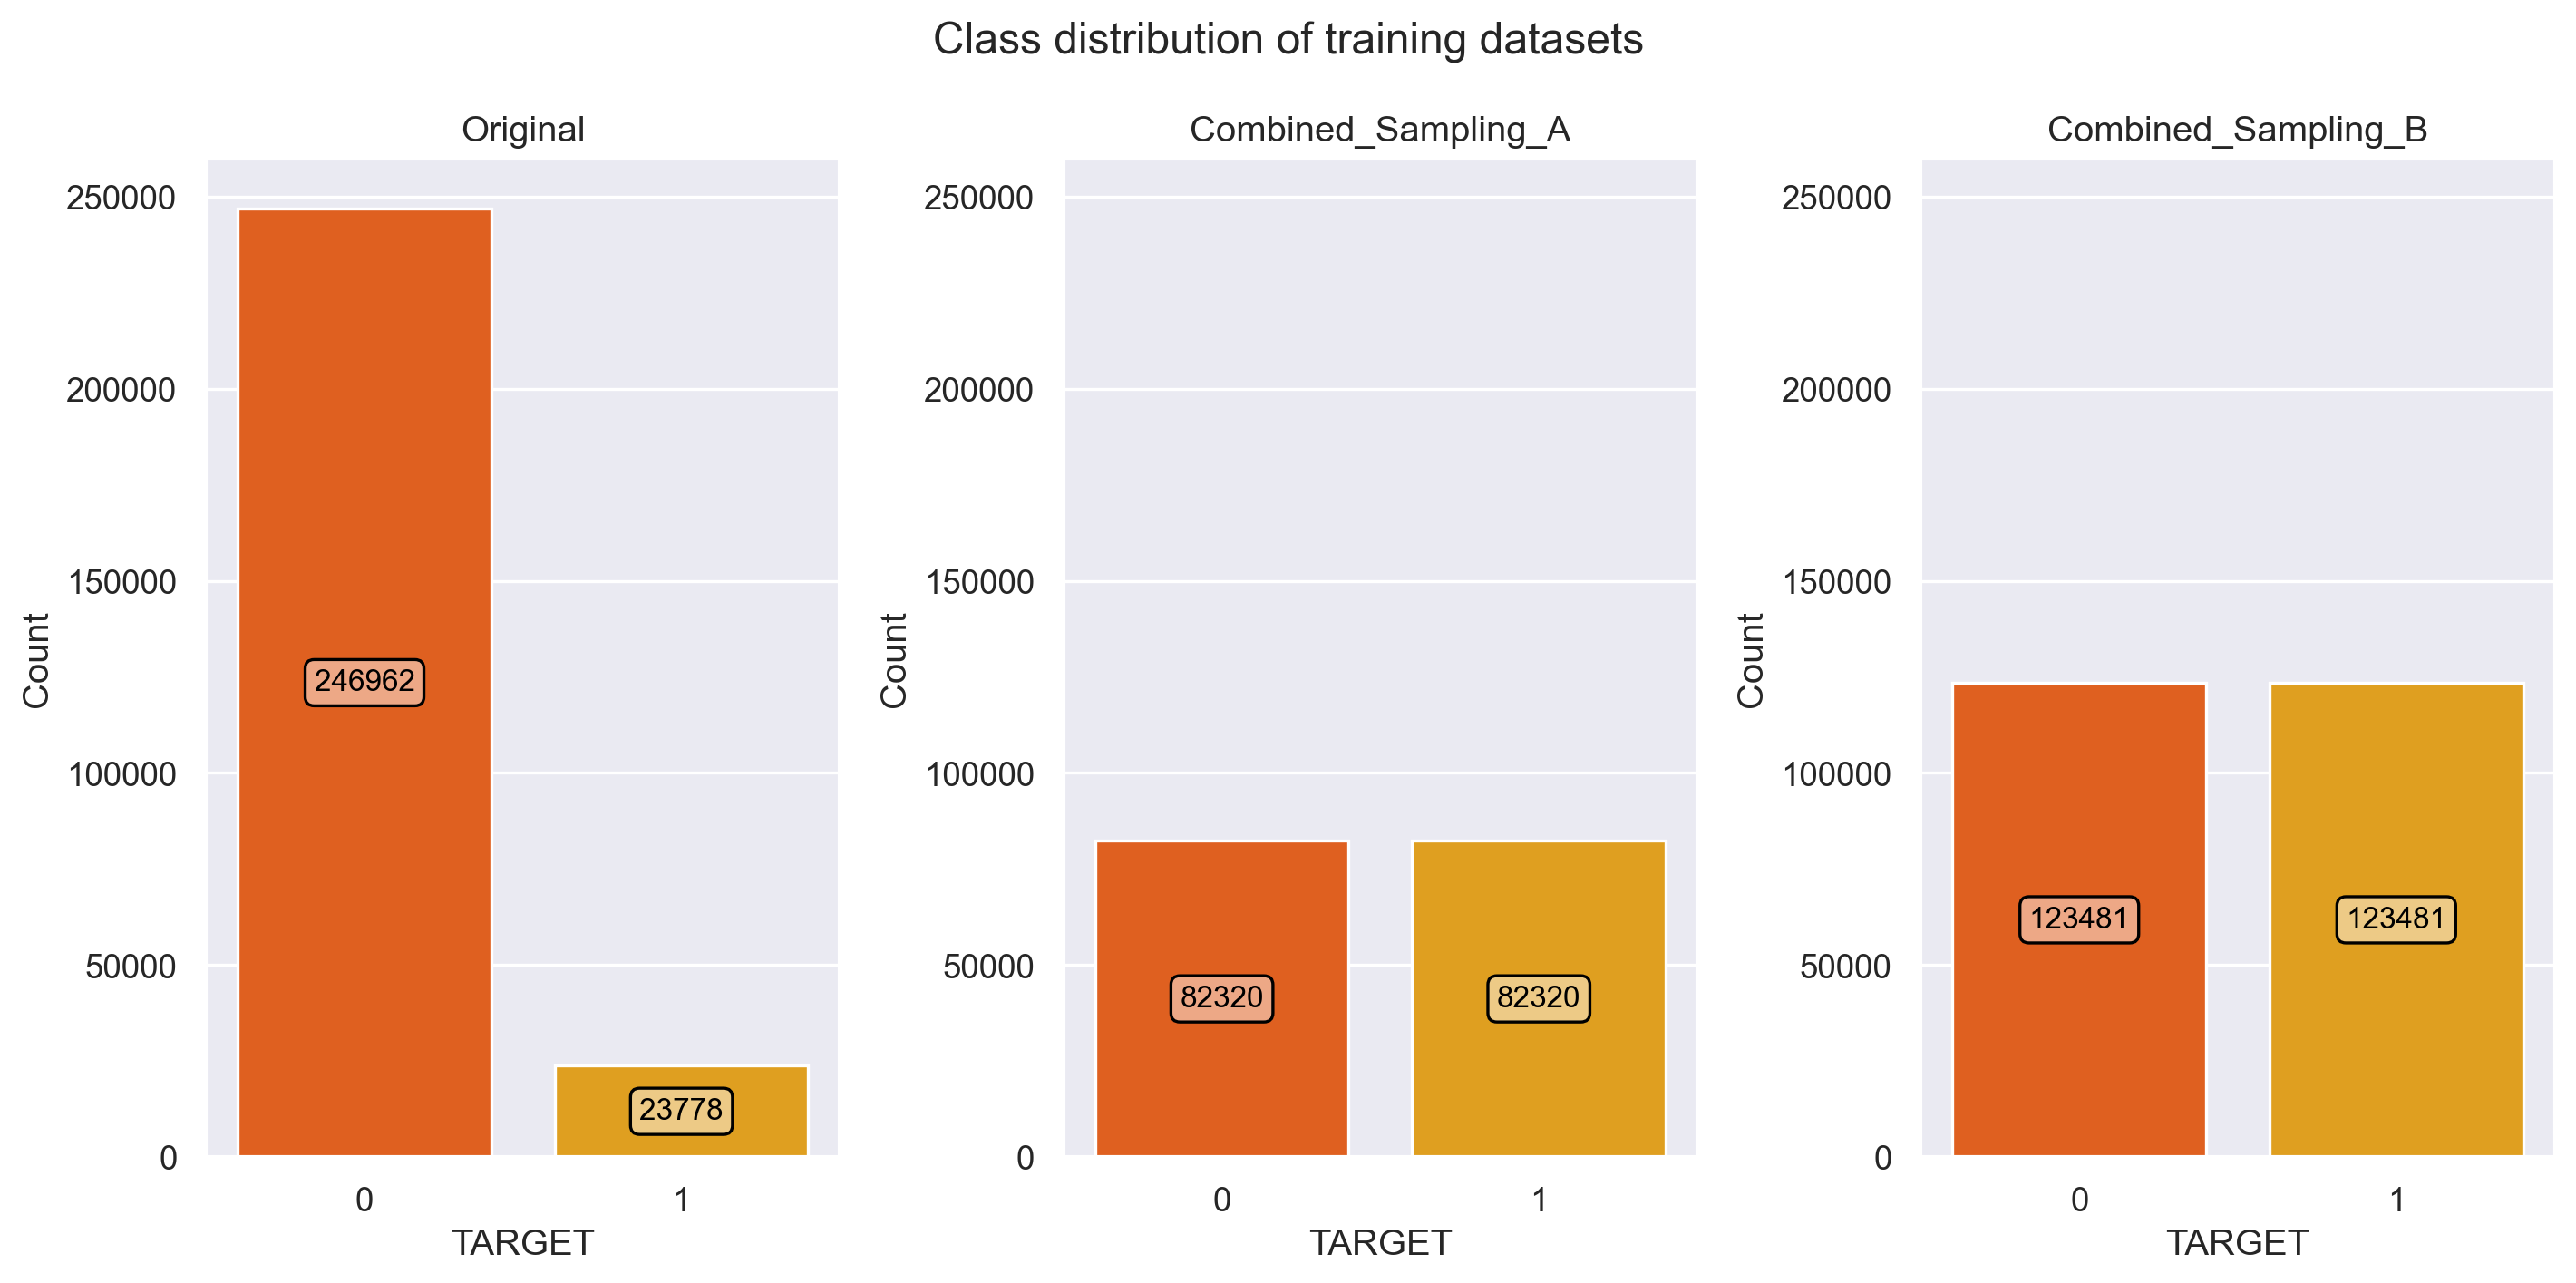

In [117]:
# Count plots to visualize the distributions of 'TARGET' varible in the training datasets

plt.figure(figsize=(12, 6))

for i, dataset in enumerate(datasets.keys()):

    plt.subplot(1, 3, i+1)
    sns.countplot(x=datasets[dataset][1], hue=datasets[dataset][1], palette='autumn', legend=False)
    plt.ylim(0, 260000)
    plt.title(dataset, fontsize=12)
    plt.xlabel('TARGET')
    plt.ylabel('Count')

    for i, count in Counter(datasets[dataset][1]).items():
        plt.annotate(f"{count}", 
                     xy=(i, count/2), 
                     ha='center', va='center',
                     fontsize=10, color='black',
                     bbox = dict(boxstyle="round", ec='black', fc="#ffffff75"))

plt.suptitle("Class distribution of training datasets")
plt.tight_layout()
plt.show()

## Model training

In this section, a model will be built to predict the probability that the bank's clients would have a good credit standing, by identifying the customers which are most likely to pay regularly for the credit card.

Three different classification algorithms will be trained and evaluated for all the training sets.

In [118]:
print("List of training datasets:")
for dataset in datasets.keys():
    print(f" - {dataset}")

List of training datasets:
 - Original
 - Combined_Sampling_A
 - Combined_Sampling_B


In [119]:
# Define the test set (same for all models and training sets)
X_test = test_data.drop('TARGET', axis=1)
y_test = test_data['TARGET']
print(f"Test set with {X_test.shape[0]} samples")

Test set with 67686 samples


In [120]:
# Define a function to train and evaluate model performance on all training datasets

def train_evaluate_model(datasets, model, X_test, y_test):

    results = {}

    for dataset, (X_train, y_train) in datasets.items():

        print(f"\nTraining model on {dataset} dataset")

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on test set
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Calculate metrics
        metrics = {}
        metrics['accuracy'] = accuracy_score(y_test, y_pred)
        metrics['precision'] = precision_score(y_test, y_pred)
        metrics['recall'] = recall_score(y_test, y_pred)
        metrics['f1'] = f1_score(y_test, y_pred)
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
        metrics['pr_auc'] = average_precision_score(y_test, y_pred_proba)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test, y_pred)

        # Store results
        results[dataset] = {
            'metrics': metrics,
            'confusion_matrix': cm,
            'predictions': y_pred_proba
        }

    print("\n---------")
    print("Completed")

    return results

In [121]:
# Define a function to plot confusion matrices from model results

def plot_confusion_matrices(model_name, model_results):
    
    plt.figure(figsize=(12, 5))

    for i, dataset in enumerate(model_results.keys()):

        plt.subplot(1, 3, i+1)
        sns.heatmap(model_results[dataset]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"""{dataset}\nPrecision: {model_results[dataset]['metrics']['precision']:.2f} - Recall: {model_results[dataset]['metrics']['recall']:.2f} (F1: {model_results[dataset]['metrics']['f1']:.2f})""")
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

    plt.suptitle(f"Confusion matrices of {model_name} models")
    plt.tight_layout()
    plt.show()

### Stochastic Gradient Descent

The first approach considered is [Stochastic Gradient Descent (SGD)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), an estimator implementing regularized linear models, where the gradient of the loss is estimated each sample at a time and the model is updated with a decreasing learning rate. The loss function used here is 'modified_huber', which implements a smoothed Support Vector Machine providing tolerance to outliers and probability estimates.

In [122]:
# Train the model and calculate results

sgd_classifier = SGDClassifier(loss='modified_huber', class_weight="balanced", n_jobs=-1)

sgd_classifier_results = train_evaluate_model(datasets, sgd_classifier, X_test, y_test)


Training model on Original dataset

Training model on Combined_Sampling_A dataset

Training model on Combined_Sampling_B dataset

---------
Completed


In [151]:
# Print all metrics
print("Stochastic Gradient Descent")
for dataset, results in sgd_classifier_results.items():
    print("\n"+dataset)
    for metric, value in results['metrics'].items():
        print(f" {metric+":":<10} {value:.3f}")

Stochastic Gradient Descent

Original
 accuracy:  0.805
 precision: 0.293
 recall:    0.863
 f1:        0.438
 roc_auc:   0.901
 pr_auc:    0.389

Combined_Sampling_A
 accuracy:  0.825
 precision: 0.315
 recall:    0.847
 f1:        0.459
 roc_auc:   0.912
 pr_auc:    0.419

Combined_Sampling_B
 accuracy:  0.821
 precision: 0.312
 recall:    0.865
 f1:        0.459
 roc_auc:   0.913
 pr_auc:    0.416


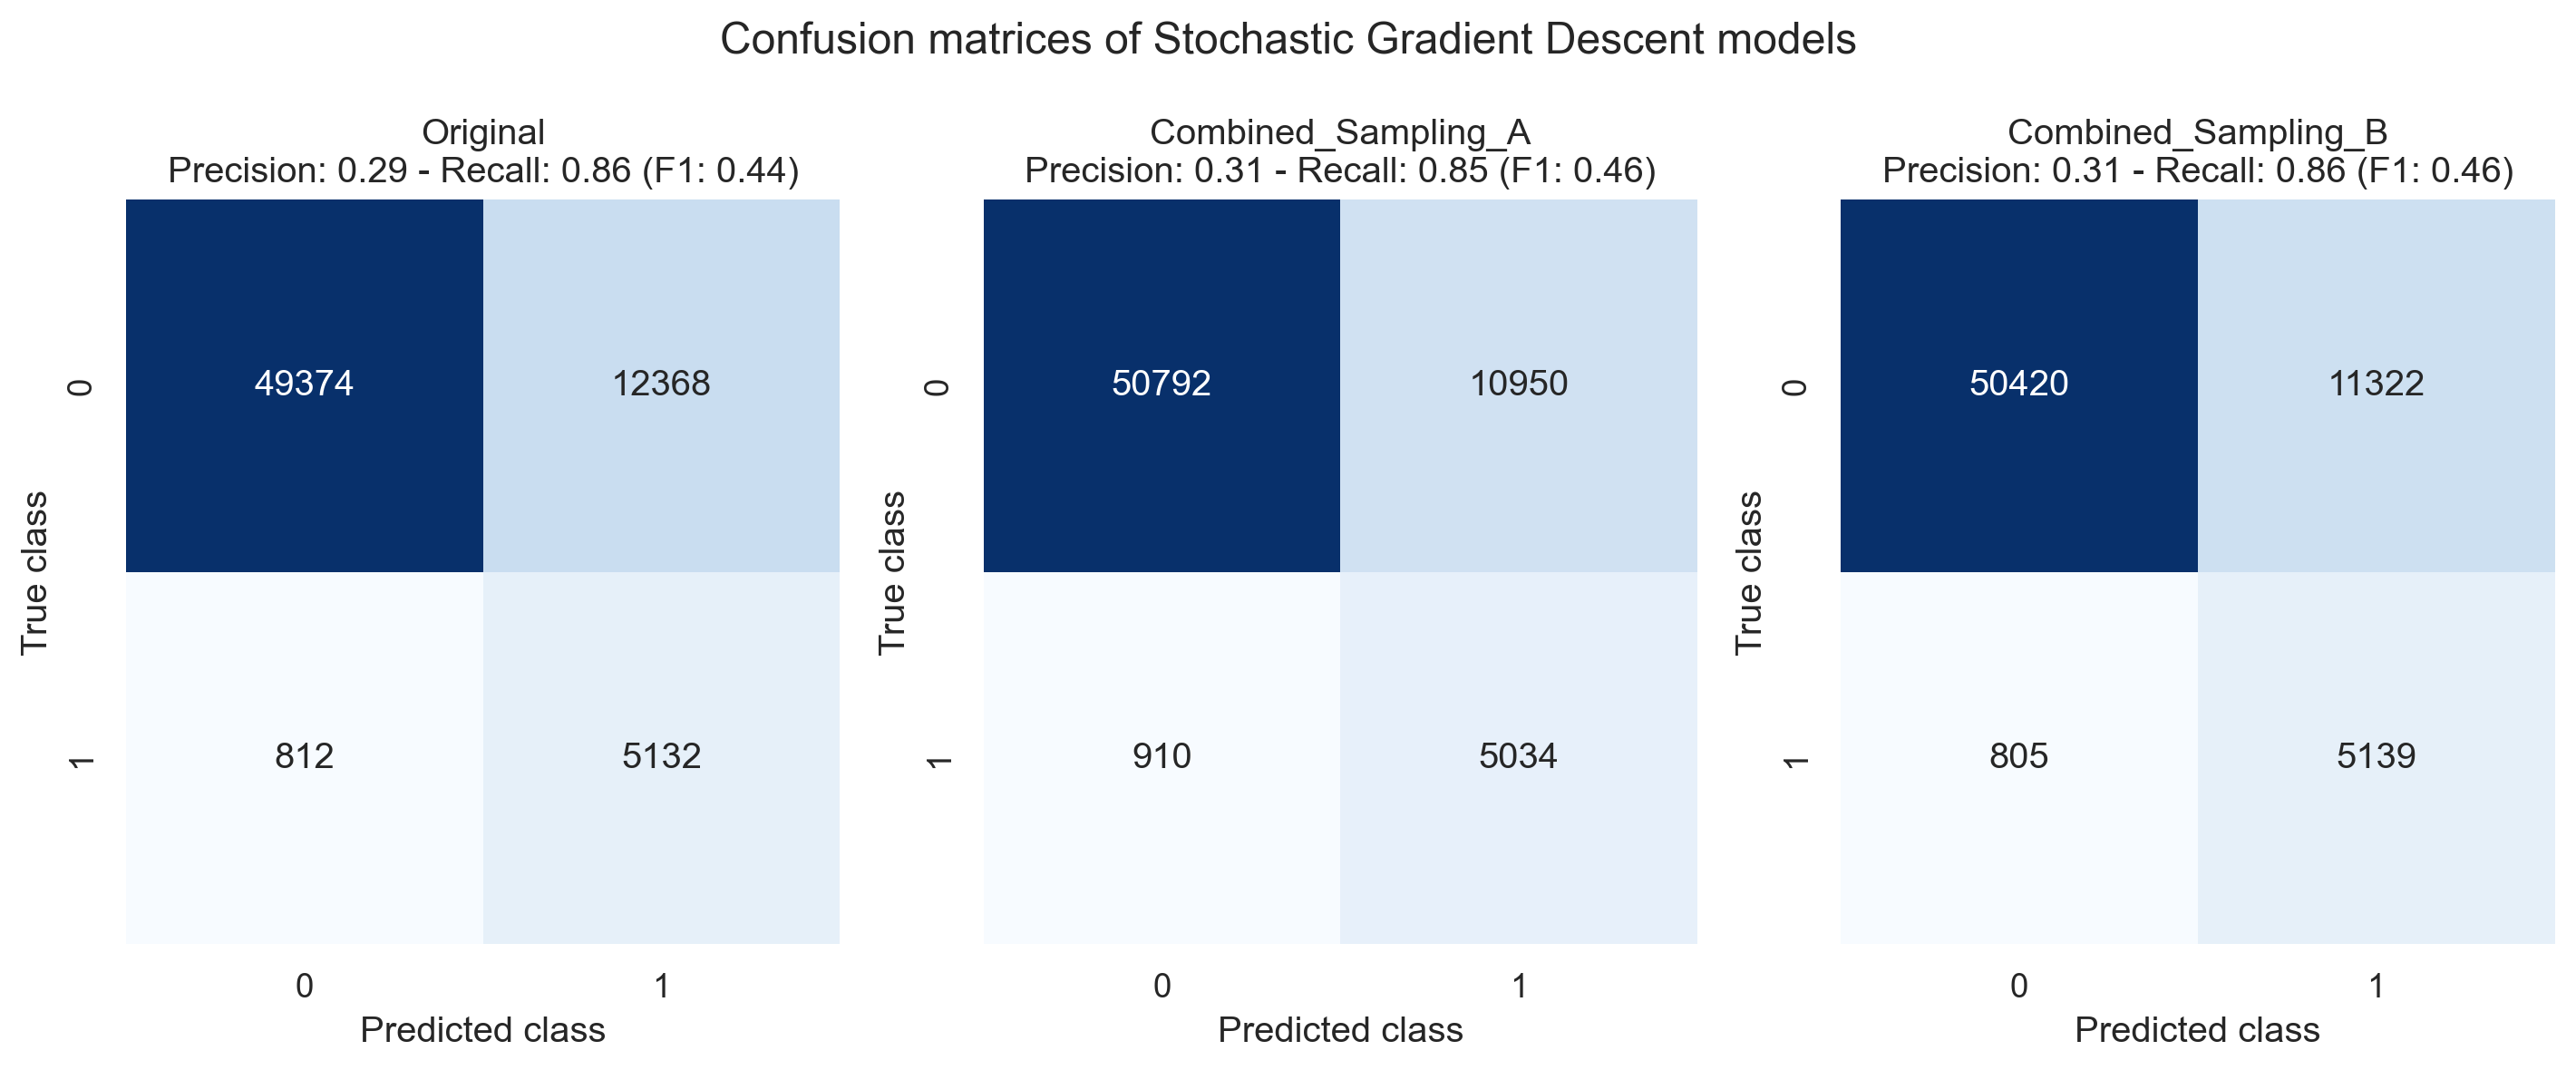

In [123]:
# Plot confusion matrices

plot_confusion_matrices("Stochastic Gradient Descent", sgd_classifier_results)

SGD models resulted in high accuracy values (higher than 0.8). However, they achieved low precision values (around 0.3), which results in f1 values lower than 0.5.

### Random Forest

The second model considered is [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), an ensemble machine learning algorithm which trains multiple decision trees (to predict the value of the target variable by learning decision rules based on feature values) and combines their outputs to make the final prediction.

In [124]:
# Train the model and calculate results

random_forest = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

random_forest_results = train_evaluate_model(datasets, random_forest, X_test, y_test)


Training model on Original dataset

Training model on Combined_Sampling_A dataset

Training model on Combined_Sampling_B dataset

---------
Completed


In [152]:
# Print all metrics
print("Random Forest")
for dataset, results in random_forest_results.items():
    print("\n"+dataset)
    for metric, value in results['metrics'].items():
        print(f" {metric+":":<10} {value:.3f}")

Random Forest

Original
 accuracy:  0.949
 precision: 0.700
 recall:    0.732
 f1:        0.716
 roc_auc:   0.979
 pr_auc:    0.705

Combined_Sampling_A
 accuracy:  0.957
 precision: 0.680
 recall:    0.954
 f1:        0.794
 roc_auc:   0.979
 pr_auc:    0.706

Combined_Sampling_B
 accuracy:  0.957
 precision: 0.689
 recall:    0.927
 f1:        0.791
 roc_auc:   0.979
 pr_auc:    0.704


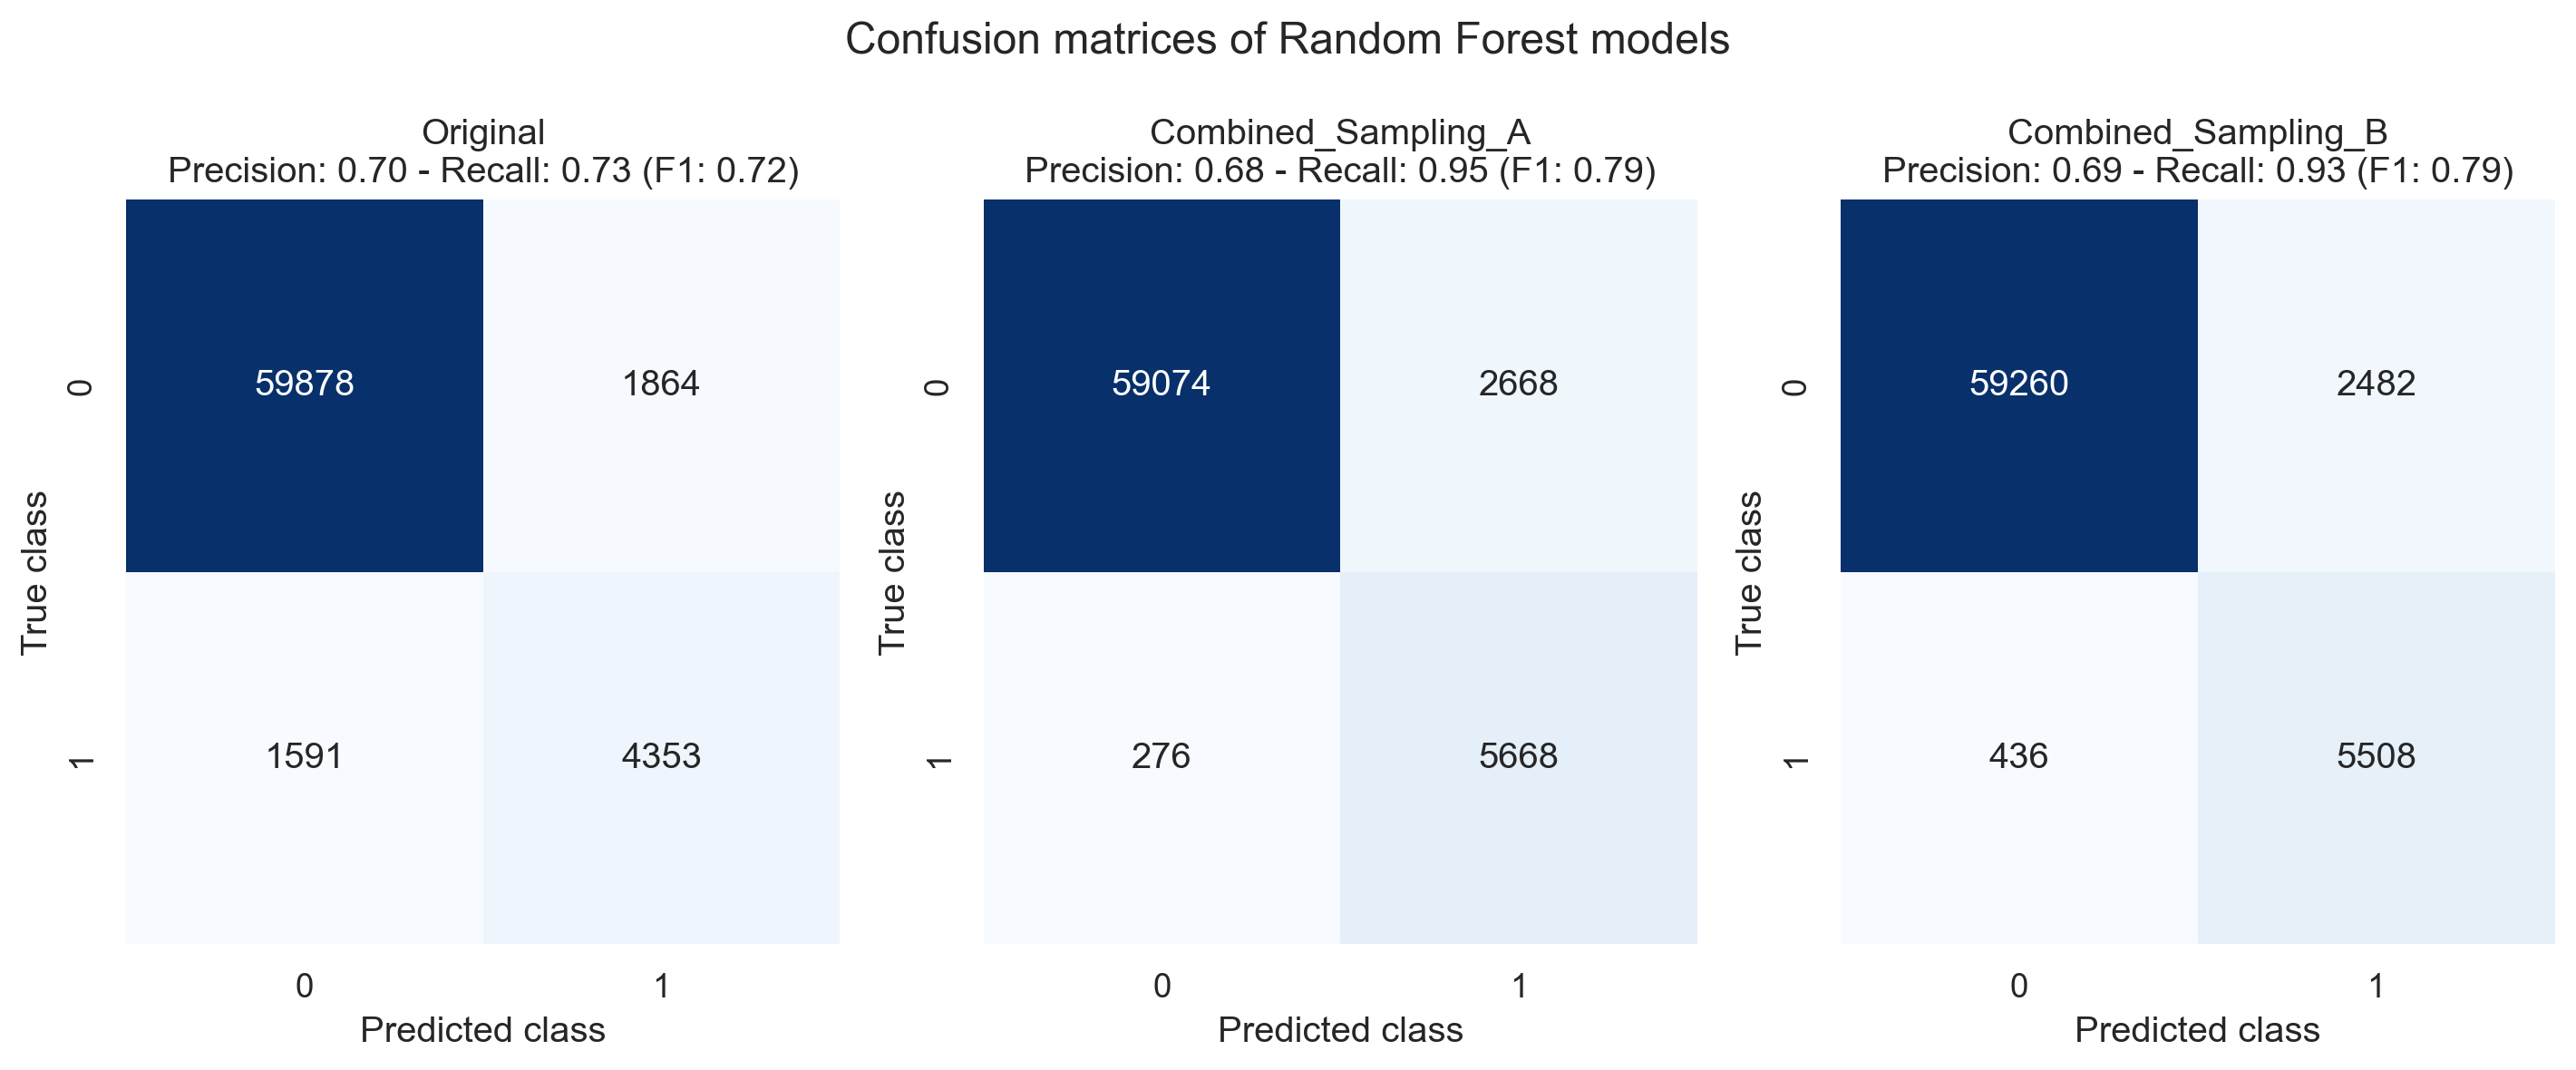

In [125]:
# Plot confusion matrices

plot_confusion_matrices("Random Forest", random_forest_results)

Random Forest models resulted in extremely high accuracy values (around 0.95). While generally higher than SGD models, f1 values varied between training datasets (0.72 for the original dataset and 0.79 for resampled datasets). This is due to the higher recall values achieved by the resampled datasets (around 0.95) respect to the original dataset (0.73). The precision values are around 0.7 for all datasets.

### Multi-layer Perceptron

The third model considered is [Multi-layer Perceptron (MLP)](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), a machine learning algorithm that  trains using a form of gradient descent, where gradients are calculated using backpropagation. 
During training, it iteratively adjusts the weights connecting layers so that it minimizes a Cross-Entropy loss function, giving a vector of class probability estimates. In this implementation, input features are passed through one hidden layer containing 100 neurons, which transform the values with a weighted linear summation (where weights are optimized with the Adam algorithm, an adaptive variant of stochastic gradient descent) followed by a Rectified Linear Unit activation function. The global learning rate remains fixed throughout training at the value of 0.001.

In [126]:
# Train the model and calculate results

mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.001)

mlp_classifier_results = train_evaluate_model(datasets, mlp_classifier, X_test, y_test)


Training model on Original dataset

Training model on Combined_Sampling_A dataset

Training model on Combined_Sampling_B dataset

---------
Completed


In [153]:
# Print all metrics
print("Multi-layer Perceptron")
for dataset, results in mlp_classifier_results.items():
    print("\n"+dataset)
    for metric, value in results['metrics'].items():
        print(f" {metric+":":<10} {value:.3f}")

Multi-layer Perceptron

Original
 accuracy:  0.943
 precision: 0.674
 recall:    0.670
 f1:        0.672
 roc_auc:   0.973
 pr_auc:    0.670

Combined_Sampling_A
 accuracy:  0.924
 precision: 0.537
 recall:    0.969
 f1:        0.691
 roc_auc:   0.973
 pr_auc:    0.660

Combined_Sampling_B
 accuracy:  0.927
 precision: 0.549
 recall:    0.972
 f1:        0.702
 roc_auc:   0.973
 pr_auc:    0.658


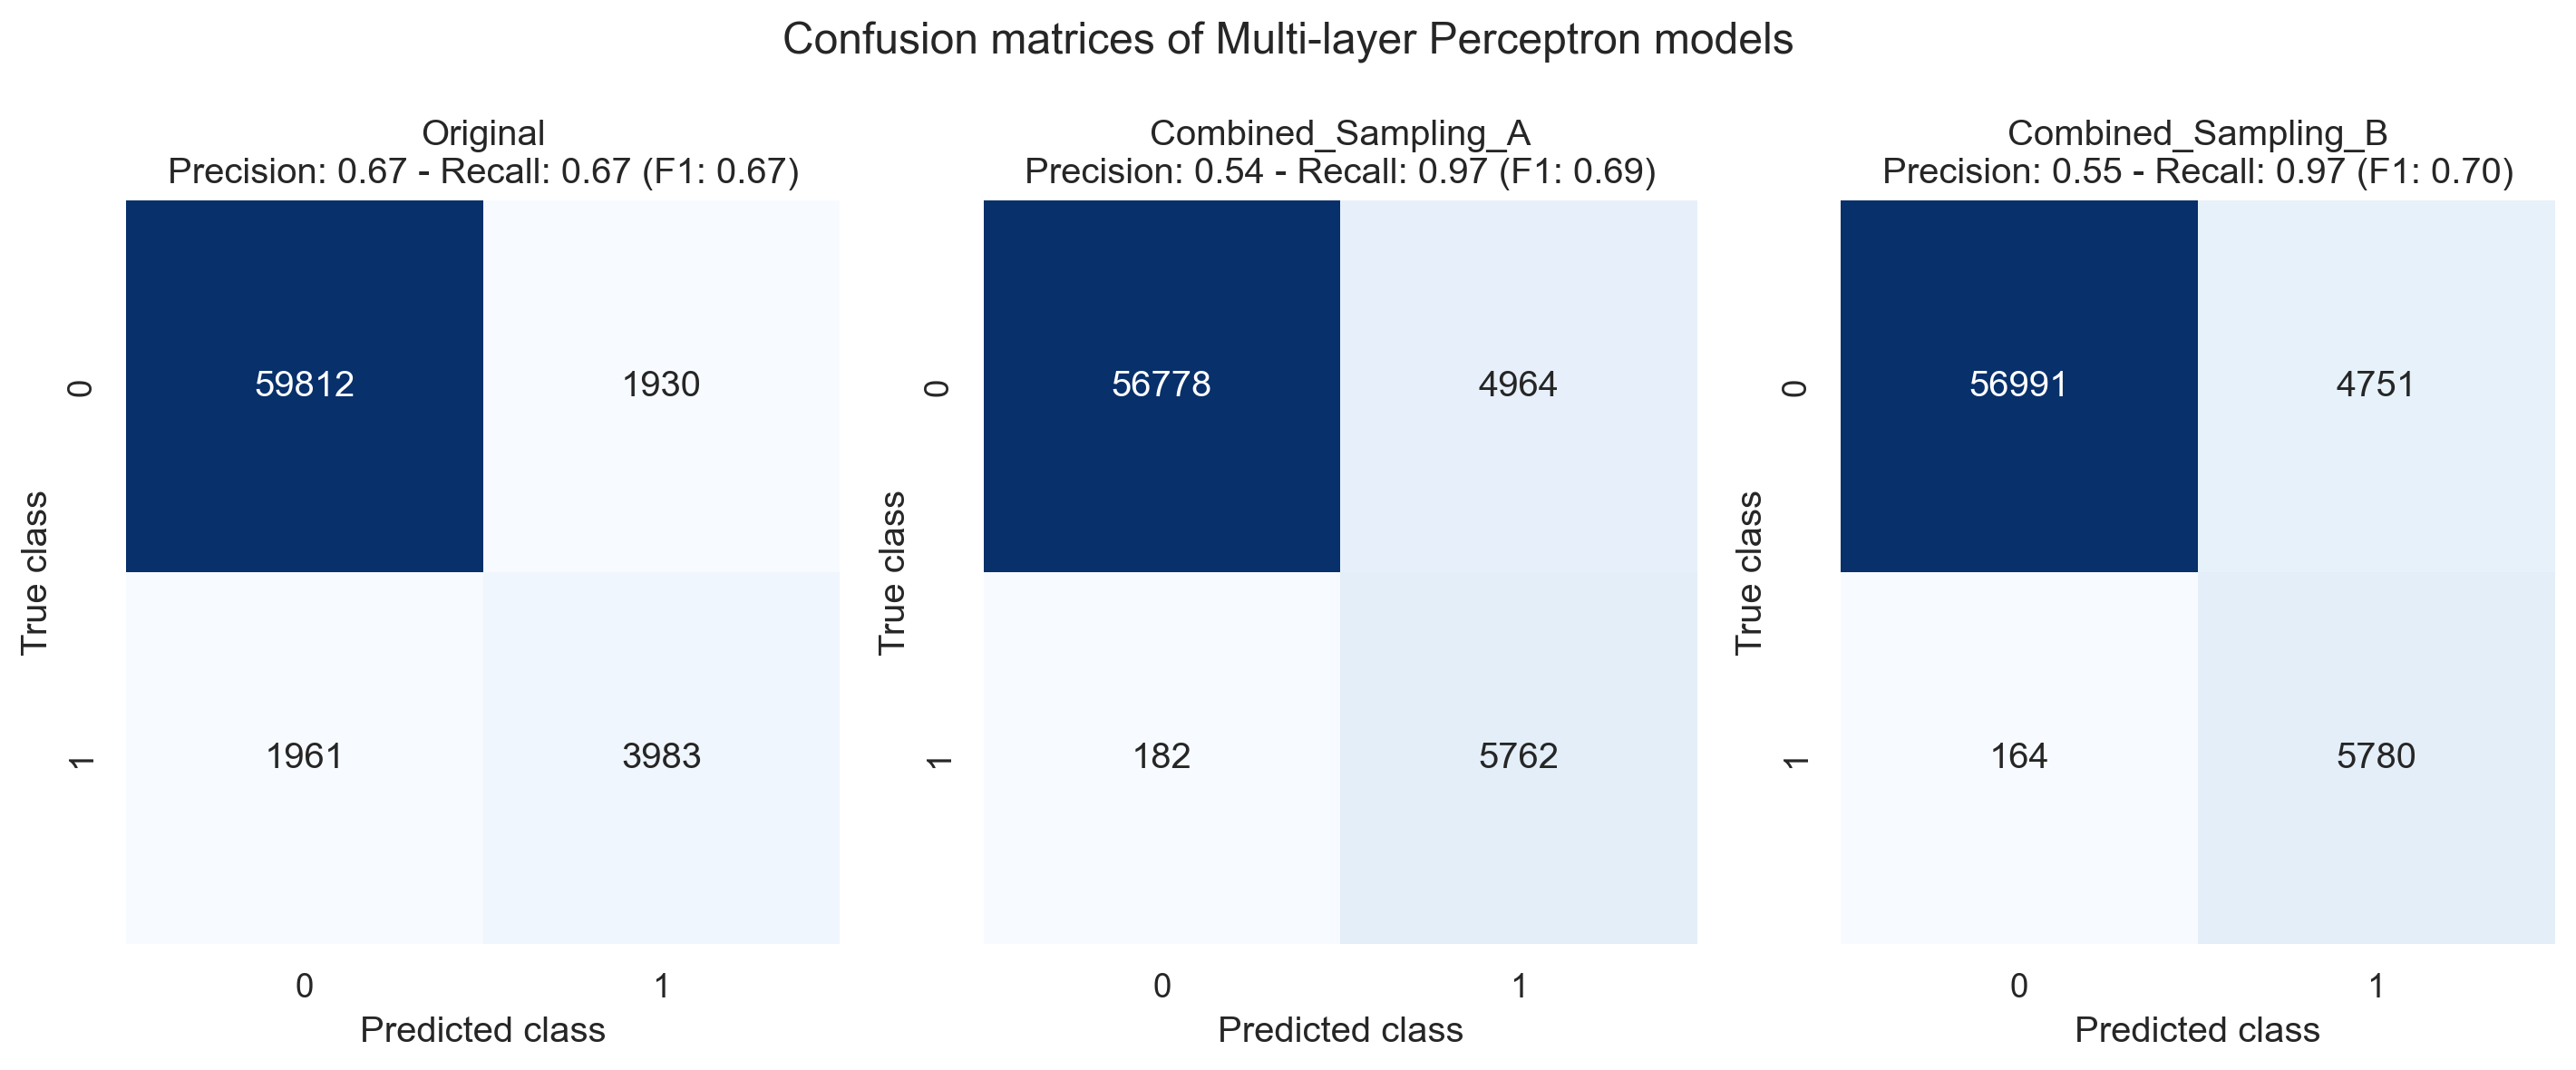

In [127]:
# Plot confusion matrices

plot_confusion_matrices("Multi-layer Perceptron", mlp_classifier_results)

MLP models also resulted in extremely high accuracy values (higher than 0.9). While achieving slightly lower f1 values (around 0.7) than Random Forest models, recall values obtained by the resempled dataset are slightly higher (0.97).

## Model evaluations

In this section, an overall evaluation of all trained models is performed.

In [154]:
all_results = {"Stochastic Gradient Descent": sgd_classifier_results, 
               "Random Forest": random_forest_results,
               "Multi-layer Perceptron": mlp_classifier_results, 
               }

### Summary of metrics

In [197]:
model_names = ["SGD", "RF", "MLP"]
model_results = list(all_results.values())
print(f" {"":<10} {model_names[0]:<10} {model_names[1]:<10} {model_names[2]:<10}")
for dataset, results in model_results[0].items():
    print("\n"+dataset)
    for metric, value in results['metrics'].items():
        print(f" {metric+":":<10} {model_results[0][dataset]['metrics'][metric]:<10.3f} {model_results[1][dataset]['metrics'][metric]:<10.3f} {model_results[2][dataset]['metrics'][metric]:<10.3f}")

            SGD        RF         MLP       

Original
 accuracy:  0.805      0.949      0.943     
 precision: 0.293      0.700      0.674     
 recall:    0.863      0.732      0.670     
 f1:        0.438      0.716      0.672     
 roc_auc:   0.901      0.979      0.973     
 pr_auc:    0.389      0.705      0.670     

Combined_Sampling_A
 accuracy:  0.825      0.957      0.924     
 precision: 0.315      0.680      0.537     
 recall:    0.847      0.954      0.969     
 f1:        0.459      0.794      0.691     
 roc_auc:   0.912      0.979      0.973     
 pr_auc:    0.419      0.706      0.660     

Combined_Sampling_B
 accuracy:  0.821      0.957      0.927     
 precision: 0.312      0.689      0.549     
 recall:    0.865      0.927      0.972     
 f1:        0.459      0.791      0.702     
 roc_auc:   0.913      0.979      0.973     
 pr_auc:    0.416      0.704      0.658     


### Confusion matrices

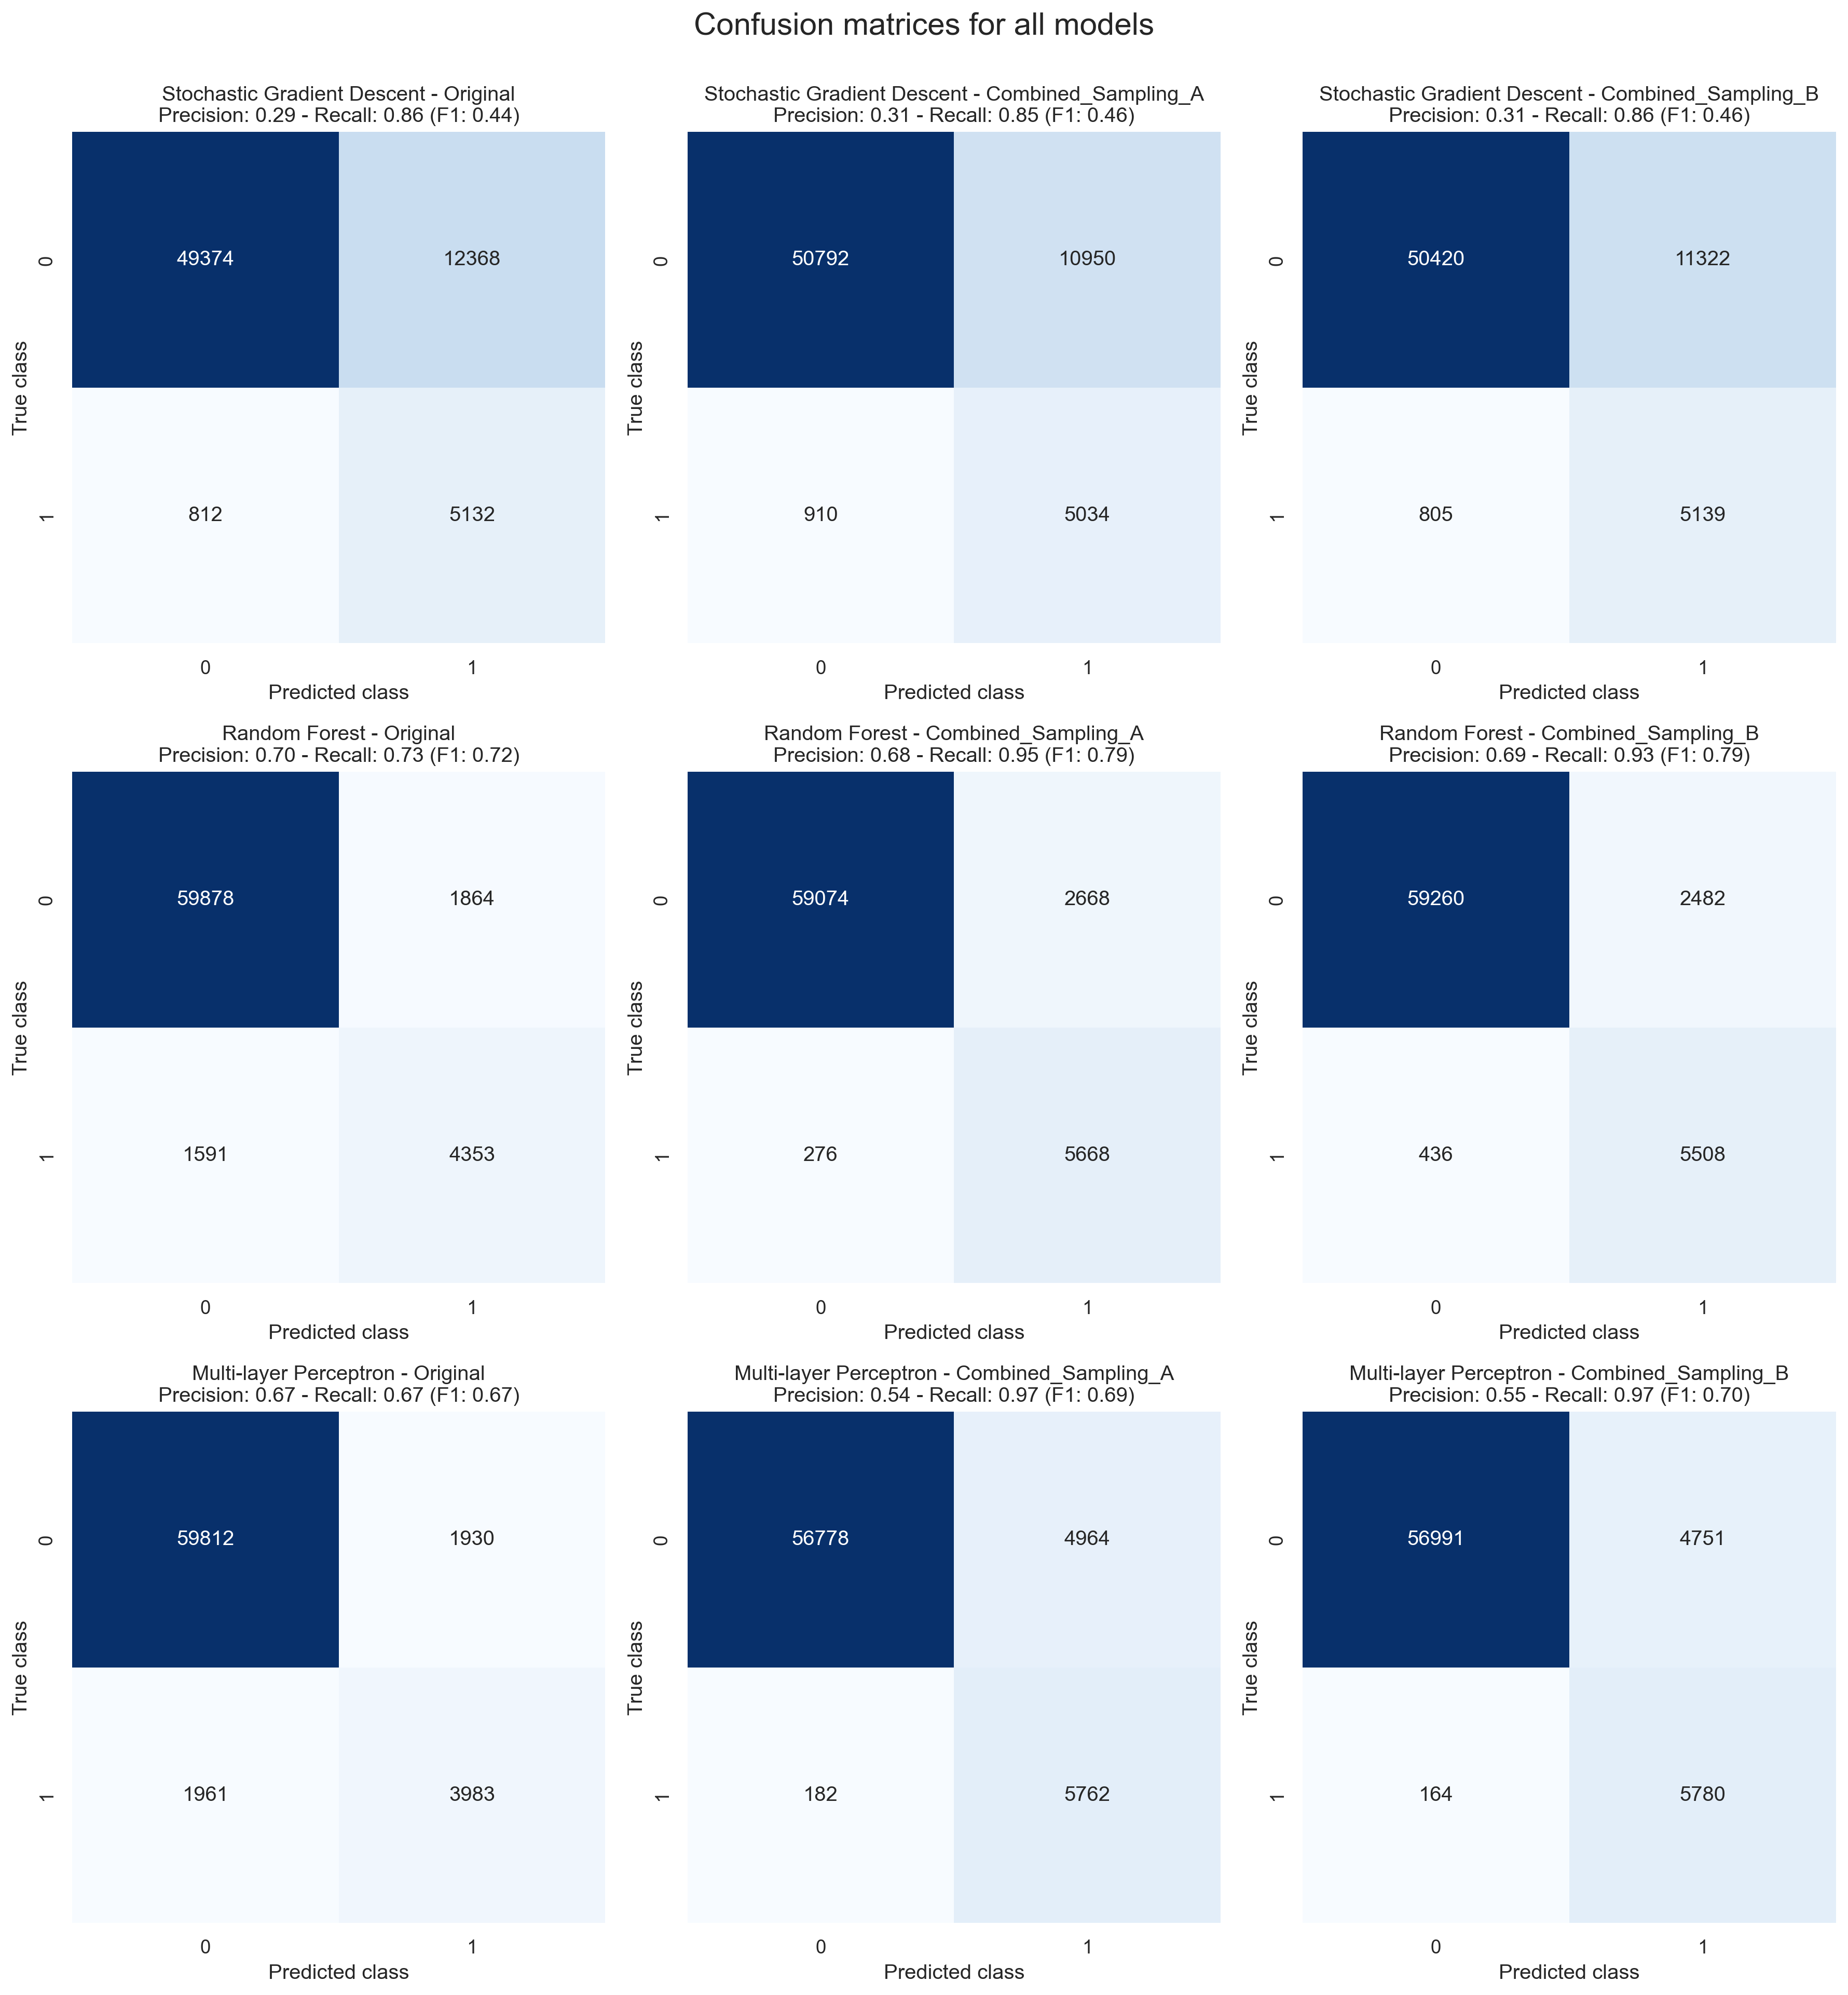

In [155]:
plt.figure(figsize=(15, 16))

for i, (name, result) in enumerate(all_results.items()):
    for n, dataset in enumerate(result.keys()):

        plt.subplot(3, 3, (i*3)+(n+1))
        sns.heatmap(result[dataset]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f"""{name} - {dataset}\nPrecision: {result[dataset]['metrics']['precision']:.2f} - Recall: {result[dataset]['metrics']['recall']:.2f} (F1: {result[dataset]['metrics']['f1']:.2f})""")
        plt.xlabel('Predicted class')
        plt.ylabel('True class')

plt.suptitle(f"Confusion matrices for all models", fontsize=18, y=1)
plt.tight_layout()
plt.show()


By observing all metrics and confusion matrices, for a classification threshold of 0.5 (default value used for prediction), all the models achieved high recall values (near or higher than 0.9) with the balanced resampled datasets. The precision values varied among models: SGD models achieved the lowest precision values (about 0.3) for all datasets, Random Forest models achieved the best values (about 0.7) for all datasets, while MLP models achieved a value near 0.7 for the original dataset and values of about 0.5 for the balanced datasets. While the MLP models trained with the balaced datasets achieved lower precision values than Random Forest models, they achieved the highest recall values (0.97).

### ROC curves and Precision-Recall curves

To better visualize the model performances, the Receiver Operating Characteristic (ROC) curves are calculated. The ROC curves are plots of the false positive rate versus the true positive rate for different classification thresholds values between 0.0 and 1.0.

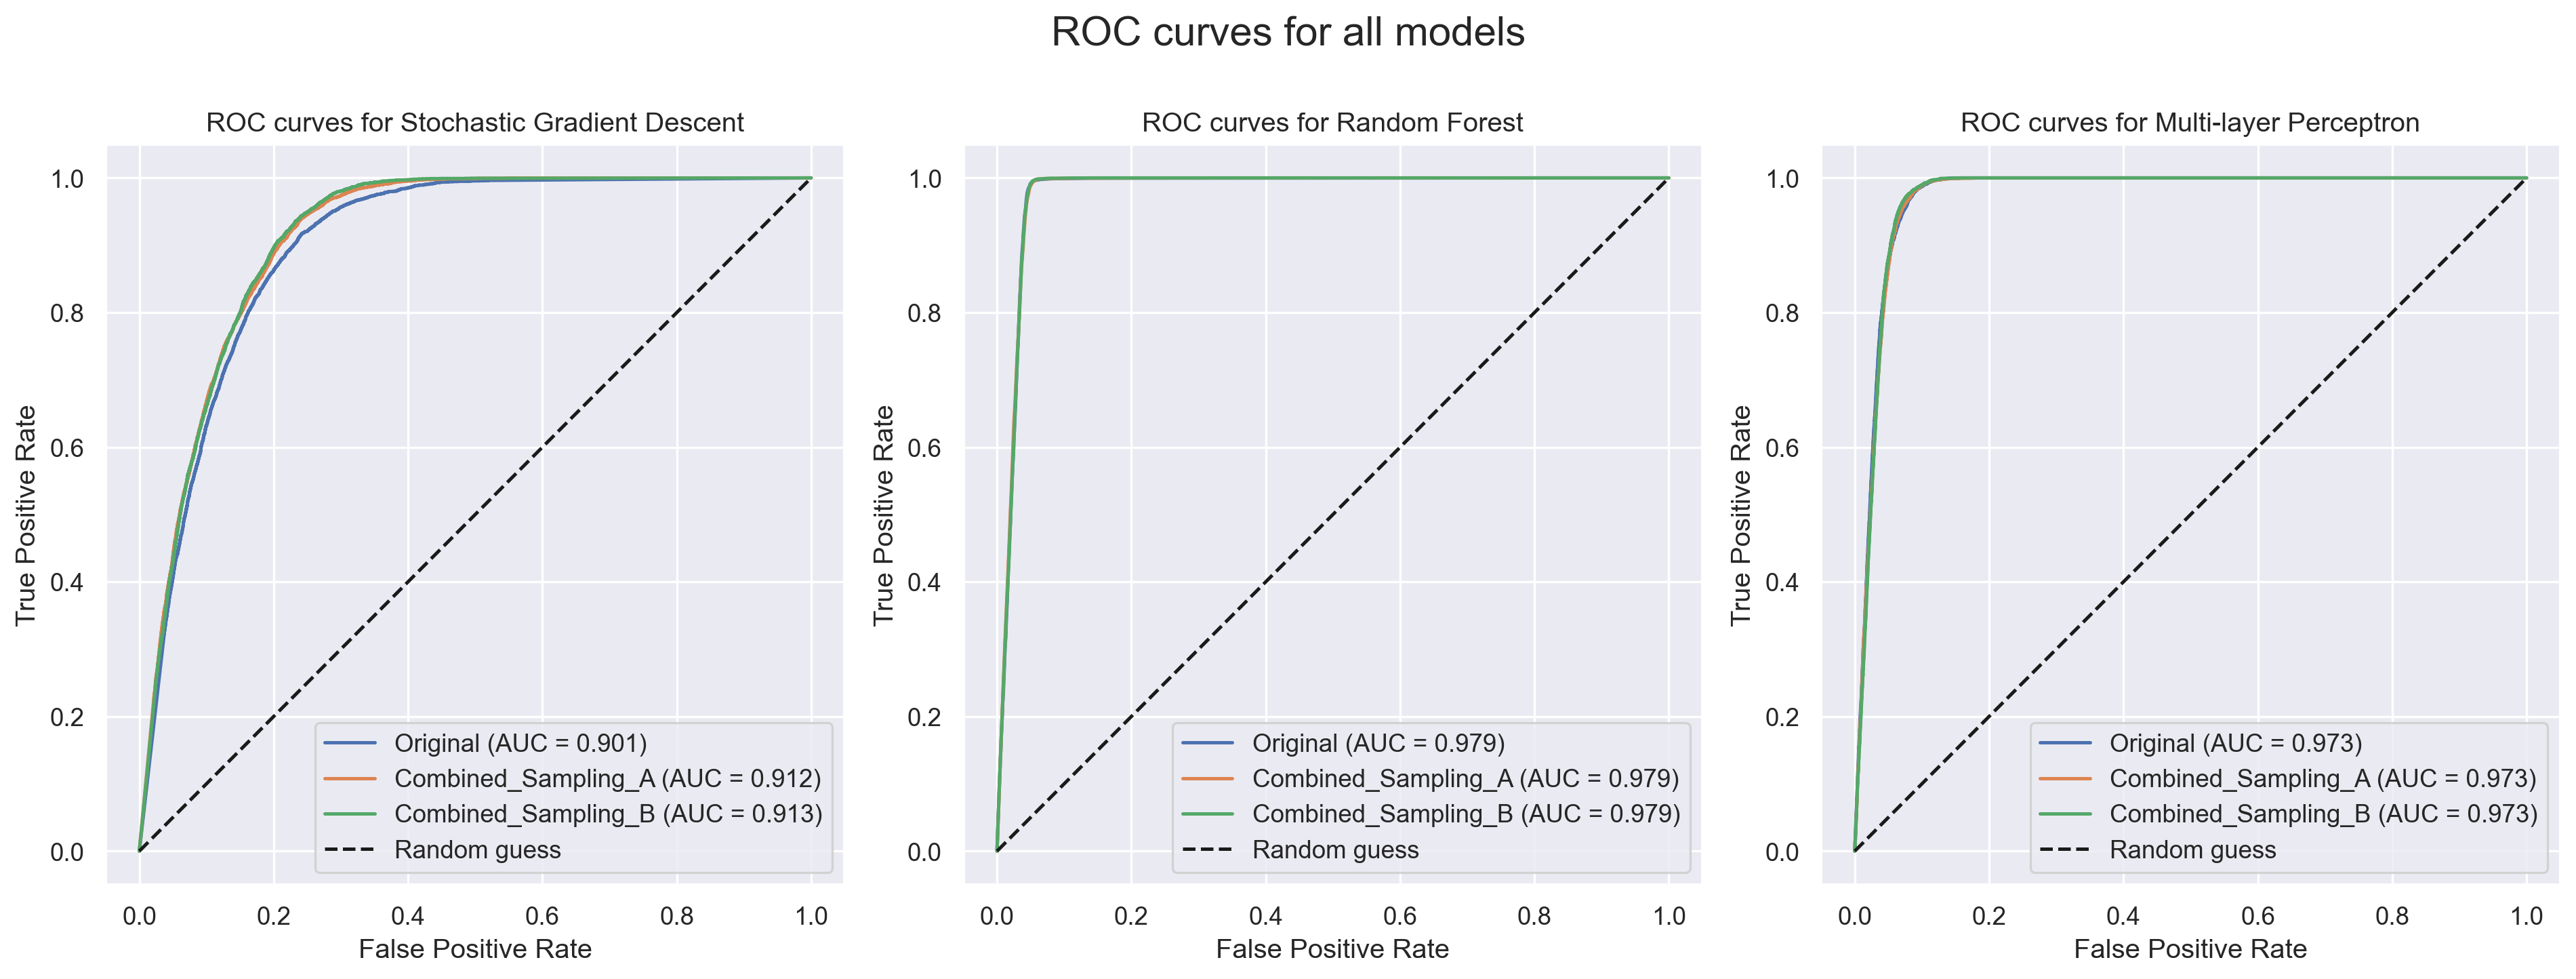

In [156]:
# Plot ROC curves from model results

plt.figure(figsize=(16, 6))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 3, i+1)

    for i, dataset in enumerate(result.keys()):

        fpr, tpr, _ = roc_curve(y_test, result[dataset]["predictions"])
        plt.plot(fpr, tpr, label=f"{dataset} (AUC = {result[dataset]["metrics"]['roc_auc']:.3f})")
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC curves for {name}")
    plt.legend(loc='lower right')
    plt.grid(True)

plt.suptitle(f"ROC curves for all models", fontsize=18, y=1)
plt.tight_layout()
plt.show()

The plots show how the Random Forest and MLP models achieved better classification performances, with higher areas under the curve (AUC), which represent a summary of the model skills, respect to the SGD models.

However, as the observations of the test dataset are strongly imbalanced (there are many samples of negative class respect to the positive class), it is more useful to calculate the precision-recall curves, which plot the precision and the recall values for different classification thresholds. For imbalanced datasets, the precision-recall curve provides a more accurate picture of the classification performance as it evaluates the fraction of true positives among positive predictions.

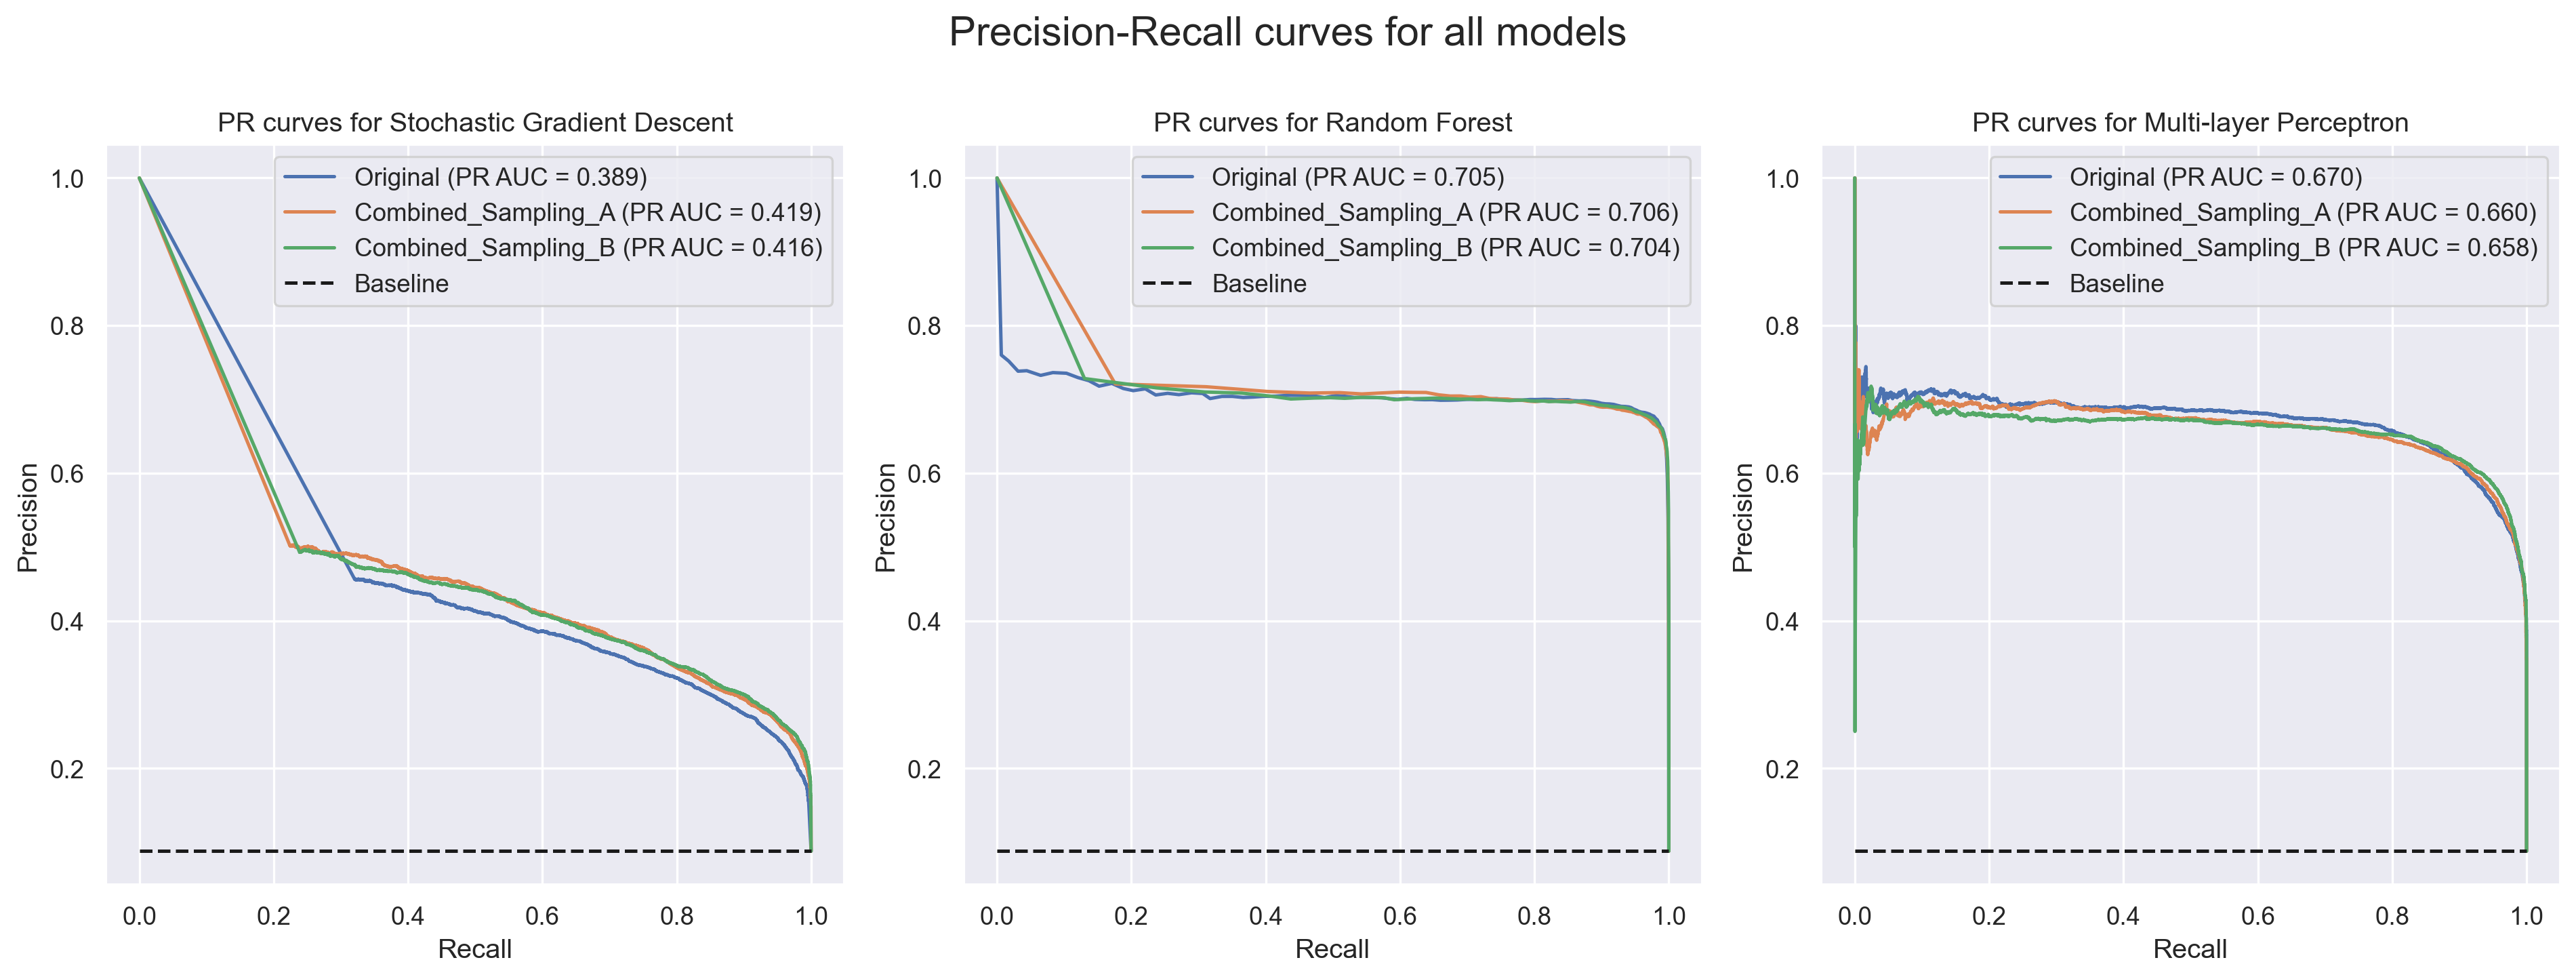

In [157]:
# Plot Precision-Recall curves from model results

plt.figure(figsize=(16, 6))

for i, (name, result) in enumerate(all_results.items()):

    plt.subplot(1, 3, i+1)

    for i, dataset in enumerate(result.keys()):

        precision, recall, _ = precision_recall_curve(y_test, result[dataset]["predictions"])
        plt.plot(recall, precision, label=f"{dataset} (PR AUC = {result[dataset]["metrics"]['pr_auc']:.3f})")
    
    plt.plot([0, 1], [sum(y_test)/len(y_test)]*2, 'k--', label='Baseline')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"PR curves for {name}")
    plt.legend(loc='upper right')
    plt.grid(True)

plt.suptitle(f"Precision-Recall curves for all models", fontsize=18, y=1)
plt.tight_layout()
plt.show()

Here can be observed that the AUC values are lower and more variable in the Precision-Recall curves (near or lower than 0.7) respect to the ROC curves (higher than 0.9). In particular, the PR AUC value is of about 0.40 for all SGD models, about 0.70 for all Random Forest models, 0.67 for the MLP model trained on the original dataset, and about 0.66 for the MLP models trained on the balanced resampled datasets.

## Conclusions

In this project, most trained models resulted in high recall values (near or higher than 0.9), in particular Random Forest (up to 0.95) and MLP (up to 0.97) models trained on the balanced datasets. These can be considered useful models if we want to obtain a low number of false negatives and we are not interested in the number of false positives. In fact, in this case we can correctly identify a high number of bank's clients with a high credit standing and that are more likely to pay regularly for a credit card.

However, if we are interested in a low number of false positives and identify only clients which are most likely to pay, models with a higher precision value are more useful. At this purpose, the Random Forest model trained on the original dataset obtained the highest precision value (0.70) and the lowest absolute number of false positives in the test dataset. The MLP model trained on the original dataset also obtained a similar number of false postives. By using these models, the lowest number of bank's clients with low credit standing will be wrongly classified as clients with high standing.